In [1]:
library(data.table)
library(stringr)
library(pheatmap)
library(ape)
library(ggplot2)
library(Rtsne)
library(sva)
library(VennDiagram)
library(readxl)
library(energy)
library(MASS)
library(quantreg)
library(limma)
library(Glimma)
library(edgeR)
library(RColorBrewer)
library(minerva)
library(dbscan)
library(amap)
library(NbClust)
library(apeglm)
library(gplots)
library(colorspace)
library(dendextend)
library(data.table)
library(topGO)
library(treemap)
library(ggbiplot)
library(factoextra)
library(ggrepel)
library(gridExtra)
library(cowplot)
library(GOSemSim)
library(tibble)
library(tidytext)
library(dplyr)
library(wordcloud2)
library(devtools)
library(GO.db)
library(ggwordcloud)
library(tidyverse)
library(cluster)
library(factoextra)
library(dynamicTreeCut)
library(CrossClustering)
library(corrplot)
library(dendsort)
library(ggdendro)

Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.
Loading required package: genefilter
Loading required package: BiocParallel
Loading required package: grid
Loading required package: futile.logger

Attaching package: ‘futile.logger’

The following object is masked from ‘package:mgcv’:

    scat


Attaching package: ‘VennDiagram’

The following object is masked from ‘package:ape’:

    rotate


Attaching package: ‘MASS’

The following object is masked from ‘package:genefilter’:

    area

Loading required package: SparseM

Attaching package: ‘SparseM’

The following object is masked from ‘package:base’:

    backsolve


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess


---------------------
Welcome to dendextend version 1.13.4
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github pag

In [2]:
color_AD <- "#FF3300"
color_ND <- "blue"
color_CHC_H <- color_ND
color_CHC_M <- "#FFCC00"
color_CHC_L <- "#FF3300"
font_size <- 10
font_size_add <- 2

circle_size_1 <- 2
circle_size_2 <- 3


## Define color of cells
## Define color of cells
## Define color of cells
Astrocytes = "#FEB24C"
Endothelial = "#88419D"
Microglia = "#9ECAE1"
Neurons = "#ADDD8E"
Oligodendrocytes = "#DD3497"
No_unique_enrichment = "#969696"
NS_DEPs = "gray88"

In [3]:
cal_ANOVA_test <- function(variable, group){
    pdata <- data.frame(variable=as.numeric(drop(t(variable))), group=factor(group))
    test_anova <- oneway.test(variable~group, data=pdata, var.equal=F)
    return(test_anova$p.value)
}

lm_sig_test <- function(re_variable, exp_variable){
    lm_data <- data.frame(re=as.numeric(re_variable), exp=as.numeric(exp_variable))
    fit_lm <- lm(re~exp, data = lm_data)
    #F <- summary(fit_lm)$fstatistic
    #return(pf(F[1], F[2], F[3], lower.tail = FALSE))
    return(summary(fit_lm)$coefficients[2,][c(1,4)])
}

cal_effect_size_mmd_median <- function(protein_intens, braak){
    intens <- numeric(0)
    for(i in sort(unique(braak))){
        intens <- c(intens, median(protein_intens[which(braak == i)]))
    }
    
    if(which.max(intens) > which.min(intens)) 
        return(log2(max(intens)/min(intens)))
    else
        return(log2(min(intens)/max(intens)))
}

cal_median_for_stage <- function(protein_intens, braak){
    intens <- numeric(0)
    for(i in sort(unique(braak))){
        intens <- c(intens, median(protein_intens[which(braak == i)]))
    }
    return(intens)
}

cal_mean_for_stage <- function(protein_intens, braak){
    intens <- numeric(0)
    for(i in sort(unique(braak))){
        intens <- c(intens, mean(protein_intens[which(braak == i)]))
    }
    return(intens)
}

cal_PC1_for_stage <- function(protein_intens, braak){
    intens <- NULL
    for(i in sort(unique(braak))){
        intens <- cbind(intens, 
                    prcomp(protein_intens[, which(braak == i)], center = TRUE, scale = TRUE)$x[,1])
    }
    return(intens)
}

cal_median_for_age <- function(protein_intens, age){
    intens <- numeric(0)
    for(i in sort(unique(age))){
        intens <- c(intens, median(protein_intens[which(age == i)]))
    }
    return(intens)
}

get_sig_protein <- function(proteins){
    single_proteins <- vector()
    for(i in proteins){
        single_proteins <- c(single_proteins, unlist(strsplit(i, split = ";")))
    }
    
    return(single_proteins)
}

get_single_protein <- function(proteins){
    single_proteins <- proteins[-grep(";", proteins)]
    return(single_proteins)
}


remove_multipleName_protein <- function(proteins){
    proteins[grep(";", proteins)] <- NA
    return(proteins)
}

get_first_protein <- function(proteins){
    single_proteins <- vector()
    for(i in proteins){
        #print(i)
        #print(unlist(strsplit(i, split = ";"))[1])
        single_proteins <- c(single_proteins, unlist(strsplit(i, split = ";"))[1])
    }
    return(single_proteins)
}

get_first_unique_protein <- function(proteins){
    existed <- get_single_protein(proteins)
    
    single_proteins <- vector()
    for(i in proteins){
        sub_proteins <- unlist(strsplit(i, split = ";"))
        if(length(sub_proteins) == 1)
            single_proteins <- c(single_proteins, sub_proteins)
        else{
            present <- TRUE
            for(j in sub_proteins){
                if(!(j %in% existed)){
                    existed <- c(existed, j)
                    single_proteins <- c(single_proteins, j)
                    present <- FALSE
                    break
                }
            }
            if(present){
                single_proteins <- c(single_proteins, i)
            }
        }
    }
    
    real_single_proteins <- get_first_protein(single_proteins)
    
    return(real_single_proteins)
    
    
}

In [4]:
CountFrequency_words <- function(functional_clusters){
    # Read the description of all GO:BP -- this will be the background to remove redundant words
    # You will need this file: i'll send by email
    all_go_bp <- fread("Public_database/go_terms_BP_all.txt", h=F, stringsAsFactors = F, sep="\t")
    
    # Create a list: each element of the list is a cluster

    all_dset <- list()
    all_dset[[1]] <- all_go_bp$V1
    
    for(i in sort(unique(functional_clusters$cluster))){
        all_dset[[i+1]] <- functional_clusters$term_name[which(functional_clusters$cluster == i)]
    }
    
    
    # Define output
    word_frequency_dset <- list()
    
    # Main loop to calculate word frequency
    for (i in 1:length(all_dset)){
      # Convert to dataframe and make sure there are characters only
      text <- data.frame(text=all_dset[[i]])
      text$text <- as.character(text$text)
      
      # Covert dataframe to tibble
      text_df <- tibble(line = 1:nrow(text), text = text)
      text_df <- mutate(text_df, text = text$text)
      
      # Count word occurrence
      x <- text_df %>% unnest_tokens(word, text) %>%    # split words
        anti_join(stop_words) %>%    # take out "a", "an", "the", etc.
        count(word, sort = TRUE)    # count occurrences
      
      # Convert back to dataframe
      x <- as.data.frame(x)
      colnames(x) <- c("word", "freq")
      
      # Assign to output
      word_frequency_dset[[i]] <- x
    }
    
    # Extract background and calculate % and take top 2.5%
    bkg <- word_frequency_dset[[1]]
    bkg$perc <- bkg$freq/nrow(all_go_bp)
    top_5_pc <- bkg[which(bkg$perc >= 0.025),]
    
    # Now exclude these frequent words from the clusters names
    for (i in 2:length(word_frequency_dset)){
      sb <- word_frequency_dset[[i]]
      sb <- sb[which(!(sb$word %in% top_5_pc$word)),]
      word_frequency_dset[[i]] <- sb
    }
    
    # Try some plot -- seems like it is not possible to plot multiple plots in one
    #wordcloud2(data = word_frequency_dset[[2]])
    #wordcloud2(data = word_frequency_dset[[3]])
    #wordcloud2(data = word_frequency_dset[[4]])
    #wordcloud2(data = word_frequency_dset[[5]])
    
    return(word_frequency_dset)
}

In [5]:
setwd("~/ownCloud/Meng/")

In [6]:
cell_type_matrix <- read.table("R_workstation/100_plus_proteomic_cell_type_enrichment/EWCE_celltype.tsv",
                               header =TRUE,
                               stringsAsFactors=F, sep = "\t")

In [7]:
High_quality_protein_intensity_matrix <- read.table('R_workstation/100_plus_proteomic_DATA/High_quality_protein_intensity_matrix.tsv', header =TRUE,
                                                    stringsAsFactors=F, sep = "\t")

In [8]:
dim(High_quality_protein_intensity_matrix)

[1] 3448  191

In [9]:
celltype <- cell_type_matrix[which(cell_type_matrix$protein %in% High_quality_protein_intensity_matrix$protein), ]

In [10]:
protein_info <- data.frame(protein = High_quality_protein_intensity_matrix$protein,
                           genes = get_first_protein(High_quality_protein_intensity_matrix$protein))

In [11]:
protein_info <- data.frame(protein_info, celltype = celltype$celltype)

In [12]:
protein_info$HUGO_gene <- celltype$HUGO_gene

In [13]:
table(protein_info$celltype)


      Astrocytes      Endothelial        ExNeurons        InNeurons 
              68                6               77               23 
       Microglia              OPC Oligodendrocytes          Unknown 
              34               18               75               13 

In [14]:
protein_info

protein                            genes    celltype         HUGO_gene
1    SLC12A2                            SLC12A2  Oligodendrocytes SLC12A2  
2    CASKIN1                            CASKIN1  NA               CASKIN1  
3    GNG2                               GNG2     NA               GNG2     
4    CARNS1                             CARNS1   Oligodendrocytes CARNS1   
5    FH                                 FH       NA               FH       
6    EFHD2                              EFHD2    NA               EFHD2    
7    PCLO                               PCLO     NA               PCLO     
8    HSPA1A;HSPA1B                      HSPA1A   NA               HSPA1A   
9    STIP1                              STIP1    NA               STIP1    
10   CTNND1                             CTNND1   NA               CTNND1   
11   INPP5A                             INPP5A   NA               INPP5A   
12   SEPT11                             SEPT11   NA               SEPTIN11 
13   PKP4                               PKP4     NA               PKP4     
14   RYR2                               RYR2     ExNeurons        RYR2     
15   PTPRK                              PTPRK    NA               PTPRK    
16   CAMKV                              CAMKV    NA               CAMKV    
17   BCR                                BCR      Unknown          BCR      
18   NDUFV2                             NDUFV2   NA               NDUFV2   
19   IDH3B                              IDH3B    NA               IDH3B    
20   FMNL2                              FMNL2    NA               FMNL2    
21   SYT12                              SYT12    NA               SYT12    
22   GRHPR                              GRHPR    NA               GRHPR    
23   CSE1L                              CSE1L    NA               CSE1L    
24   DNAJC6                             DNAJC6   NA               DNAJC6   
25   DUSP3                              DUSP3    NA               DUSP3    
26   VDAC3                              VDAC3    NA               VDAC3    
27   PITPNM3                            PITPNM3  NA               PITPNM3  
28   SRPK2                              SRPK2    NA               SRPK2    
29   AP2A1                              AP2A1    NA               AP2A1    
30   RCN1                               RCN1     NA               RCN1     
⋮    ⋮                                  ⋮        ⋮                ⋮        
3419 KLC1;KLC2;KLC4                     KLC1     NA               KLC1     
3420 TM9SF3                             TM9SF3   NA               TM9SF3   
3421 PLEKHA6                            PLEKHA6  NA               PLEKHA6  
3422 KCTD12;KCTD16                      KCTD12   Microglia        KCTD12   
3423 SLC16A7                            SLC16A7  NA               SLC16A7  
3424 PPP3CA;PPP3CB;PPP3CC               PPP3CA   NA               PPP3CA   
3425 EHD3;EHD4                          EHD3     NA               EHD3     
3426 PEX14                              PEX14    NA               PEX14    
3427 TUBB;TUBB4A;TUBB4B                 TUBB     NA               TUBB     
3428 TUBA1A;TUBA1B;TUBA1C;TUBA4A;TUBAL3 TUBA1A   NA               TUBA1A   
3429 PTPRD;PTPRF                        PTPRD    NA               PTPRD    
3430 H1F0                               H1F0     NA               H1-0     
3431 FAM210A                            FAM210A  NA               FAM210A  
3432 EPB41;EPB41L1;EPB41L3              EPB41    NA               EPB41    
3433 PABPN1                             PABPN1   NA               PABPN1   
3434 KCND2;KCND3                        KCND2    NA               KCND2    
3435 JMJD7;PLA2G4B                      JMJD7    NA               JMJD7    
3436 U2AF1;U2AF1L4;U2AF1L5              U2AF1    NA               U2AF1    
3437 ATP6V1G1;ATP6V1G2                  ATP6V1G1 NA               ATP6V1G1 
3438 ATP5J2;ATP5MF                      ATP5J2   NA               ATP5MF   
3439 ACTB                               ACTB     NA  

In [15]:
load("100_plus_project/Metadata/metadata_clean_update20211215.Rdata")
#metadata_clean
metadata <- metadata_clean

colnames(metadata)

[1] "nbb"                                 "autopsy"                            
 [3] "sampleprepRandomization (4 batches)" "zmRandomization (10 batches)"       
 [5] "Autopsy_nr"                          "GROUP"                              
 [7] "Mass-Spec filenames (1)"             "Mass-Spec filenames (2)"            
 [9] "Diagnosis"                           "sex"                                
[11] "age"                                 "braak"                              
[13] "amyloid"                             "pmd"                                
[15] "ph"                                  "weight"                             
[17] "csf"                                 "apoe"                               
[19] "barcode"                             "Abeta"                              
[21] "APOE"

In [16]:
names_sample <- as.array(colnames(High_quality_protein_intensity_matrix)[2:ncol(High_quality_protein_intensity_matrix)])
names_sample <- as.vector(apply(names_sample, 1, function(names){return (str_sub(names, 11))}))

filenames_map_index <- integer(length(names_sample))
for (i in 1:length(names_sample)){
    if ((names_sample[i] %in% metadata[,"Mass-Spec filenames (1)"]) | 
        (names_sample[i] %in% metadata[,"Mass-Spec filenames (2)"]))
        filenames_map_index[i] <- ifelse(length(which(metadata[,"Mass-Spec filenames (1)"] == names_sample[i]))==0,
                                     which(metadata[,"Mass-Spec filenames (2)"] == names_sample[i]), 
                                     which(metadata[,"Mass-Spec filenames (1)"] == names_sample[i]))
    else
        print("ERROR, file name not in metadata!")
}

#print(filenames_map_index)

metadata <- metadata[filenames_map_index, ][c("nbb", "autopsy", "sex", "age", "weight", "GROUP", "pmd", "braak", 
                                              "Abeta", "APOE")]
colnames(metadata) <- c("nbb", "autopsy", "sex", "age", "weight", "GROUP", "pmd", "braak", "amyloid", "apoe")
metadata$filenames <- names_sample

colSums(is.na(metadata))

metadata$sex[(metadata$sex=='F') | (metadata$sex=='f')] <- "F"
metadata$sex[(metadata$sex=='M') | (metadata$sex=='m')] <- "M"
metadata$braak <- as.numeric(metadata$braak)
metadata$age <- as.numeric(metadata$age)


index_AD <- which(metadata$GROUP == "AD")
index_CHC <- which(metadata$GROUP == "CHC")
index_ND <- which(metadata$GROUP == "ND")
num_AD <- length(index_AD)
num_CHC <- length(index_CHC)
num_ND <- length(index_ND)

metadata[which((metadata$GROUP=="ND") & (is.na(metadata$braak))),]$braak <- median(metadata[index_ND,]$braak, na.rm = TRUE)

metadata$fBraak <- metadata$braak
metadata[which(metadata$braak == 0), ]$fBraak <- 1

metadata$cBraak <- as.numeric(lapply(metadata$braak, function(braak){if (braak==0 | braak==1 | braak==2)
                                                                return(1)
                                                          if (braak==3 | braak==4)
                                                                return(2)
                                                          if (braak==5 | braak==6)
                                                                return(3)}))

metadata[which((metadata$GROUP=="AD") & (is.na(metadata$amyloid))),]$amyloid <- median(metadata[which((metadata$GROUP=="AD") & (!is.na(metadata$amyloid))),]$amyloid)
metadata[which((metadata$GROUP=="ND") & (is.na(metadata$amyloid))),]$amyloid <- median(metadata[which((metadata$GROUP=="ND") & (!is.na(metadata$amyloid))),]$amyloid)

metadata$O_amyloid <- sapply(metadata$amyloid, function(x){
    if(is.na(x)){
        return(NA)
    }
    if(round(x) == 0){
        return("O")
    }
    if(round(x) == 1){
        return("A")
    }
    if(round(x) == 2){
        return("B")
    }
    if(round(x) == 3){
        return("C")
    }
    
})

get_mod <- function(apoe){
    apoe_count <- as.matrix(table(apoe))
    return (rownames(apoe_count)[which.max(apoe_count)])
}

metadata[which((metadata$GROUP=="ND") & (is.na(metadata$apoe))),]$apoe <- get_mod(metadata[index_ND,]$apoe)

metadata$apoe_OR <- as.numeric(metadata$apoe)

metadata[which((metadata$apoe == 22)|(metadata$apoe == 23)|(metadata$apoe == 32)),]$apoe_OR <- 0.6
metadata[which((metadata$apoe == 24)|(metadata$apoe == 42)),]$apoe_OR <- 2.6
metadata[which(metadata$apoe == 33),]$apoe_OR <- 1
metadata[which((metadata$apoe == 34)|(metadata$apoe == 43)),]$apoe_OR <- 3.2
metadata[which(metadata$apoe == 44),]$apoe_OR <- 14.9

convert_time_2_numeric <- function(pmd){
    if (is.na(pmd))
        return (NA)
    else
        return (as.numeric(str_sub(pmd, start=1, end=2))+as.numeric(str_sub(pmd, 4))/60)
}

metadata$pmd_numeric <- apply(metadata["pmd"], 1, convert_time_2_numeric)
metadata[which(is.na(metadata$pmd_numeric)),]$pmd_numeric <- median(metadata$pmd_numeric, na.rm = TRUE)


nbb   autopsy       sex       age    weight     GROUP       pmd     braak 
        0         0         0         0         2         0         2         2 
  amyloid      apoe filenames 
       17        16         0

In [17]:
#dim(High_quality_protein_intensity_matrix)
#
#metadata <- read_excel("100_plus_project/Metadata/2019_07_23_Proteomics_Metadata_forMeng_v3.xlsx",
#                       sheet=1,col_names=TRUE, na="NA")
#metadata <- as.data.frame(metadata)
##colnames(metadata)
#
#names_sample <- as.array(colnames(High_quality_protein_intensity_matrix)[2:ncol(High_quality_protein_intensity_matrix)])
#names_sample <- as.vector(apply(names_sample, 1, function(names){return (str_sub(names, 11))}))
#
#filenames_map_index <- integer(length(names_sample))
#for (i in 1:length(names_sample)){
#    if ((names_sample[i] %in% metadata[,"Mass-Spec filenames (1)"]) | 
#        (names_sample[i] %in% metadata[,"Mass-Spec filenames (2)"]))
#        filenames_map_index[i] <- ifelse(length(which(metadata[,"Mass-Spec filenames (1)"] == names_sample[i]))==0,
#                                     which(metadata[,"Mass-Spec filenames (2)"] == names_sample[i]), 
#                                     which(metadata[,"Mass-Spec filenames (1)"] == names_sample[i]))
#    else
#        print("ERROR, file name not in metadata!")
#}
#
##print(filenames_map_index)
#
#metadata <- metadata[filenames_map_index, ][c("nbb", "autopsy...3", "sex", "age", "weight", "GROUP...17", 
#                                              "pmd", "braak", "amyloid", "apoe", 
#                                              "Mass-Spec filenames (1)", "Mass-Spec filenames (2)")]
#colnames(metadata) <- c("nbb", "autopsy", "sex", "age", "weight", "GROUP", "pmd", "braak", "amyloid", 
#                        "apoe", "filenames(1)", "filenames(2)")
#metadata$filenames <- names_sample
#
#metadata$sex[(metadata$sex=='F') | (metadata$sex=='f')] <- "F"
#metadata$sex[(metadata$sex=='M') | (metadata$sex=='m')] <- "M"
#metadata$braak <- as.numeric(metadata$braak)
#metadata$age <- as.numeric(metadata$age)
#
#
#index_AD <- which(metadata$GROUP == "AD")
#index_CHC <- which(metadata$GROUP == "CHC")
#index_ND <- which(metadata$GROUP == "ND")
#num_AD <- length(index_AD)
#num_CHC <- length(index_CHC)
#num_ND <- length(index_ND)
#
#metadata[which((metadata$GROUP=="ND") & (is.na(metadata$braak))),]$braak <- median(metadata[index_ND,]$braak, na.rm = TRUE)
#metadata[which((metadata$GROUP=="CHC") & (is.na(metadata$braak))),]$braak <- median(metadata[index_CHC,]$braak, na.rm = TRUE)
#
#metadata$fBraak <- metadata$braak
#metadata[which(metadata$braak == 0), ]$fBraak <- 1
#
#metadata$cBraak <- as.numeric(lapply(metadata$braak, function(braak){if (braak==0 | braak==1 | braak==2)
#                                                                return(1)
#                                                          if (braak==3 | braak==4)
#                                                                return(2)
#                                                          if (braak==5 | braak==6)
#                                                                return(3)}))
#
#metadata[which((metadata$GROUP=="AD") & (is.na(metadata$amyloid))),]$amyloid <- 'C'
#metadata[which((metadata$GROUP=="ND") & (is.na(metadata$amyloid))),]$amyloid <- 'A'
#metadata[which((metadata$GROUP=="CHC") & (is.na(metadata$amyloid))),]$amyloid <- 'B'
#
#
#get_mod <- function(apoe){
#    apoe_count <- as.matrix(table(apoe))
#    return (rownames(apoe_count)[which.max(apoe_count)])
#}
#
##metadata[which((metadata$GROUP=="AD") & (is.na(metadata$apoe))),]$apoe <- get_mod(metadata[index_AD,]$apoe)
#metadata[which((metadata$GROUP=="ND") & (is.na(metadata$apoe))),]$apoe <- get_mod(metadata[index_ND,]$apoe)
##metadata[which((metadata$GROUP=="CHC") & (is.na(metadata$apoe))),]$apoe <- get_mod(metadata[index_CHC,]$apoe)
#
#metadata$apoe_OR <- as.numeric(metadata$apoe)
#
#metadata[which((metadata$apoe == 22)|(metadata$apoe == 23)|(metadata$apoe == 32)),]$apoe_OR <- 0.6
#metadata[which((metadata$apoe == 24)|(metadata$apoe == 42)),]$apoe_OR <- 2.6
#metadata[which(metadata$apoe == 33),]$apoe_OR <- 1
#metadata[which((metadata$apoe == 34)|(metadata$apoe == 43)),]$apoe_OR <- 3.2
#metadata[which(metadata$apoe == 44),]$apoe_OR <- 14.9
#
#convert_time_2_numeric <- function(pmd){
#    if (is.na(pmd))
#        return (NA)
#    else
#        return (as.numeric(str_sub(pmd, start=1, end=2))+as.numeric(str_sub(pmd, 4))/60)
#}
#
#metadata$pmd_numeric <- apply(metadata["pmd"], 1, convert_time_2_numeric)
#metadata[which(is.na(metadata$pmd_numeric)),]$pmd_numeric <- median(metadata$pmd_numeric, na.rm = TRUE)
#
#
#MMSE_data <- read_excel("100_plus_project/Metadata/20190513_Centenarians_info.xlsx",sheet=1,col_names=TRUE, na="NA")
##MMSE_data
#MMSE_data <- MMSE_data[c('NBB', 'MMSE_LV')]
##nrow(MMSE_data)
#
#metadata$MMSE <- rep(NA, nrow(metadata))
#
#for (i in 1:nrow(metadata)){
#    if (metadata[i,]$GROUP == "CHC"){
#        metadata[i,]$MMSE <- MMSE_data[which(MMSE_data$NBB == metadata[i,]$nbb),]$MMSE_LV
#    }
#}
#
#metadata$MMSE <- as.numeric(metadata$MMSE)
#metadata$amyloid <- factor(metadata$amyloid, levels = c("O", "A", "B", "C"))
#
#metadata$Abeta <- 0
#metadata[metadata$amyloid == "A", ]$Abeta <- 1
#metadata[metadata$amyloid == "B", ]$Abeta <- 2
#metadata[metadata$amyloid == "C", ]$Abeta <- 3

In [18]:
cal_sample_batch_index <- function(sample_names){
    sample_index <- apply(as.data.frame(sample_names), 1, str_sub, -3)
    for (i in 1:length(sample_index)){
        sample_index[i] <- gsub("_", "0", sample_index[i])
    }
    sample_index <- as.numeric(sample_index)
    sample_index <- (sample_index - 1) %/% 8
    extra_batch <- max(sample_index, na.rm=TRUE) + 1
    sample_index[is.na(sample_index)] <- extra_batch
    return(sample_index)
}

protein_intensity_combat <- ComBat(dat=log2(as.matrix(High_quality_protein_intensity_matrix[,-1])), 
                                     batch=cal_sample_batch_index(metadata$filenames), mod=NULL, par.prior=TRUE, prior.plots=FALSE)
rownames(protein_intensity_combat) <- High_quality_protein_intensity_matrix$protein

Warning message in cal_sample_batch_index(metadata$filenames):
“NAs introduced by coercion”Found29batches
Adjusting for0covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



In [19]:
protein <- High_quality_protein_intensity_matrix$protein

In [20]:
#protein_intensity_combat <- cbind(protein, protein_intensity_combat)

In [21]:
#protein_intensity_combat

In [32]:
write.table(protein_intensity_combat, 
                file = "100_plus_results/protein_intensity_combat.tsv", 
                col.names = TRUE, row.names = FALSE, quote = FALSE, sep = "\t")

In [22]:
#################Differentially expressed proteins analysis###############

In [23]:
Braak_test_index <- which((metadata$GROUP != "CHC"))
length(Braak_test_index)

protein_intensity_combat_nonlog <- 2^protein_intensity_combat

[1] 141

In [24]:
pathology_related_proteins_ANOVA <- as.data.frame(apply(protein_intensity_combat[, Braak_test_index], 1, 
                                                        cal_ANOVA_test, metadata[Braak_test_index, ]$fBraak))
colnames(pathology_related_proteins_ANOVA) <- c("p_value")
pathology_related_proteins_ANOVA$adjusted_p_value <- p.adjust(pathology_related_proteins_ANOVA$p_value,
                                                              method="BH")

pathology_related_proteins_ANOVA$effect_size <- apply(protein_intensity_combat_nonlog[, Braak_test_index], 1, 
                                                      cal_effect_size_mmd_median, metadata[Braak_test_index, ]$fBraak)
#pathology_related_proteins_ANOVA$Gene <- get_first_unique_protein(High_quality_protein_intensity_matrix$protein)


pathology_related_proteins_lm <- as.data.frame(t(apply(protein_intensity_combat[, Braak_test_index], 1, 
                                                       lm_sig_test, metadata[Braak_test_index,]$fBraak)))
colnames(pathology_related_proteins_lm) <- c("effect_size", "p_value")
pathology_related_proteins_lm$adjusted_p_value <- p.adjust(pathology_related_proteins_lm$p_value, 
                                                              method="BH")

#pathology_related_proteins_lm$effect_size <- apply(protein_intensity_combat_nonlog[, Braak_test_index], 1, 
#                                                      cal_effect_size_mmd_median, metadata[Braak_test_index, ]$fBraak)
#pathology_related_proteins_lm$Gene <- get_first_unique_protein(High_quality_protein_intensity_matrix$protein)

In [25]:
sum(pathology_related_proteins_ANOVA$effect_size < 0)
sum(pathology_related_proteins_ANOVA$effect_size > 0)

[1] 1832

[1] 1616

In [26]:
sum(pathology_related_proteins_lm$effect_size < 0)
sum(pathology_related_proteins_lm$effect_size > 0)

[1] 1809

[1] 1639

In [27]:
top_percent_p <- 0.05
top_percent_lfc <- 0.05

down_index_ANOVA <- which(pathology_related_proteins_ANOVA$effect_size < 0)
top_down_ANOVA_lfc <- down_index_ANOVA[order(pathology_related_proteins_ANOVA[down_index_ANOVA, ]$effect_size)[1:round(length(down_index_ANOVA) * top_percent_lfc)]]
top_down_ANOVA_p <- down_index_ANOVA[order(pathology_related_proteins_ANOVA[down_index_ANOVA, ]$adjusted_p_value)[1:round(length(down_index_ANOVA) * top_percent_p)]]
top_down_ANOVA <- intersect(top_down_ANOVA_p, top_down_ANOVA_lfc)
length(top_down_ANOVA)

up_index_ANOVA <- which(pathology_related_proteins_ANOVA$effect_size > 0)
top_up_ANOVA_lfc <- up_index_ANOVA[order(pathology_related_proteins_ANOVA[up_index_ANOVA, ]$effect_size, decreasing = TRUE)[1:round(length(up_index_ANOVA) * top_percent_lfc)]]
top_up_ANOVA_p <- up_index_ANOVA[order(pathology_related_proteins_ANOVA[up_index_ANOVA, ]$adjusted_p_value)[1:round(length(up_index_ANOVA) * top_percent_p)]]
top_up_ANOVA <- intersect(top_up_ANOVA_p, top_up_ANOVA_lfc)
length(top_up_ANOVA)

down_index_lm <- which(pathology_related_proteins_lm$effect_size < 0)
top_down_lm_lfc <- down_index_lm[order(pathology_related_proteins_lm[down_index_lm, ]$effect_size)[1:round(length(down_index_lm) * top_percent_lfc)]]
top_down_lm_p <- down_index_lm[order(pathology_related_proteins_lm[down_index_lm, ]$adjusted_p_value)[1:round(length(down_index_lm) * top_percent_p)]]
top_down_lm <- intersect(top_down_lm_p, top_down_lm_lfc)
length(top_down_lm)

up_index_lm <- which(pathology_related_proteins_lm$effect_size > 0)
top_up_lm_lfc <- up_index_lm[order(pathology_related_proteins_lm[up_index_lm, ]$effect_size, decreasing = TRUE)[1:round(length(up_index_lm) * top_percent_lfc)]]
top_up_lm_p <- up_index_lm[order(pathology_related_proteins_lm[up_index_lm, ]$adjusted_p_value)[1:round(length(up_index_lm) * top_percent_p)]]
top_up_lm <- intersect(top_up_lm_p, top_up_lm_lfc)
length(top_up_lm)

[1] 13

[1] 28

[1] 30

[1] 37

In [28]:
topT_down_union <- union(top_down_ANOVA, top_down_lm)
topT_up_union <- union(top_up_ANOVA, top_up_lm)
length(topT_down_union)
length(topT_up_union)

topT_sig_index <- c(topT_down_union,topT_up_union)
length(topT_sig_index)

[1] 30

[1] 40

[1] 70

In [29]:
top_percent_p <- 0.20
top_percent_lfc <- 0.20

## Top down-regulating proteins ##
## Top down-regulating proteins ##

down_index_ANOVA <- which(pathology_related_proteins_ANOVA$effect_size < 0)

top_down_ANOVA_lfc <- down_index_ANOVA[order(pathology_related_proteins_ANOVA[down_index_ANOVA, ]$effect_size)[1:round(length(down_index_ANOVA) * top_percent_lfc)]]
top_down_ANOVA_p <- down_index_ANOVA[order(pathology_related_proteins_ANOVA[down_index_ANOVA, ]$adjusted_p_value)[1:round(length(down_index_ANOVA) * top_percent_p)]]

top_down_ANOVA <- intersect(top_down_ANOVA_p, top_down_ANOVA_lfc)
length(top_down_ANOVA)

up_index_ANOVA <- which(pathology_related_proteins_ANOVA$effect_size > 0)

top_up_ANOVA_lfc <- up_index_ANOVA[order(pathology_related_proteins_ANOVA[up_index_ANOVA, ]$effect_size, decreasing = TRUE)[1:round(length(up_index_ANOVA) * top_percent_lfc)]]
top_up_ANOVA_p <- up_index_ANOVA[order(pathology_related_proteins_ANOVA[up_index_ANOVA, ]$adjusted_p_value)[1:round(length(up_index_ANOVA) * top_percent_p)]]

top_up_ANOVA <- intersect(top_up_ANOVA_p, top_up_ANOVA_lfc)
length(top_up_ANOVA)

#plot_selected_protein_lfc(pathology_related_proteins_ANOVA, c(top_up_ANOVA, top_down_ANOVA))

down_index_lm <- which(pathology_related_proteins_lm$effect_size < 0)

top_down_lm_lfc <- down_index_lm[order(pathology_related_proteins_lm[down_index_lm, ]$effect_size)[1:round(length(down_index_lm) * top_percent_lfc)]]
top_down_lm_p <- down_index_lm[order(pathology_related_proteins_lm[down_index_lm, ]$adjusted_p_value)[1:round(length(down_index_lm) * top_percent_p)]]

top_down_lm <- intersect(top_down_lm_p, top_down_lm_lfc)
length(top_down_lm)

up_index_lm <- which(pathology_related_proteins_lm$effect_size > 0)

top_up_lm_lfc <- up_index_lm[order(pathology_related_proteins_lm[up_index_lm, ]$effect_size, decreasing = TRUE)[1:round(length(up_index_lm) * top_percent_lfc)]]
top_up_lm_p <- up_index_lm[order(pathology_related_proteins_lm[up_index_lm, ]$adjusted_p_value)[1:round(length(up_index_lm) * top_percent_p)]]

top_up_lm <- intersect(top_up_lm_p, top_up_lm_lfc)
length(top_up_lm)

#plot_selected_protein_es(pathology_related_proteins_lm, c(top_down_lm, top_up_lm))

[1] 140

[1] 190

[1] 206

[1] 235

In [30]:
top_down_union <- union(top_down_ANOVA, top_down_lm)
top_up_union <- union(top_up_ANOVA, top_up_lm)
length(top_down_union)
length(top_up_union)

sig_index <- c(top_down_union,top_up_union)
length(sig_index)

[1] 226

[1] 246

[1] 472

In [109]:
colnames(pathology_related_proteins_ANOVA) <- paste("ANOVA", colnames(pathology_related_proteins_ANOVA), sep="_")

In [110]:
colnames(pathology_related_proteins_lm) <- paste("lm", colnames(pathology_related_proteins_lm), sep="_")

In [111]:
Braak_2tests <- cbind(pathology_related_proteins_ANOVA, pathology_related_proteins_lm)

In [112]:
Braak_2tests$in_top20 <- "no"

In [113]:
Braak_2tests[sig_index, ]$in_top20  <- "yes"

In [116]:
save(Braak_2tests, file="Temp_results/Braak_2tests_results.Rdata")

In [115]:
table(Braak_2tests$in_top20)


  no  yes 
2976  472 

In [55]:
Braak_test_index <- which((metadata$GROUP != "CHC") & (metadata$age<100))

In [56]:
median_stage_exps_ANOVA <- as.data.frame(t(apply(protein_intensity_combat[sig_index, ][, Braak_test_index], 1, 
                                                 cal_median_for_stage, metadata[Braak_test_index, ]$fBraak)))

colnames(median_stage_exps_ANOVA) <- c("0/I", "II", "III", "IV", "V", "VI")

median_stage_exps_ANOVA <- scale(median_stage_exps_ANOVA, center = TRUE, scale = TRUE)
median_stage_exps_ANOVA <- t(scale(t(median_stage_exps_ANOVA), center = TRUE, scale = TRUE))

#apply(median_stage_exps_ANOVA, 2, mean)
#apply(median_stage_exps_ANOVA, 2, sd)

hc <- hclust(amap:::Dist(t(median_stage_exps_ANOVA), 
                         method = "pearson"), method = "ward.D")
dd <- as.dendrogram(hc)
dd.reorder <- reorder(dd, 6:1)
#plot(dd.reorder)

callback = function(hc, mat){
    sv = svd(t(mat))$v[,1]
    dend = reorder(as.dendrogram(hc), wts = sv)
    as.hclust(dend)
}


file <- "100_plus_plots/proteomics/heatmap_of_Braak_cluster_AD_ND.jpg"
p <- pheatmap(t(median_stage_exps_ANOVA), filename = file,
              show_rownames=T, cluster_cols=T, cluster_rows=T, show_colnames = F,
              clustering_distance_rows="correlation",
              clustering_distance_cols="correlation",
              clustering_method="ward.D", fontsize = 8,
              treeheight_col = 0,
              clustering_callback = callback,
              cellwidth = 0.8, 
              cellheight = 25)

In [57]:
cc = cor(t(protein_intensity_combat[sig_index, ][, Braak_test_index]), method = "pearson")

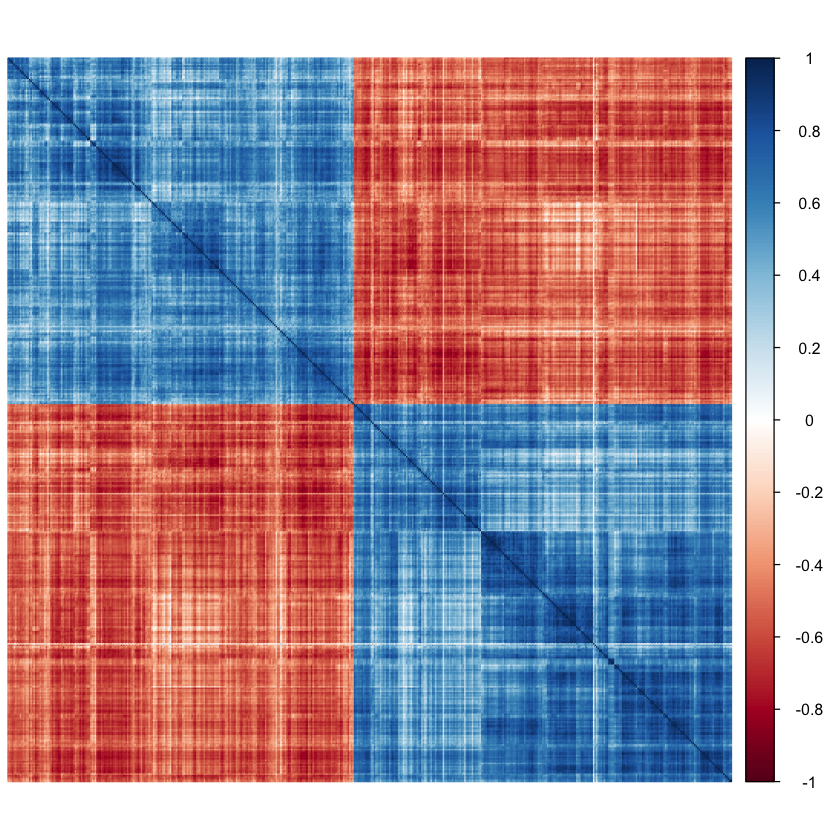

In [58]:
corrplot(cc, method = "color", type = "full", order = "hclust", hclust.method = "ward.D", tl.pos='n')

In [59]:
order_fBraak_index <- order(metadata[Braak_test_index, ]$fBraak)
protein_intens_Braak_order <- protein_intensity_combat[sig_index, ][, Braak_test_index[order_fBraak_index]]

labels <- NULL
color_col <- NULL
stage2roman <- c("0/I", "II", "III", "IV", "V", "VI")
for(i in metadata[Braak_test_index[order_fBraak_index], ]$fBraak){
    labels <- c(labels, stage2roman[i])
    color_col <- c(color_col, i)
}
colnames(protein_intens_Braak_order) <- labels

protein_intens_Braak_order <- t(scale(t(protein_intens_Braak_order), center = TRUE, scale = TRUE))
#protein_intens_Braak_order <- scale(protein_intens_Braak_order, center = TRUE, scale = TRUE)

In [60]:
hc <- hclust(amap:::Dist(protein_intens_Braak_order, 
                         method = "correlation"), method = "ward.D")

In [61]:
hcd = as.dendrogram(hc)
dend_data <- dendro_data(hcd, type = "rectangle")

In [62]:
plot_data <- dend_data$segments[which(dend_data$segments$y>3.8), ]

In [63]:
x_new <- c(1, 1.5, 2, 2.6875, 3, 3.875, 4, 4.75, 5, 5.5, 6)

In [64]:
plot_data$x_new <- sapply(plot_data$x, function(x, order, x_new){
    return(x_new[which(order == x)])
}, sort(unique(c(plot_data$x, plot_data$xend))), x_new)

In [65]:
plot_data$xend_new <- sapply(plot_data$xend, function(x, order, x_new){
    return(x_new[which(order == x)])
}, sort(unique(c(plot_data$x, plot_data$xend))), x_new)

In [66]:
plot_data$y_new <- log2(plot_data$y)
plot_data$yend_new <- log2(plot_data$yend)

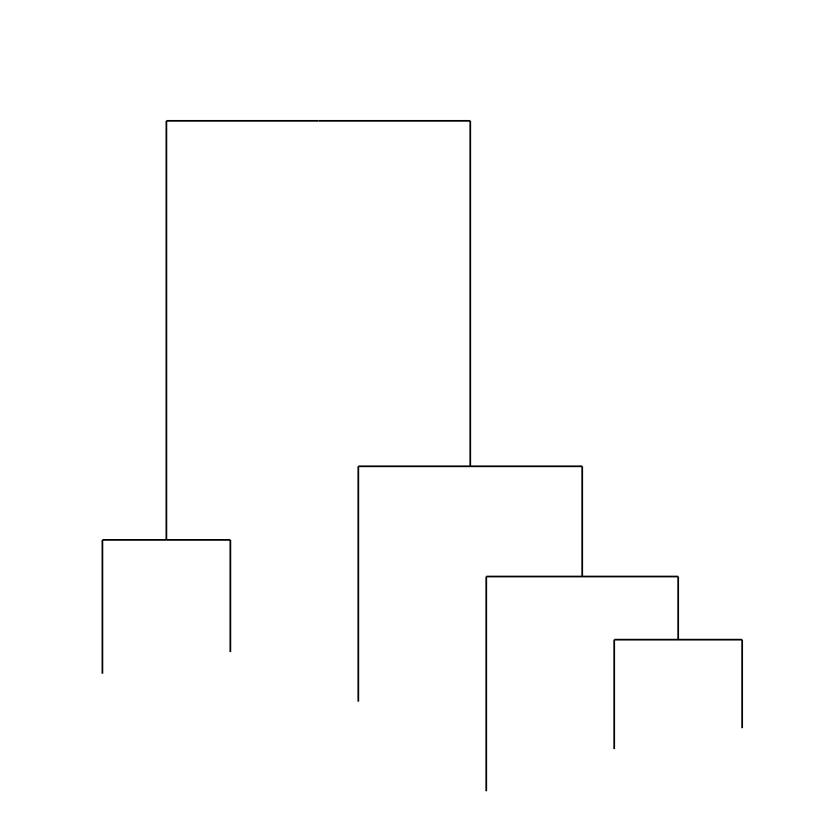

In [67]:
#@png("100_plus_plots/proteomics/celltype_enrich_for_cluster.png", 
#    width = 480*5, height = 100*5, units = "px", pointsize = 50)
p_hc <- ggplot(plot_data) + 
      geom_segment(aes(x = x_new, y = y_new, xend = xend_new, yend = yend_new), size = 0.5) +
      ylim(0.2, 9) + 
      xlim(0.7, 6.3) +
      theme(panel.border = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          
          plot.margin = ggplot2::margin(0, 0.5, -0, 0.5, "cm"),
          
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          axis.text.x = element_blank(),
          axis.text.y = element_blank(),
          axis.ticks.x = element_blank(),
          axis.ticks.y = element_blank(),
          axis.line = element_blank()
          
         )
print(p_hc)
#dev.off()

In [68]:
table(colnames(protein_intens_Braak_order))


0/I  II III  IV   V  VI 
 28  17   8  19  43  25 

In [69]:
idx <- NULL
for(i in c("0/I", "II", "III", "IV", "V", "VI")){
    hc <- hclust(amap:::Dist(t(protein_intens_Braak_order[, which(colnames(protein_intens_Braak_order) == i)]), 
                         method = "euclidean"), method = "complete")
    idx <- c(idx, which(colnames(protein_intens_Braak_order) == i)[hc$order])
}

In [70]:
colnames(protein_intens_Braak_order)[idx]

[1] "0/I" "0/I" "0/I" "0/I" "0/I" "0/I" "0/I" "0/I" "0/I" "0/I" "0/I" "0/I"
 [13] "0/I" "0/I" "0/I" "0/I" "0/I" "0/I" "0/I" "0/I" "0/I" "0/I" "0/I" "0/I"
 [25] "0/I" "0/I" "0/I" "0/I" "II"  "II"  "II"  "II"  "II"  "II"  "II"  "II" 
 [37] "II"  "II"  "II"  "II"  "II"  "II"  "II"  "II"  "II"  "III" "III" "III"
 [49] "III" "III" "III" "III" "III" "IV"  "IV"  "IV"  "IV"  "IV"  "IV"  "IV" 
 [61] "IV"  "IV"  "IV"  "IV"  "IV"  "IV"  "IV"  "IV"  "IV"  "IV"  "IV"  "IV" 
 [73] "V"   "V"   "V"   "V"   "V"   "V"   "V"   "V"   "V"   "V"   "V"   "V"  
 [85] "V"   "V"   "V"   "V"   "V"   "V"   "V"   "V"   "V"   "V"   "V"   "V"  
 [97] "V"   "V"   "V"   "V"   "V"   "V"   "V"   "V"   "V"   "V"   "V"   "V"  
[109] "V"   "V"   "V"   "V"   "V"   "V"   "V"   "VI"  "VI"  "VI"  "VI"  "VI" 
[121] "VI"  "VI"  "VI"  "VI"  "VI"  "VI"  "VI"  "VI"  "VI"  "VI"  "VI"  "VI" 
[133] "VI"  "VI"  "VI"  "VI"  "VI"  "VI"  "VI"  "VI"

In [71]:
Braak_disturb <- table(colnames(protein_intens_Braak_order))

colname <- rep("", ncol(protein_intens_Braak_order))
label_idx <- as.integer(Braak_disturb[1]/2)
colname[label_idx] <- names(Braak_disturb)[1]
for(i in 2:length(Braak_disturb)){
    label_idx <- label_idx - as.integer(Braak_disturb[i-1]/2) + 
                    Braak_disturb[i-1] + as.integer(Braak_disturb[i]/2)
    colname[label_idx] <- names(Braak_disturb)[i]
}

In [72]:
protein_intens_Braak_order <- protein_intens_Braak_order[, idx]
colnames(protein_intens_Braak_order) <- colname

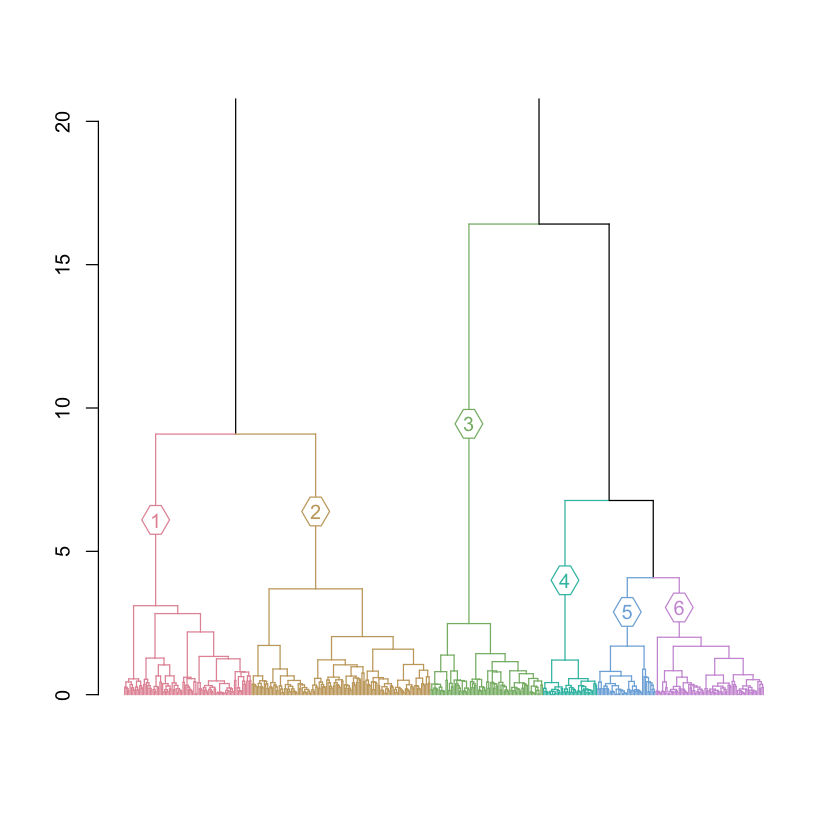

In [73]:
hc <- hclust(amap:::Dist(protein_intens_Braak_order, 
                         method = "correlation"), method = "ward.D")
c_group <- 6 # number of clusters
dend1 <- as.dendrogram(hc)

#protein_clust <- dendextend:::cutree(dend1, k=c_group, order_clusters_as_data = TRUE)
clust <- dendextend:::cutree(dend1, k=c_group, order_clusters_as_data = FALSE)

orig_label <- labels(dend1)

plot_labels <- clust

lbls <- unique(clust)
labels(dend1) <- plot_labels

dend1 <- color_branches(dend1, k = c_group, groupLabels = lbls, col = rainbow_hcl) # add color to the lines
dend1 <- color_labels(dend1, k = c_group, col = rainbow_hcl)   # add color to the labels

# get the color of the leaves (labels) for `heatmap.2`
col_labels <- get_leaves_branches_col(dend1)
col_labels <- col_labels[order(order.dendrogram(dend1))]

plot_labels <- plot_labels[order(order.dendrogram(dend1))]

dend1 <- set(dend1, "labels_cex", 0.8)

#pdf("Temp_results/protein_clustering_dendrogram.pdf")
#par(mar=c(1, 3, 1, 1))
plot(dend1, ylim = c(0, 20), leaflab = "none") # use side = T to horiz mirror if needed
#dev.off()

In [75]:
pdf(file = "100_plus_plots/proteomics/protein cluster heatmap.pdf", width = 7, height = 7)
heatmap.2(protein_intens_Braak_order, 
          # reorderfun=function(d, w) reorder(d, w, agglo.FUN = mean),
                                     # order by branch mean so the deepest color is at the top
          dendrogram = "row",        # no dendrogram for columns
          Rowv = dend1,              # * use self-made dendrogram
          Colv = FALSE,               # make sure the columns follow data's order
          col = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(100), #diverge_hcl,  #       # color pattern of the heatmap
          
          trace="none",              # hide trace
          density.info="none",       # hide histogram
          
          #margins = c(12,8),         # margin on top(bottom) and left(right) side.
          cexRow=1.2, cexCol = 1.5,      # size of row / column labels
          labRow = NA, #labRow = plot_labels,
          xlab = "Braak stage",
          srtCol=0, adjCol = c(0.5,1), # adjust the direction of row label to be horizontal
          # margin for the color key
          # ("bottom.margin", "left.margin", "top.margin", "left.margin" )
          key.par=list(mar=c(3,1,8,2)),
          #lmat=rbind( c(1, 3), c(2,1), c(0,4) ), lhei=c(1.5, 4, 2 ) ,
          RowSideColors = col_labels, # to add nice colored strips        
          colRow = col_labels,         # add color to label
          
          ColSideColors = as.character(color_col), # to add nice colored strips        
          colCol = color_col,         # add color to label
          #colsep=c(28, 45, 53, 72, 115),
          rowsep=c(80, 123, 163, 246, 378),#c(80, 123, 163, 246, 378),
          key.title = NA
          
)
dev.off()

pdf 
  2

In [50]:
map_cluster_to_protein <- function(clust, proteins){
    new_cluster <- as.numeric(lapply(proteins, function(x){return(clust[which(names(clust) == x)])}))
    return(data.frame(protein = proteins,
                      clust = new_cluster))
}

In [51]:
protein_clust <- map_cluster_to_protein(clust, rownames(protein_intensity_combat[sig_index, ]))

In [52]:
protein_clust$gene <- protein_info[sig_index, ]$genes
protein_clust$HUGO_gene <- protein_info[sig_index, ]$HUGO_gene

In [53]:
protein_clust$Log_FC <- pathology_related_proteins_ANOVA[sig_index, ]$effect_size
protein_clust$p.value <- pathology_related_proteins_ANOVA[sig_index, ]$p_value
protein_clust$FDR <- pathology_related_proteins_ANOVA[sig_index, ]$adjusted_p_value

In [54]:
table(protein_clust$clust)


  1   2   3   4   5   6 
 94 132  83  40  43  80 

In [55]:
table(protein_clust$clust)


  1   2   3   4   5   6 
 94 132  83  40  43  80 

In [56]:
protein_clust

protein                     clust gene     HUGO_gene Log_FC    
1   SYT12                       2     SYT12    SYT12     -1.1722376
2   RPH3A                       2     RPH3A    RPH3A     -1.5517087
3   VGF                         2     VGF      VGF       -2.2915211
4   NDUFS3                      1     NDUFS3   NDUFS3    -0.5922395
5   PDK3                        1     PDK3     PDK3      -0.8372619
6   NDUFA12                     1     NDUFA12  NDUFA12   -0.5736917
7   OLFM1                       2     OLFM1    OLFM1     -1.0588640
8   SLC25A11                    1     SLC25A11 SLC25A11  -0.5302484
9   ACTN2;ACTN3                 2     ACTN2    ACTN2     -1.2511038
10  GRIA3                       2     GRIA3    GRIA3     -0.7267890
11  ACTN2                       2     ACTN2    ACTN2     -1.0603616
12  NDUFS8                      1     NDUFS8   NDUFS8    -0.5564002
13  NDUFS1                      1     NDUFS1   NDUFS1    -0.5057053
14  SLC25A4;SLC25A5;SLC25A6     1     SLC25A4  SLC25A4   -0.4952670
15  ACTN1;ACTN2;ACTN3           2     ACTN1    ACTN1     -1.1133978
16  NDUFA13                     1     NDUFA13  NDUFA13   -0.5555184
17  ASAP1                       2     ASAP1    ASAP1     -0.5628350
18  NDUFS2                      1     NDUFS2   NDUFS2    -0.6501410
19  SLC25A6                     2     SLC25A6  SLC25A6   -0.6115355
20  NDUFA5                      1     NDUFA5   NDUFA5    -0.5180016
21  CAP2                        2     CAP2     CAP2      -0.6509210
22  NNT                         1     NNT      NNT       -0.5622233
23  SNAP25                      2     SNAP25   SNAP25    -0.5945437
24  LRPPRC                      1     LRPPRC   LRPPRC    -0.6007439
25  OLFM3                       2     OLFM3    OLFM3     -1.1759390
26  PCYOX1L                     2     PCYOX1L  PCYOX1L   -0.5845207
27  NECTIN1                     2     NECTIN1  NECTIN1   -0.5436744
28  NDUFB3                      1     NDUFB3   NDUFB3    -0.5434625
29  APOO                        1     APOO     APOO      -0.5633045
30  COX4I1                      1     COX4I1   COX4I1    -0.4933457
⋮   ⋮                           ⋮     ⋮        ⋮         ⋮         
443 SOD2                        6     SOD2     SOD2      0.8003905 
444 PPAT                        6     PPAT     PPAT      0.9914474 
445 CRMP1;DPYSL2                5     CRMP1    CRMP1     1.3003272 
446 RAN                         4     RAN      RAN       1.2918484 
447 EIF5B                       5     EIF5B    EIF5B     0.6029607 
448 TXNL1                       4     TXNL1    TXNL1     0.9741784 
449 BOLA2;BOLA2-SMG1P6;BOLA2B   4     BOLA2    BOLA2     1.1108712 
450 GNPDA1;GNPDA2               5     GNPDA1   GNPDA1    1.2448519 
451 FKBP4                       4     FKBP4    FKBP4     0.8955724 
452 DPYSL5                      5     DPYSL5   DPYSL5    1.0452695 
453 CRMP1;DPYS;DPYSL3           5     CRMP1    CRMP1     1.1067990 
454 CRKL                        4     CRKL     CRKL      0.7965889 
455 GSS                         5     GSS      GSS       1.0288129 
456 CRMP1;DPYSL2;DPYSL3         5     CRMP1    CRMP1     1.3219568 
457 GALE                        4     GALE     GALE      0.8166282 
458 NUDT3;RPS10-NUDT3           5     NUDT3    NUDT3     0.6781730 
459 RBMX;RBMXL1                 5     RBMX     RBMX      0.8780186 
460 SYNM                        3     SYNM     SYNM      0.8005805 
461 MAPK15                      5     MAPK15   MAPK15    1.0628927 
462 OLA1                        4     OLA1     OLA1      1.3039926 
463 ENO2                        5     ENO2     ENO2      1.1866651 
464 PCMT1                       6     PCMT1    PCMT1     1.4466806 
465 IQGAP1                      3     IQGAP1   IQGAP1    0.7814270 
466 AKR1C1;AKR1C2;AKR1C3;AKR1C4 3     AKR1C1   AKR1C1    1.1470815 
467 PHYHIPL                     4     PHYHIPL  PHYHIPL   0.8158534 
468 UBFD1                       4     UBFD1    UBFD1     0.6012433 
469 CALB1;CALB2                 6     CALB1    CALB1     1.1

In [1]:
for (i in 1:c_group){
    write.table(protein_clust[protein_clust$clust == i,][, c(1, 3, 4, 5, 6, 7)], 
                file = paste("100_plus_results/Protein_cluster/Braak_protein_cluster_", i, ".tsv", sep = ""), 
                col.names = TRUE, row.names = FALSE, quote = FALSE, sep = "\t")
}

ERROR: Error in eval(expr, envir, enclos): object 'c_group' not found


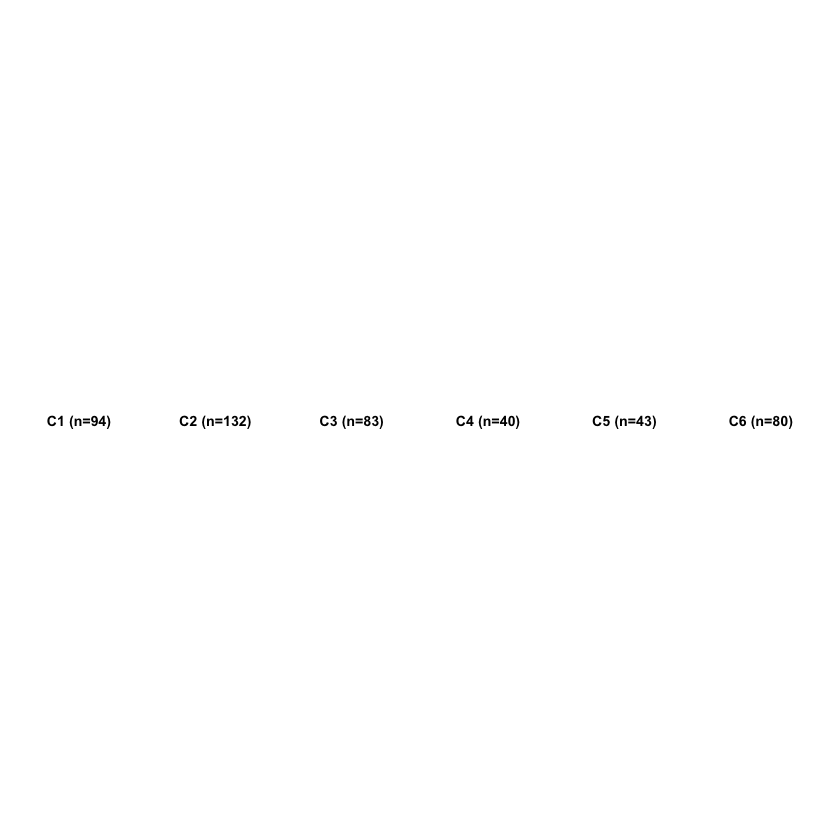

In [92]:
cluster_p_plot <- data.frame(x = seq(1 ,6),
                             label = c(paste("C1 (n=", sum(protein_clust$clust == 1), ")", sep = ""),
                                       paste("C2 (n=", sum(protein_clust$clust == 2), ")", sep = ""), 
                                       paste("C3 (n=", sum(protein_clust$clust == 3), ")", sep = ""), 
                                       paste("C4 (n=", sum(protein_clust$clust == 4), ")", sep = ""), 
                                       paste("C5 (n=", sum(protein_clust$clust == 5), ")", sep = ""), 
                                       paste("C6 (n=", sum(protein_clust$clust == 6), ")", sep = "")),
                             y = rep(1, 6))

p_cluster <- ggplot(aes(x=x, y=y), data=cluster_p_plot) + 
    xlim(0.7, 6.3) +
    annotate("text", x = cluster_p_plot$x, y = cluster_p_plot$y, color="black", fontface='bold',
             size=3, label = cluster_p_plot$label) + 
    theme_void() + 
    theme(plot.margin = ggplot2::margin(0, 0, 0, 0, "cm"))
p_cluster

In [77]:
median_stage_exps_ANOVA <- as.data.frame(t(apply(protein_intensity_combat[sig_index, ][, Braak_test_index], 1, 
                                                 cal_median_for_stage, metadata[Braak_test_index, ]$fBraak)))

colnames(median_stage_exps_ANOVA) <- c("I", "II", "III", "IV", "V", "VI")

#median_stage_exps_ANOVA <- scale(median_stage_exps_ANOVA, center = TRUE, scale = TRUE)
median_stage_exps_ANOVA <- t(scale(t(median_stage_exps_ANOVA), center = TRUE, scale = FALSE))

cluster_trend_plots <- list()
j <- 1

breaks = c(0.125, 0.25, 0.5, 0.75, 0.875)
#breaks = c(0, 0.25, 0.5, 0.75, 1)
cluster_trend <- as.data.frame(t(apply(median_stage_exps_ANOVA[protein_clust$clust == 1, ], 2, 
                                       quantile, probs = breaks, type = 4)))

cluster_trend <- cbind(seq(1,6), cluster_trend)
colnames(cluster_trend) <- c("Braak", paste("CI_", seq(from = 0, to = 1, by = 0.25), sep = ""))

xlabels <- seq(from = 1, to = 6, by = 1)
p_trend <- ggplot(cluster_trend, aes(x = Braak)) +
    geom_ribbon(aes(ymin=CI_0,ymax=CI_1), fill="black", alpha=0.1) +
    geom_ribbon(aes(ymin=CI_0.25,ymax=CI_0.75), fill="black", alpha=0.4) +
    
    geom_line(aes(y=CI_0.5), col="black", alpha=1, size = 0.5) +
    geom_line(aes(y=CI_0), col="black", alpha=0.5, size = 0.5) +
    geom_line(aes(y=CI_1), col="black", alpha=0.5, size = 0.5) +  
    #geom_line(aes(y=CI_0.25), col=color_ND, alpha=0.2, size = 0.5, linetype = "dashed") +
    #geom_line(aes(y=CI_0.75), col=color_ND, alpha=0.2, size = 0.5, linetype = "dashed") +  

    #coord_fixed(ratio=100) + 
    ggtitle(paste("Cluster", 1, sep = " ")) +
    xlab("Braak stage") +
    ylab("Protein intensity (Log2)") +
    scale_x_continuous(breaks=seq(1,6,1), labels = c("0/I", "II", "III", "IV", "V", "VI")) +
    scale_y_continuous(limits = c(-1.25, 1.5), breaks=seq(-1, 1.5, 0.5)) +
    
    #geom_hline(yintercept = 0.5, linetype = "solid", color = "black", size = 0.5) +

    theme(#plot.background = element_rect(),    # Background of the entire plot
          panel.background = element_rect(fill = "white"),   # Background of plotting area
          #panel.border = element_rect(),       # Border around plotting area.
                                               # fill argument should be NA
  
          panel.grid = element_line(),         # All grid lines
          #panel.grid.major = element_line(),   # Major grid lines
          #panel.grid.minor = element_line(),   # Minor grid lines
  
          #panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
          #                      color = "gray"), # Vertical major grid lines
          #panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
          #                      color = "gray"), # Horizontal major grid lines
          #panel.grid.minor.x = element_line(), # Vertical minor grid lines
          #panel.grid.minor.y = element_line(),  # Vertical major grid lines
        
          plot.margin = ggplot2::margin(0, 0.22, 0, -0.45, "cm"),
        
          plot.title = element_blank(),
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          
          axis.text.x = element_text(color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(color = "black"),
          
          axis.line = element_line(size = 0.4, linetype = "solid",
                                   colour = "black")
         )

cluster_trend_plots[[j]] <- p_trend
j = j +1
add_marg <- 0.03

for(i in 2:c_group){

cluster_trend <- as.data.frame(t(apply(median_stage_exps_ANOVA[protein_clust$clust == i, ], 2, 
                                       quantile, probs = breaks, type = 4)))

cluster_trend <- cbind(seq(1,6), cluster_trend)
colnames(cluster_trend) <- c("Braak", paste("CI_", seq(from = 0, to = 1, by = 0.25), sep = ""))

xlabels <- seq(from = 1, to = 6, by = 1)
p_trend <- ggplot(cluster_trend, aes(x = Braak)) +
    geom_ribbon(aes(ymin=CI_0,ymax=CI_1), fill="black", alpha=0.1) +
    geom_ribbon(aes(ymin=CI_0.25,ymax=CI_0.75), fill="black", alpha=0.4) +
    
    geom_line(aes(y=CI_0.5), col="black", alpha=1, size = 0.5) +
    geom_line(aes(y=CI_0), col="black", alpha=0.5, size = 0.5) +
    geom_line(aes(y=CI_1), col="black", alpha=0.5, size = 0.5) +  
    #geom_line(aes(y=CI_0.25), col=color_ND, alpha=0.2, size = 0.5, linetype = "dashed") +
    #geom_line(aes(y=CI_0.75), col=color_ND, alpha=0.2, size = 0.5, linetype = "dashed") +  

    #coord_fixed(ratio=100) + 
    ggtitle(paste("Cluster", i, sep = " ")) +
    xlab("Braak stage") +
    ylab("Protein intensity (Log2)") +
    scale_x_continuous(breaks=seq(1,6,1), labels = c("0/I", "II", "III", "IV", "V", "VI")) +
    scale_y_continuous(limits = c(-1.25, 1.5), breaks=seq(-1.25, 1.5, 0.25)) +
    
    #geom_hline(yintercept = 0.5, linetype = "solid", color = "black", size = 0.5) +

    theme(#plot.background = element_rect(),    # Background of the entire plot
          panel.background = element_rect(fill = "white"),   # Background of plotting area
          #panel.border = element_rect(),       # Border around plotting area.
                                               # fill argument should be NA
  
          panel.grid = element_line(),         # All grid lines
          #panel.grid.major = element_line(),   # Major grid lines
          #panel.grid.minor = element_line(),   # Minor grid lines
  
          #panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
          #                      color = "gray"), # Vertical major grid lines
          #panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
          #                      color = "gray"), # Horizontal major grid lines
          #panel.grid.minor.x = element_line(), # Vertical minor grid lines
          #panel.grid.minor.y = element_line(),  # Vertical major grid lines
        
          plot.margin = ggplot2::margin(0, (0.24+add_marg*(i-1)), 0, -(0.12+add_marg*(i-1)), "cm"),
        
          plot.title = element_blank(),
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          
          axis.text.x = element_text(color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
        
          axis.line = element_line(size = 0.4, linetype = "solid",
                                   colour = "black")
         )

cluster_trend_plots[[j]] <- p_trend
j = j +1
}

p_trend <- plot_grid(plotlist = cluster_trend_plots, ncol = 6, nrow = 1, 
                     rel_widths = c(1, rep(0.9 ,5)),
                     align = "h", axis = "tblr")

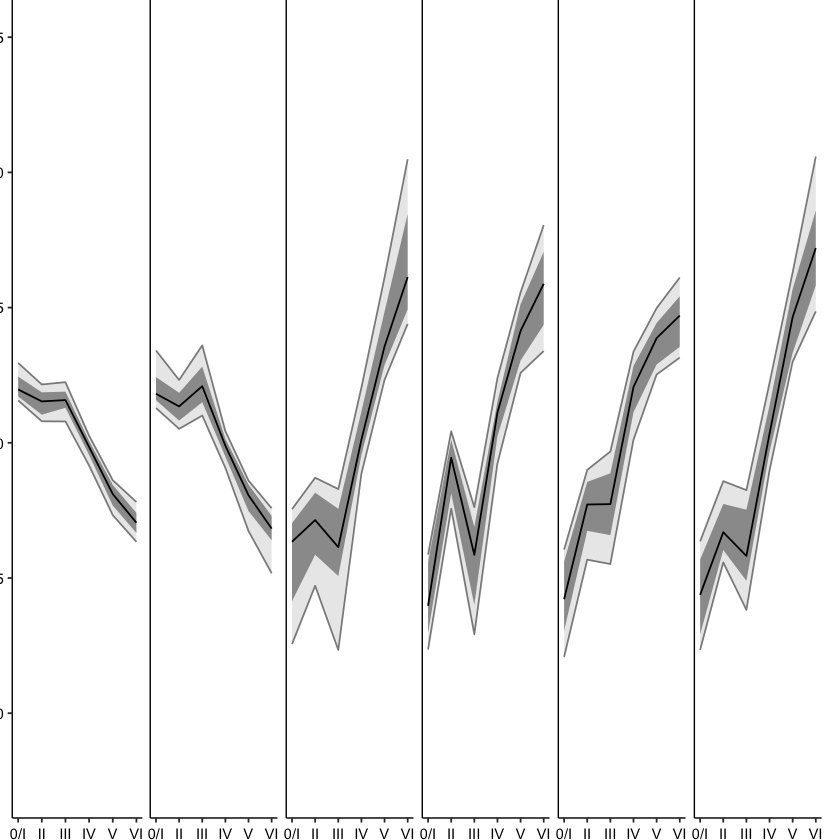

In [78]:
p_trend

In [60]:
Astrocytes = "#FEB24C"
Endothelial = "#88419D"
Microglia = "#9ECAE1"
ExNeurons = "#ADDD8E"
InNeurons = "#339900"
OPC = "#A50F15"
Oligodendrocytes = "#DD3497"
Unknown = "#008080"
No_unique_enrichment = "#969696"
NS_DEPs = "gray88"

In [90]:
cell_type_matrix_new <- protein_info
cell_type_matrix_new$celltype <- as.character(cell_type_matrix_new$celltype)
cell_type_matrix_new[which(is.na(cell_type_matrix_new$celltype)), ]$celltype <- "no"
cell_type_matrix_new[which(cell_type_matrix_new$celltype == "Unknown"), ]$celltype <- "no"
cell_type_matrix_new$celltype <- factor(cell_type_matrix_new$celltype, 
                                        levels = c("no", "Astrocytes", "Endothelial", "ExNeurons", "InNeurons", 
                                            "Microglia", "Oligodendrocytes", "OPC"#, "Unknown"
                                                  ))

In [91]:
table(cell_type_matrix_new$celltype)


              no       Astrocytes      Endothelial        ExNeurons 
            3147               68                6               77 
       InNeurons        Microglia Oligodendrocytes              OPC 
              23               34               75               18 

In [92]:
dim(cell_type_matrix_new)

[1] 3448    4

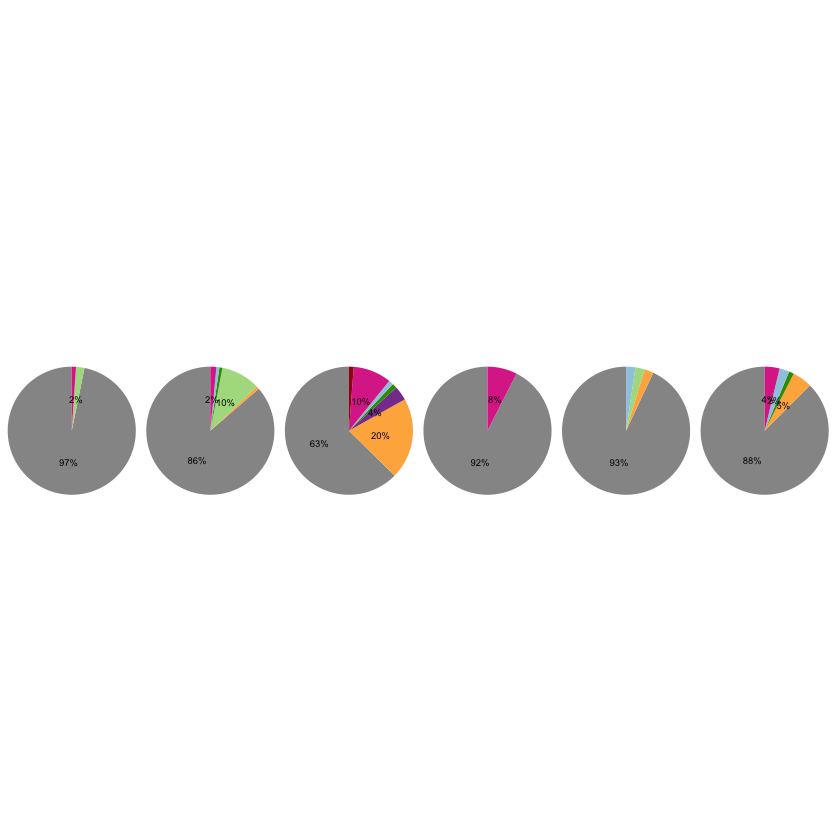

In [93]:
generate_pie_chart <- function(clust_n){
    pie_data <- as.data.frame(table(cell_type_matrix_new[sig_index[protein_clust$clust == clust_n], ]$celltype))
    
    blank_theme <- theme_minimal()+
        theme(
            axis.title.x = element_blank(),
            axis.title.y = element_blank(),
            panel.border = element_blank(),
            panel.grid=element_blank(),
            axis.ticks = element_blank(),
            plot.title=element_text(size=14, face="bold")
        )

    p <- ggplot(pie_data, aes(x="", y=Freq, fill=Var1))+
        geom_bar(width = 1, stat = "identity") +
        coord_polar("y", start=0) +
        scale_fill_manual(name="Cell type", breaks = c("no", "Astrocytes", "Endothelial", 
                                                       "ExNeurons", "InNeurons", 
                                                       "Microglia", "Oligodendrocytes", "OPC", "Unknown"),
                          values = c(No_unique_enrichment,
                                     Astrocytes,
                                     Endothelial,
                                     ExNeurons,
                                     InNeurons,
                                     Microglia,
                                     Oligodendrocytes,
                                     OPC,
                                     Unknown)) +
        blank_theme +
        theme(axis.text.x=element_blank(), 
              legend.position="none",
              plot.margin = ggplot2::margin(-0.25, -0.25 + add_marg*(i-1), -0.8, -0.35-add_marg*(i-1), "cm")) +
        geom_text(aes(label = ifelse(Freq < 2, "", paste0(round(Freq/sum(Freq)*100), "%"))), 
                  position = position_stack(vjust = 0.5), size = 2)
    #print(p)
    return(p)
    
}



pie_charts <- NULL
for(i in 1:c_group){
    pie_charts[[i]] <- generate_pie_chart(i)
}

p_pie <- plot_grid(plotlist = pie_charts, ncol = 6, nrow = 1, 
                     rel_widths = c(rep(1/6,6)),
                     align = "h", axis = "tblr")
p_pie

In [61]:
EWCE_res_matrix <- NULL
for(i in 1:6){
    temp_EWCE <- read.table(paste("100_plus_results/Cell_type_deconvolution/EWCE_tempcort_ProtCluster", i, 
                                  "_BasedonDarm&Hodge.csv", sep = ''),
                            header =TRUE, stringsAsFactors=F, sep = ",")
    temp_EWCE$adj.p <- temp_EWCE$p#p.adjust(temp_EWCE$p, method = "BH")
    #temp_EWCE$adj.p <- temp_EWCE$p
    temp_EWCE$cluster <- paste("cluster", i, sep = '_')
    EWCE_res_matrix <- rbind(EWCE_res_matrix, temp_EWCE)
}
#EWCE_res_matrix

In [62]:
fisher_p_plot <- EWCE_res_matrix[,c("p", "sd_from_mean", "CellType", "cluster", "adj.p")]
colnames(fisher_p_plot) <- c("value", "estimate", "celltype", "cluster", "adj.pvalue")
#fisher_p_plot$adj.pvalue <- p.adjust(fisher_p_plot$value, method = "BH")
#fisher_p_plot$log_p <- -log10(fisher_p_plot$adj.pvalue)

fisher_p_plot$stars <- cut(fisher_p_plot$adj.pvalue, 
                           breaks=c(-Inf, 0.001, 0.01, 0.05, Inf), 
                           label=c("***", "**", "*", ""))

fisher_p_plot$text_p <- fisher_p_plot$adj.pvalue
fisher_p_plot[which(fisher_p_plot$adj.pvalue >= 0.05), ]$text_p <- NA

changeSciNot <- function(n) {
  output <- formatC(n, format = "e", digits = 2) #Transforms the number into scientific notation even if small
  output <- sub("e", "x10^", output) #Replace e with 10^
  output <- sub("\\+0?", "", output) #Remove + symbol and leading zeros on expoent, if > 1
  output <- sub("-0?", "-", output) #Leaves - symbol but removes leading zeros on expoent, if < 1
  output
}

fisher_p_plot$text_p <- as.character(lapply(fisher_p_plot$text_p, changeSciNot))

fisher_p_plot[which(fisher_p_plot$text_p == ' NA'), ]$text_p <- ""

fisher_p_plot[which(fisher_p_plot$estimate < 0), ]$estimate <- 0
fisher_p_plot <- subset(fisher_p_plot, celltype != "Unknown")

In [63]:
#fisher_p_plot

In [64]:
fisher_p_plot$celltype <- factor(fisher_p_plot$celltype, 
                                 levels = rev(c("Astrocytes", "Endothelial", "ExNeurons", "InNeurons", 
                                            "Microglia", "Oligodendrocytes", "OPC", "Unknown")))

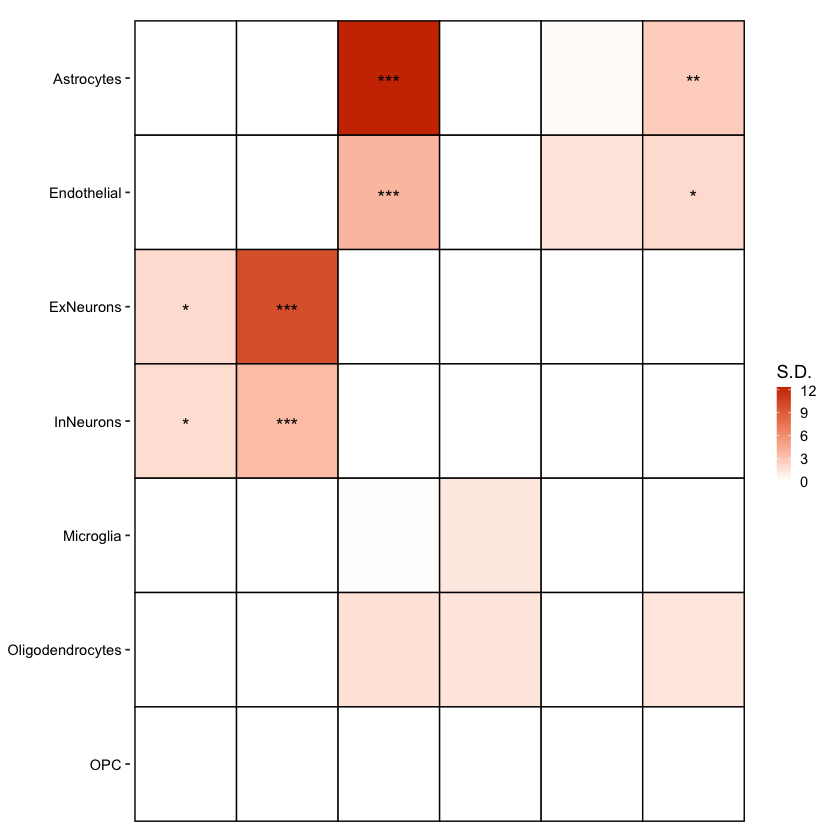

In [65]:
p_celltype <- ggplot(aes(x=cluster, y=celltype, fill=estimate), data=fisher_p_plot)+
    geom_tile(colour = "black", size = 0.4) + 
    scale_fill_gradient2(name = "S.D.", midpoint = 0, 
                        low = "steelblue3", mid="white", high = "orangered3") + 
    geom_text(aes(label=stars), color="black", size=4, vjust = 0.8) + 

    scale_x_discrete(expand = c(0.06, 0.25), breaks=paste("cluster_", seq(1, 6, 1), sep =""), 
                     labels = c("C1", "C2", "C3", "C4", "C5", "C6")) +

    scale_y_discrete(breaks = rev(c("Astrocytes", "Endothelial", "ExNeurons", "InNeurons", 
                                "Microglia", "Oligodendrocytes", "OPC", "Unknown")),
                     labels = rev(c("Astrocytes", "Endothelial", "ExNeurons", "InNeurons", 
                                "Microglia", "Oligodendrocytes", "OPC", "Unknown"))) +

    #guides(fill = guide_legend(title.position = "right")) +
    xlab("") +
    ylab("") +

    theme(panel.border = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          
          
          plot.margin = ggplot2::margin(0.2, 0.3, -0.4, -0.3, "cm"),
          legend.title = element_text(colour = "black", angle = 0, hjust = 0, vjust = 0),
          legend.text = element_text(color = "black"),
          
          legend.key = element_rect(size = 6),
          legend.key.height = unit(0.4, "cm"),
          legend.key.width = unit(0.3, "cm"),
          #legend.key.size = unit(1, "cm"),
          
          axis.title.x = element_text(color = "black"),
          
          axis.title.y = element_text(color = "black"),
          
          
          axis.text.y = element_text(color = "black"),
          
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          
          legend.position="right",
          legend.direction='vertical',
          
          #axis.line = element_line(size = 0.5, linetype = "solid",
          #                         colour = "grey")
          
          axis.line = element_blank()
          
         )
p_celltype

In [66]:
legend <- ggplot(cell_type_matrix_new, aes(x=celltype, fill=celltype))+
        geom_histogram(stat="count") +
        scale_fill_manual(name="", 
                          values = c(Astrocytes,
                                     Endothelial,
                                     ExNeurons,
                                     InNeurons,
                                     Microglia,
                                     OPC,
                                     Oligodendrocytes,
                                     #Unknown,
                                     No_unique_enrichment),
                          breaks = c("Astrocytes", "Endothelial", "ExNeurons", "InNeurons", 
                                "Microglia", "OPC", "Oligodendrocytes", #"Unknown", 
                                     "no"),
                          
                          labels = c("Astrocytes", "Endothelial", "ExNeurons", "InNeurons", 
                                "Microglia", "OPC", "Oligodendrocytes", #"Unknown", 
                                     "Not Marker")
                          ) +
        guides(fill=guide_legend(nrow=1)) +
        theme(
            legend.margin=ggplot2::margin(t = -0.5, unit='cm'),
            legend.key = element_rect(size = 6),
            legend.key.height = unit(0.4, "cm"),
            legend.key.width = unit(0.4, "cm"),
            #legend.position="bottom"
            #legend.box = "horizontal"
            
        )
legend

ERROR: Error in ggplot(cell_type_matrix_new, aes(x = celltype, fill = celltype)): object 'cell_type_matrix_new' not found


In [105]:
p_legend <- get_legend(legend)

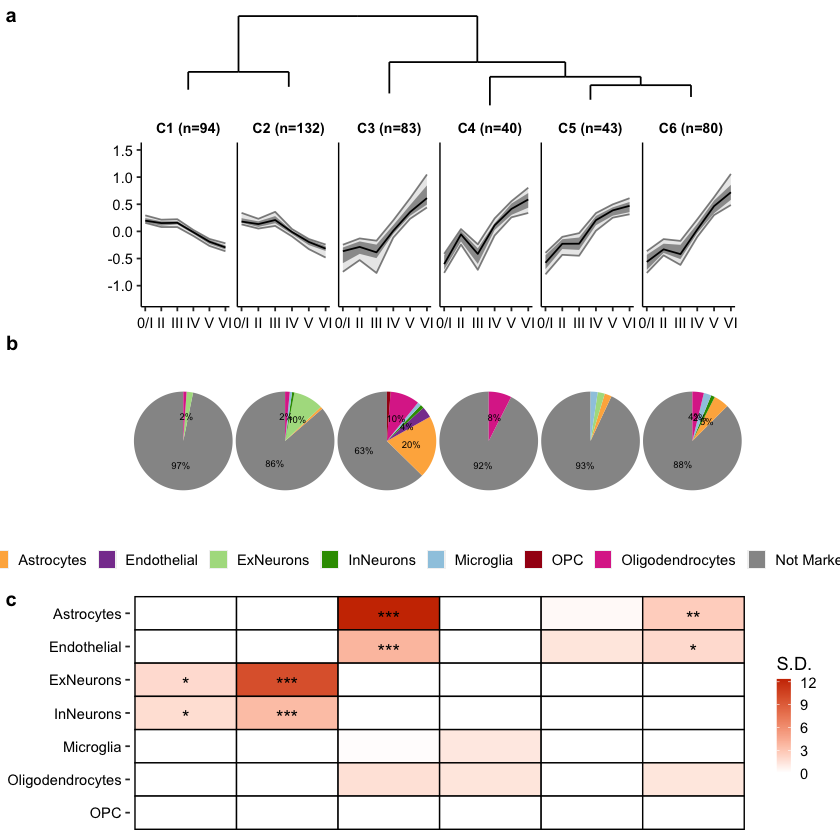

In [106]:
Enrich_plot <- plot_grid(p_hc, p_cluster, p_trend, p_pie, p_legend, p_celltype, 
                         rel_heights = c(0.09, 0.05, 0.18, 0.2, 0.05, 0.25), 
                         scale = c(1, 1, 1.01, 1, 1, 1), labels = c("a", "", "", "b", "", "c"),label_size=12,
                         align = "v", axis = "lr", nrow = 6, ncol = 1)

Enrich_plot

In [107]:
save_plot("100_plus_plots/proteomics/Braak_protein_Enrichment_analysis_EWCE_plot-20220715.jpg", 
          Enrich_plot, base_height = 5, base_width = 9)

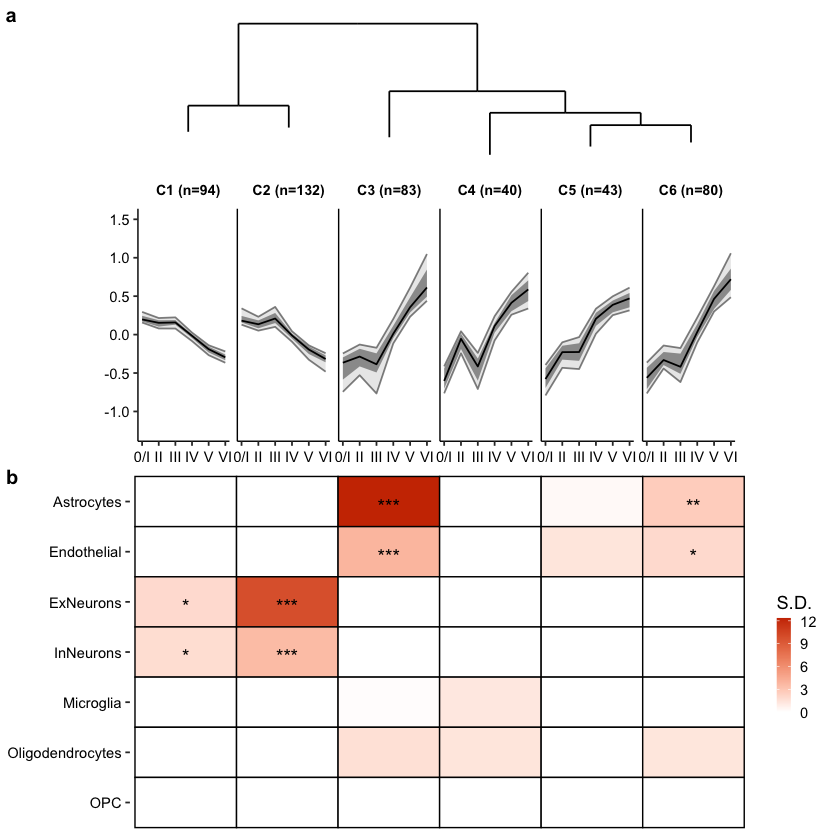

In [105]:
Enrich_plot <- plot_grid(p_hc, p_cluster, p_trend, p_celltype, 
                         rel_heights = c(0.2, 0.05, 0.3, 0.45), 
                         scale = c(1, 1, 1.01, 1), labels = c("a", "", "", "b"),
                         label_size=12,#vjust = 0,
                         align = "v", axis = "lr", nrow = 4, ncol = 1)

Enrich_plot

In [106]:
save_plot("100_plus_plots/proteomics/B-proteins_cluster_trend_EWCE_enrich_plot-20220905.pdf", 
          Enrich_plot, base_height = 4, base_width = 9)

In [ ]:
## test of cluster 2 and 3

In [60]:
protein_clust[protein_clust$clust == 2, ][, c(1, 2)]

write.table(protein_clust[protein_clust$clust == 2, ][, c(1, 2)], 
            file = paste("100_plus_results/GOterm_orig_union_ward_7c_BH/proteins_in_cluster2.txt"),
            row.names = FALSE, quote = FALSE, sep = "\t")

write.table(protein_clust[protein_clust$clust == 3, ][, c(1, 2)], 
            file = paste("100_plus_results/GOterm_orig_union_ward_7c_BH/proteins_in_cluster3.txt"),
            row.names = FALSE, quote = FALSE, sep = "\t")

clust[clust == 3]

protein              clust
1   SYT12                2    
2   RPH3A                2    
3   VGF                  2    
7   OLFM1                2    
10  GRIA3                2    
15  ACTN1;ACTN2;ACTN3    2    
17  ASAP1                2    
19  SLC25A6              2    
21  CAP2                 2    
23  SNAP25               2    
25  OLFM3                2    
26  PCYOX1L              2    
27  NECTIN1              2    
31  MARK1                2    
35  TRIM36               2    
36  CASKIN1              2    
45  LPCAT4               2    
47  SLC25A46             2    
51  FAM210A              2    
54  ARHGAP26             2    
56  STX17                2    
58  SLC4A10              2    
64  PHACTR1              2    
65  IGSF9B               2    
69  IRGQ                 2    
72  PLXNA1;PLXNA2;PLXNA4 2    
74  SLC25A22             2    
81  KIAA1549L            2    
83  STX1A                2    
90  ADGRB2               2    
... ...                  ...  
163 HIGD1A               2    
165 GABRA1               2    
166 AGO2;AGO3            2    
168 TCP11L1              2    
169 PALM2;PALM2-AKAP2    2    
170 PEX5L                2    
173 PDHX                 2    
177 SLC25A18;SLC25A22    2    
178 NDUFA6               2    
180 PLCL2                2    
183 SLC2A14;SLC2A3       2    
186 FSD1                 2    
189 BRSK1;BRSK2          2    
193 BRSK2                2    
195 ARHGEF11             2    
198 KIAA1586             2    
199 SNX30                2    
200 SPG7                 2    
201 TM7SF2               2    
202 SCN2A;SCN9A          2    
210 MCU                  2    
211 PLXNA2;PLXNA4        2    
212 LINGO1               2    
213 TOMM20               2    
214 SCN2A                2    
216 HCN2                 2    
217 KALRN;TRIO           2    
218 REEP2                2    
223 CYB5R1               2    
224 PRRT3                2

In [69]:
ont_BP_perclust <- list()

In [70]:
for (i in 1:c_group){
    cat("This is cluster", i, sep = "", end = ".\n")
    cat("The number of protein in this cluster is", length(which(protein_clust$clust == i)), sep = " ", end = ".\n")
    protein_list <- unique(protein_clust[protein_clust$clust == i,]$gene)
    print(length(protein_list))
    if(length(protein_list) < 1){
        cat("The number of valide protein in this cluster is", length(protein_list), sep = " ", end = ".\n")
        next
    }
    geneList <- factor(as.integer(backgroud_protein_list %in% protein_list))
    names(geneList) <- backgroud_protein_list
    
    allRes <- GOterm_query_test_table(protein_list, geneList, "BP")
    
    if(class(allRes) == 'character')
        print(allRes)
    else{
        ont_BP_perclust[[i]] <- allRes
        write.table(allRes, 
                    file = paste("100_plus_results/GOterm_orig_union_ward_6c_BH/GOterm_BP_for_", "Cluster_", i, ".txt", sep = ""),
                    row.names = FALSE, quote = FALSE, sep = "\t")
    }
}

This is cluster1.
The number of protein in this cluster is 81 .
[1] 78



Building most specific GOs .....
	( 6550 GO terms found. )

Build GO DAG topology ..........
	( 10581 GO terms and 24692 relations. )

Annotating nodes ...............
	( 3044 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1409 nontrivial nodes
		 parameters: 
			 test statistic: fisher
Warning message in p.adjust(p = allRes[, "Fisher"], method = "BH"):
“NAs introduced by coercion”

This is cluster2.
The number of protein in this cluster is 149 .
[1] 138



Building most specific GOs .....
	( 6550 GO terms found. )

Build GO DAG topology ..........
	( 10581 GO terms and 24692 relations. )

Annotating nodes ...............
	( 3044 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 2369 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster3.
The number of protein in this cluster is 83 .
[1] 83



Building most specific GOs .....
	( 6550 GO terms found. )

Build GO DAG topology ..........
	( 10581 GO terms and 24692 relations. )

Annotating nodes ...............
	( 3044 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 2518 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster4.
The number of protein in this cluster is 42 .
[1] 41



Building most specific GOs .....
	( 6550 GO terms found. )

Build GO DAG topology ..........
	( 10581 GO terms and 24692 relations. )

Annotating nodes ...............
	( 3044 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1438 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "Can not find significant GO pathway in this cluster!"
This is cluster5.
The number of protein in this cluster is 49 .
[1] 46



Building most specific GOs .....
	( 6550 GO terms found. )

Build GO DAG topology ..........
	( 10581 GO terms and 24692 relations. )

Annotating nodes ...............
	( 3044 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1654 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster6.
The number of protein in this cluster is 80 .
[1] 73



Building most specific GOs .....
	( 6550 GO terms found. )

Build GO DAG topology ..........
	( 10581 GO terms and 24692 relations. )

Annotating nodes ...............
	( 3044 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 2109 nontrivial nodes
		 parameters: 
			 test statistic: fisher


In [35]:
ont_BP_perclust

[[1]]
        GO.ID                                        Term Annotated Significant
8  GO:0045333                        cellular respiration       115          34
9  GO:0033108 mitochondrial respiratory chain complex ...        48          25
10 GO:0022900                    electron transport chain       102          32
11 GO:0015980 energy derivation by oxidation of organi...       137          34
12 GO:0046034                       ATP metabolic process       139          34
13 GO:0009205 purine ribonucleoside triphosphate metab...       148          34
14 GO:0009144 purine nucleoside triphosphate metabolic...       150          34
15 GO:0009199 ribonucleoside triphosphate metabolic pr...       150          34
16 GO:0006091 generation of precursor metabolites and ...       221          39
17 GO:0009150     purine ribonucleotide metabolic process       221          39
18 GO:0009259            ribonucleotide metabolic process       226          39
19 GO:0009141 nucleoside triphosphate metabolic proces...       155          34
20 GO:0006163         purine nucleotide metabolic process       232          39
21 GO:0009126 purine nucleoside monophosphate metaboli...       160          34
22 GO:0009167 purine ribonucleoside monophosphate meta...       160          34
23 GO:0019693          ribose phosphate metabolic process       236          39
24 GO:0072521 purine-containing compound metabolic pro...       240          39
25 GO:0009161 ribonucleoside monophosphate metabolic p...       165          34
26 GO:0009123 nucleoside monophosphate metabolic proce...       167          34
27 GO:0009117                nucleotide metabolic process       269          40
28 GO:0006753      nucleoside phosphate metabolic process       271          40
29 GO:0055086 nucleobase-containing small molecule met...       294          40
30 GO:0007005                  mitochondrion organization       218          34
31 GO:0017144                      drug metabolic process       290          38
32 GO:0019637           organophosphate metabolic process       400          43
33 GO:1901135 carbohydrate derivative metabolic proces...       340          40
34 GO:0055114                 oxidation-reduction process       339          37
35 GO:0044281            small molecule metabolic process       658          47
36 GO:1902600              proton transmembrane transport        56          15
37 GO:0009060                         aerobic respiration        57          14
38 GO:0016310                             phosphorylation       610          40
39 GO:0006796 phosphate-containing compound metabolic ...       861          46
40 GO:0006793                phosphorus metabolic process       868          46
41 GO:0034622 cellular protein-containing complex asse...       388          30
42 GO:0015672       monovalent inorganic cation transport       135          18
43 GO:0055085                     transmembrane transport       412          30
44 GO:0006811                               ion transport       415          29
45 GO:0034220                 ion transmembrane transport       292          24
46 GO:0098660       inorganic ion transmembrane transport       228          21
47 GO:0006139 nucleobase-containing compound metabolic...       951          45
48 GO:0006123 mitochondrial electron transport, cytoch...        12           6
49 GO:0019646            aerobic electron transport chain        12           6
50 GO:0098662    inorganic cation transmembrane transport       210          19
51 GO:0046483               heterocycle metabolic process       985          45
52 GO:0006725 cellular aromatic compound metabolic pro...       999          45
53 GO:1901360 organic cyclic compound metabolic proces...      1037          46
54 GO:0006812                            cation transport       302          22
55 GO:0098655              cation transmembrane transport       237          19
56 GO:0065003         protein-containing complex assembly       556       

In [71]:
ont_MF_perclust <- list()

for (i in 1:c_group){
    cat("This is cluster", i, sep = "", end = ".\n")
    cat("The number of protein in this cluster is", length(which(protein_clust$clust == i)), sep = " ", end = ".\n")
    protein_list <- unique(protein_clust[protein_clust$clust == i,]$gene)
    print(length(protein_list))
    if(length(protein_list) < 1){
        cat("The number of valide protein in this cluster is", length(protein_list), sep = " ", end = ".\n")
        next
    }
    geneList <- factor(as.integer(backgroud_protein_list %in% protein_list))
    names(geneList) <- backgroud_protein_list
    
    allRes <- GOterm_query_test_table(protein_list, geneList, "MF")
    
    if(class(allRes) == 'character')
        print(allRes)
    else{
        ont_MF_perclust[[i]] <- allRes
        write.table(allRes, 
                    file = paste("100_plus_results/GOterm_orig_union_ward_6c_BH/GOterm_MF_for_", "Cluster_", i, ".txt", sep = ""),
                    row.names = FALSE, quote = FALSE, sep = "\t")
    }
}

This is cluster1.
The number of protein in this cluster is 81 .
[1] 78



Building most specific GOs .....
	( 2046 GO terms found. )

Build GO DAG topology ..........
	( 2544 GO terms and 3303 relations. )

Annotating nodes ...............
	( 3026 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 271 nontrivial nodes
		 parameters: 
			 test statistic: fisher
Warning message in p.adjust(p = allRes[, "Fisher"], method = "BH"):
“NAs introduced by coercion”

This is cluster2.
The number of protein in this cluster is 149 .
[1] 138



Building most specific GOs .....
	( 2046 GO terms found. )

Build GO DAG topology ..........
	( 2544 GO terms and 3303 relations. )

Annotating nodes ...............
	( 3026 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 407 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster3.
The number of protein in this cluster is 83 .
[1] 83



Building most specific GOs .....
	( 2046 GO terms found. )

Build GO DAG topology ..........
	( 2544 GO terms and 3303 relations. )

Annotating nodes ...............
	( 3026 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 298 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "Can not find significant GO pathway in this cluster!"
This is cluster4.
The number of protein in this cluster is 42 .
[1] 41



Building most specific GOs .....
	( 2046 GO terms found. )

Build GO DAG topology ..........
	( 2544 GO terms and 3303 relations. )

Annotating nodes ...............
	( 3026 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 186 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "Can not find significant GO pathway in this cluster!"
This is cluster5.
The number of protein in this cluster is 49 .
[1] 46



Building most specific GOs .....
	( 2046 GO terms found. )

Build GO DAG topology ..........
	( 2544 GO terms and 3303 relations. )

Annotating nodes ...............
	( 3026 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 236 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster6.
The number of protein in this cluster is 80 .
[1] 73



Building most specific GOs .....
	( 2046 GO terms found. )

Build GO DAG topology ..........
	( 2544 GO terms and 3303 relations. )

Annotating nodes ...............
	( 3026 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 237 nontrivial nodes
		 parameters: 
			 test statistic: fisher


In [72]:
ont_CC_perclust <- list()

for (i in 1:c_group){
    cat("This is cluster", i, sep = "", end = ".\n")
    cat("The number of protein in this cluster is", length(which(protein_clust$clust == i)), sep = " ", end = ".\n")
    protein_list <- unique(protein_clust[protein_clust$clust == i,]$gene)
    print(length(protein_list))
    if(length(protein_list) < 1){
        cat("The number of valide protein in this cluster is", length(protein_list), sep = " ", end = ".\n")
        next
    }
    geneList <- factor(as.integer(backgroud_protein_list %in% protein_list))
    names(geneList) <- backgroud_protein_list
    
    allRes <- GOterm_query_test_table(protein_list, geneList, "CC")
    
    if(class(allRes) == 'character')
        print(allRes)
    else{
        ont_CC_perclust[[i]] <- allRes
        write.table(allRes, 
                    file = paste("100_plus_results/GOterm_orig_union_ward_6c_BH/GOterm_CC_for_", "Cluster_", i, ".txt", sep = ""),
                    row.names = FALSE, quote = FALSE, sep = "\t")
    }
}

This is cluster1.
The number of protein in this cluster is 81 .
[1] 78



Building most specific GOs .....
	( 1132 GO terms found. )

Build GO DAG topology ..........
	( 1425 GO terms and 2732 relations. )

Annotating nodes ...............
	( 3098 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 312 nontrivial nodes
		 parameters: 
			 test statistic: fisher
Warning message in p.adjust(p = allRes[, "Fisher"], method = "BH"):
“NAs introduced by coercion”

This is cluster2.
The number of protein in this cluster is 149 .
[1] 138



Building most specific GOs .....
	( 1132 GO terms found. )

Build GO DAG topology ..........
	( 1425 GO terms and 2732 relations. )

Annotating nodes ...............
	( 3098 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 421 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster3.
The number of protein in this cluster is 83 .
[1] 83



Building most specific GOs .....
	( 1132 GO terms found. )

Build GO DAG topology ..........
	( 1425 GO terms and 2732 relations. )

Annotating nodes ...............
	( 3098 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 338 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster4.
The number of protein in this cluster is 42 .
[1] 41



Building most specific GOs .....
	( 1132 GO terms found. )

Build GO DAG topology ..........
	( 1425 GO terms and 2732 relations. )

Annotating nodes ...............
	( 3098 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 194 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster5.
The number of protein in this cluster is 49 .
[1] 46



Building most specific GOs .....
	( 1132 GO terms found. )

Build GO DAG topology ..........
	( 1425 GO terms and 2732 relations. )

Annotating nodes ...............
	( 3098 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 249 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "Can not find significant GO pathway in this cluster!"
This is cluster6.
The number of protein in this cluster is 80 .
[1] 73



Building most specific GOs .....
	( 1132 GO terms found. )

Build GO DAG topology ..........
	( 1425 GO terms and 2732 relations. )

Annotating nodes ...............
	( 3098 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 246 nontrivial nodes
		 parameters: 
			 test statistic: fisher


In [736]:
GoID_cluster <- NULL
index <- 1
for(i in 1:c_group){
    term <- NULL
    
    if(class(ont_BP_perclust[[i]]) != "NULL"){
        term <- c(term, ont_BP_perclust[[i]]$GO.ID)
    }
    else
        next
    #if(class(ont_MF_perclust[[i]]) != "NULL"){
    #    term <- c(term, ont_MF_perclust[[i]]$GO.ID)
    #}
    #if(class(ont_CC_perclust[[i]]) != "NULL"){
    #    term <- c(term, ont_CC_perclust[[i]]$GO.ID)
    #}
    

    temp <- data.frame(term = term,
                       cluster = rep(index, length(term)), stringsAsFactors = FALSE)
    index <- index + 1
    
    GoID_cluster <- rbind(GoID_cluster, temp)
}

dim(GoID_cluster)

GoID_cluster$term_name <- as.character(lapply(GoID_cluster$term, Term))

dim(GoID_cluster)

word_frequency_dset <- CountFrequency_words(GoID_cluster)

[1] 236   2

[1] 236   3

Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"


In [743]:
wordcloud2(word_frequency_dset[[6]], size = .5)

HTML widgets cannot be represented in plain text (need html)

In [51]:
cal_mean_expression <- function(rowindex){
    return(colMeans(protein_intensity_combat[rowindex, ][, Braak_test_index]))
}

In [52]:
mean_expression_in_cluster <- as.data.frame(lapply(1:c_group, function(x){
    rowindex <- sig_index[which(protein_clust$clust == x)]
    return(cal_mean_expression(rowindex))
}))

In [53]:
colnames(mean_expression_in_cluster) <- paste("Cluster", 1:c_group, sep ="")
dim(mean_expression_in_cluster)

[1] 140   6

In [54]:
mean_expression_in_cluster

Cluster1  Cluster2 Cluster3 Cluster4
intensity_20190325_16_04_037_AD_008        10.005600 8.988769 8.697840 8.940348
intensity_20190325_183_S10_292_AD_010       9.951894 8.439884 9.516355 9.511384
intensity_20190325_194_S02_055_ND_005      10.561872 9.387206 8.056531 7.314272
intensity_20190325_31_01_184_AD_006         9.943120 8.631936 9.563876 9.435740
intensity_20190325_57_S97_235_AD_003        9.957048 8.695940 9.256353 9.122707
intensity_20190325_77_S11_072_ND_012       10.472854 9.201012 8.172557 8.580816
intensity_20190325_79_S07_308_ND_009       10.369789 9.142647 8.227351 8.717302
intensity_20190325_95_S05_217_ND_002       10.364036 9.264911 8.139648 8.586951
intensity_20190326_176_S04_088_AD_021      10.061200 8.739926 9.067584 9.070919
intensity_20190326_195_S03_035_ND_024      10.414217 9.194754 8.273193 7.561514
intensity_20190326_201_S08_325_ND_019      10.260898 9.215846 8.412358 8.463085
intensity_20190326_203_S09_067_ND_016      10.412953 9.170812 8.249877 8.284040
intensity_20190326_220_SVU10_277_ND_022    10.343313 9.162950 8.039242 9.016827
intensity_20190326_4_S05_106_AD_015         9.848232 8.862816 9.153123 9.219454
intensity_20190326_74_01_059_AD_013        10.155433 9.066244 8.604719 8.635756
intensity_20190328_100_S14_051_ND_032      10.559617 9.358977 8.189886 7.660805
intensity_20190328_108_NABCA15_08_ND_028   10.464224 9.254722 8.110689 8.843505
intensity_20190328_12_S00_206_AD_031        9.828273 8.701795 9.548683 9.296415
intensity_20190328_172_S02_214_AD_027       9.994936 8.635175 9.193107 9.445909
intensity_20190328_176_S03_150_AD_033       9.965694 8.491241 9.751358 9.451187
intensity_20190328_184_S10_321_AD_025      10.259279 8.868887 9.097691 8.621712
intensity_20190328_62_S01_195_AD_029       10.018395 8.842964 9.000368 8.703390
intensity_20190328_89_S13_010_ND_035       10.320965 9.213181 8.271209 8.040348
intensity_20190329_171_S02_010_AD_046      10.346693 9.031583 8.576193 8.843640
intensity_20190329_191_S11_116_AD_037       9.963209 8.765680 9.110642 9.380257
intensity_20190329_196_S03_068_ND_040      10.449795 9.069112 8.551086 8.842221
intensity_20190329_212_S12_005_ND_038      10.654136 9.262041 8.040057 7.521626
intensity_20190329_213_S12_049_ND_047      10.286950 9.075951 8.444427 9.197528
intensity_20190329_35_S02_131_AD_043       10.090166 9.088032 8.557359 9.148632
intensity_20190329_49_S11_053_AD_041       10.178466 9.057217 8.701204 8.821034
⋮                                          ⋮         ⋮        ⋮        ⋮       
intensity_20190502_101_S05_222_ND_201      10.283709 9.217978 8.316082 8.959449
intensity_20190502_107_NABCA15_03_ND_204   10.283003 9.223340 8.224775 8.347719
intensity_20190502_15_S01_040_AD_186       10.197210 8.965227 8.783964 8.327834
intensity_20190502_17_05_088_AD_200        10.163113 8.840271 9.324547 9.160080
intensity_20190502_202_S09_009_ND_192      10.559296 9.218350 8.102469 7.700496
intensity_20190502_208_S11_044_ND_179      10.682540 9.379618 7.641371 7.406886
intensity_20190502_24_S99_134_AD_202       10.106378 8.596868 9.410669 8.876967
intensity_20190502_34_02_314_AD_178        10.385308 9.224197 8.302472 8.069612
intensity_20190502_47_S03_038_AD_182        9.967701 8.564419 9.498988 9.396294
intensity_20190502_52_S07_225_AD_198        9.862302 8.536702 9.483987 9.515671
intensity_20190502_53_07_036_AD_180        10.058731 8.861800 8.814679 9.261491
intensity_20190502_54_S02_121_AD_196       10.006513 8.804226 8.945599 8.933108
intensity_20190502_58_02_160_AD_184        10.202316 8.926006 9.055589 9.138333
intensity_20190502_61_S04_134_AD_205       10.144923 8.901247 8.750292 8.533483
intensity_20190502_69_04_076_AD_189         9.949969 8.722220 9.292615 9.258034
intensity_20190502_71_05_044_AD_191         9.982923 8.976229 9.021378 8.775496
intensity_20190502_93_S01_024_ND_195       10.508662 9.369494 8.070424 7.633506
intensity_20190502_97_S12_090_ND_185       10.371186 9.246148 8.278600 9.219928
intensity_20190507_110_NABCA16_02_ND_210   

In [55]:
cal_corr_p_estimate <- function(x, label, method="spearman"){
    return(c(cor.test(x, as.numeric(metadata[Braak_test_index, ][, label]), method = method, exact = FALSE)$p.value,
             cor.test(x, as.numeric(metadata[Braak_test_index, ][, label]), method = method, exact = FALSE)$estimate))
}

In [56]:
cal_corr_p_estimate(mean_expression_in_cluster[, 1], "amyloid")

rho 
 3.716762e-22 -7.028209e-01

In [57]:
apply(mean_expression_in_cluster, 2, cal_corr_p_estimate, "fBraak")

Cluster1      Cluster2      Cluster3     Cluster4     Cluster5    
     1.093984e-37  1.755740e-37 2.304438e-38 1.511052e-19 2.888739e-20
rho -8.354003e-01 -8.341593e-01 8.394146e-01 6.695510e-01 6.791632e-01
    Cluster6   
    2.98616e-22
rho 7.03952e-01

In [58]:
Braak_corr <- apply(mean_expression_in_cluster, 2, cal_corr_p_estimate, "fBraak")
Amyloid_corr <- apply(mean_expression_in_cluster, 2, cal_corr_p_estimate, "amyloid")
#MMSE_corr <- apply(mean_expression_in_cluster, 2, cal_corr_p_estimate, "MMSE")

In [59]:
generate_plot_df <- function(data, label){
    df <- data.frame(label = rep(label, ncol(data)),
                     p_value = data[1, ],
                     corr = data[2, ],
                     cluster = colnames(data))
    return(df)
    
}

In [60]:
plot_df <- rbind(generate_plot_df(Braak_corr, "Braak"),
                 generate_plot_df(Amyloid_corr, "Amyloid"))#,
                 #generate_plot_df(MMSE_corr, "MMSE"))

In [61]:
#plot_df$label <- factor(plot_df$label, levels = c("MMSE", "Amyloid", "Braak"))
plot_df$label <- factor(plot_df$label, levels = c("Amyloid", "Braak"))

In [62]:
plot_df

label   p_value      corr       cluster 
Cluster1  Braak   1.093984e-37 -0.8354003 Cluster1
Cluster2  Braak   1.755740e-37 -0.8341593 Cluster2
Cluster3  Braak   2.304438e-38  0.8394146 Cluster3
Cluster4  Braak   1.511052e-19  0.6695510 Cluster4
Cluster5  Braak   2.888739e-20  0.6791632 Cluster5
Cluster6  Braak   2.986160e-22  0.7039520 Cluster6
Cluster11 Amyloid 3.716762e-22 -0.7028209 Cluster1
Cluster21 Amyloid 8.934443e-25 -0.7321482 Cluster2
Cluster31 Amyloid 9.954057e-26  0.7419437 Cluster3
Cluster41 Amyloid 1.697252e-11  0.5297338 Cluster4
Cluster51 Amyloid 4.288650e-15  0.6007340 Cluster5
Cluster61 Amyloid 5.643341e-14  0.5804115 Cluster6

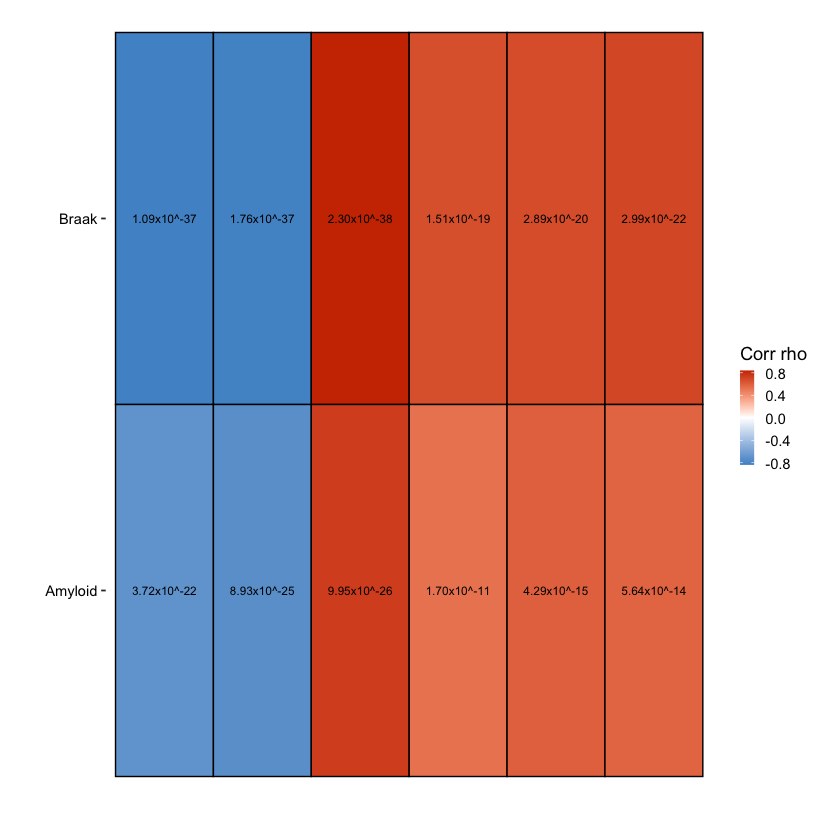

In [64]:
plot_df$log_p <- -log10(plot_df$p_value)

#fisher_p_plot$stars <- cut(fisher_p_plot$adj.pvalue, 
#                           breaks=c(-Inf, 0.001, 0.01, 0.05, Inf), 
#                           label=c("***", "**", "*", ""))

plot_df$text_p <- plot_df$p_value
#plot_df[which(plot_df$p_value >= 0.05), ]$text_p <- NA

changeSciNot <- function(n) {
  output <- formatC(n, format = "e", digits = 2) #Transforms the number into scientific notation even if small
  output <- sub("e", "x10^", output) #Replace e with 10^
  output <- sub("\\+0?", "", output) #Remove + symbol and leading zeros on expoent, if > 1
  output <- sub("-0?", "-", output) #Leaves - symbol but removes leading zeros on expoent, if < 1
  output
}

plot_df$text_p <- as.character(lapply(plot_df$text_p, changeSciNot))

#plot_df[which(plot_df$text_p == ' NA'), ]$text_p <- ""

#pdf("celltype_enrich_for_cluster.pdf", width = 7, height = 2.5)
p_corr <- ggplot(aes(x=cluster, y=label, fill=corr), data=plot_df)+
    geom_tile(colour = "black", size = 0.4) + 
    
    scale_fill_gradient2(name = "Corr rho", low = "steelblue3", mid="white", high = "orangered3") + 
    geom_text(aes(label=text_p), color="black", size=2.5) + 

    scale_x_discrete(breaks=paste("Cluster", seq(1, c_group, 1), sep =""), 
                     labels = c("C1", "C2", "C3", "C4", "C5", "C6")) +

    scale_y_discrete(breaks=c("Amyloid", "Braak")) +

    #guides(fill = guide_legend(keywidth = 1, keyheight = 3, reverse = TRUE)) + 

    xlab("") +
    ylab("") +


    #coord_fixed(ratio=0.5) + 

    theme(panel.border = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          
          legend.key = element_rect(size = 3),
          legend.key.height = unit(0.4, "cm"),
          legend.key.width = unit(0.3, "cm"),
          
          legend.text = element_text(color = "black"),
          
          plot.margin = ggplot2::margin(-0.1, 0.5, 0, 0.5, "cm"),
          
          axis.title.x = element_text(color = "black"),
          
          axis.title.y = element_text(color = "black"),
          
          axis.text.x = element_blank(),
          axis.text.y = element_text(color = "black"),
          
          axis.ticks.x = element_blank(),
          #axis.line = element_line(size = 0.5, linetype = "solid",
          #                         colour = "grey")
          
          axis.line = element_blank()
          
         )
p_corr
#dev.off()

In [41]:
## cell type enrichment for each cluster
## cell type enrichment for each cluster

cell_name <- c("Astro", "Endo", "MG/MF", "Neurons", "Oligo")

table(cell_type_matrix$celltype, useNA = "ifany")

calc_cell_type_for_cluster <- function(cluster_celltype, cell_name, background){
    p_value <- NULL
    
    for(i in cell_name){
        i_in_cluster <- length(which(cluster_celltype == i))
        NotI_in_cluster <- length(cluster_celltype) - i_in_cluster
        i_out_cluster <- length(which(background == i)) - i_in_cluster
        NotI_out_cluster <- length(background) - length(which(background == i)) - NotI_in_cluster
        
        c_table <- data.frame(incluster = c(i_in_cluster, NotI_in_cluster), 
                               outcluster = c(i_out_cluster, NotI_out_cluster))
        
        p_value <- rbind(p_value, fisher.test(c_table, alternative = "two.sided")$p.value)
    }
    
    rownames(p_value) <- cell_name
    return(p_value)
}


  Astro    Endo   MG/MF Neurons   Oligo missing      no 
    439      33      51     319      50      33    2631 

In [42]:
backgroud_celltype <- cell_type_matrix[, c("genesymbol", "celltype")]
celltype_fisher_pcluster <- NULL

for (i in 1:c_group){
    
    
    cluster_celltype <- cell_type_matrix[sig_index[protein_clust$clust == i], ][, c("genesymbol", "celltype")]
    
    celltype_fisher_pcluster <- cbind(celltype_fisher_pcluster,
                                      calc_cell_type_for_cluster(unique(cluster_celltype)$celltype, 
                                                             cell_name, unique(backgroud_celltype)$celltype))
}

colnames(celltype_fisher_pcluster) <- 1:c_group

celltype_fisher_pcluster

1          2            3            4         5          6         
Astro   0.05382282 5.982405e-01 1.544322e-08 0.6329837 0.01060519 0.01872833
Endo    1.00000000 3.253863e-01 5.091354e-01 1.0000000 1.00000000 1.00000000
MG/MF   1.00000000 2.623643e-01 1.095274e-01 1.0000000 0.13551768 1.00000000
Neurons 0.54116450 8.561972e-11 8.716624e-03 0.5763116 1.00000000 0.52313807
Oligo   0.62641529 1.000000e+00 1.040834e-01 1.0000000 1.00000000 0.62531564

In [43]:
calc_cell_type_for_cluster_estimate <- function(cluster_celltype, cell_name, background){
    p_value <- NULL
    
    for(i in cell_name){
        i_in_cluster <- length(which(cluster_celltype == i))
        NotI_in_cluster <- length(cluster_celltype) - i_in_cluster
        i_out_cluster <- length(which(background == i)) - i_in_cluster
        NotI_out_cluster <- length(background) - length(which(background == i)) - NotI_in_cluster
        
        c_table <- data.frame(incluster = c(i_in_cluster, NotI_in_cluster), 
                               outcluster = c(i_out_cluster, NotI_out_cluster))
        
        p_value <- rbind(p_value, fisher.test(c_table, alternative = "two.sided")$estimate)
    }
    
    rownames(p_value) <- cell_name
    return(p_value)
}

In [44]:
backgroud_celltype <- cell_type_matrix[, c("genesymbol", "celltype")]
celltype_fisher_estimate_pcluster <- NULL

for (i in 1:c_group){
    
    
    cluster_celltype <- cell_type_matrix[sig_index[protein_clust$clust == i], ][, c("genesymbol", "celltype")]
    
    celltype_fisher_estimate_pcluster <- cbind(celltype_fisher_estimate_pcluster,
                                      calc_cell_type_for_cluster_estimate(unique(cluster_celltype)$celltype, 
                                                             cell_name, unique(backgroud_celltype)$celltype))
}

colnames(celltype_fisher_estimate_pcluster) <- 1:c_group

celltype_fisher_estimate_pcluster

1         2        3         4         5        6        
Astro   0.3748911 1.131892 4.2318264 1.2117256 2.533418 2.0194918
Endo    0.0000000 1.788398 1.4514608 0.0000000 0.000000 0.0000000
MG/MF   0.9097067 0.000000 2.7476838 0.0000000 3.290570 0.9744396
Neurons 1.2186810 4.329966 0.1262466 0.5407904 1.010502 0.6094128
Oligo   0.0000000 0.513226 2.8155574 0.0000000 0.000000 0.0000000

In [45]:
## correct batch number
#index <- c(1, 2, 3, 5, 6)

index <- 1:c_group

celltype_fisher_pcluster <- celltype_fisher_pcluster[, index]

fisher_p_plot <- data.frame(value = as.numeric(as.vector(celltype_fisher_pcluster)),
                            estimate = as.numeric(as.vector(celltype_fisher_estimate_pcluster)),
                            celltype = rep(rownames(celltype_fisher_pcluster), ncol(celltype_fisher_pcluster)),
                            cluster = paste("cluster_", as.vector(sapply(1:ncol(celltype_fisher_pcluster),
                                                                 rep, nrow(celltype_fisher_pcluster))), sep =""))

#fisher_p_plot$adj.pvalue <- p.adjust(fisher_p_plot$value, method="BH")

fisher_p_plot$adj.pvalue <- fisher_p_plot$value

fisher_p_plot$log_p <- -log10(fisher_p_plot$adj.pvalue)

fisher_p_plot$stars <- cut(fisher_p_plot$adj.pvalue, 
                           breaks=c(-Inf, 0.001, 0.01, 0.05, Inf), 
                           label=c("***", "**", "*", ""))

fisher_p_plot$text_p <- fisher_p_plot$adj.pvalue
fisher_p_plot[which(fisher_p_plot$adj.pvalue >= 0.05), ]$text_p <- NA

changeSciNot <- function(n) {
  output <- formatC(n, format = "e", digits = 2) #Transforms the number into scientific notation even if small
  output <- sub("e", "x10^", output) #Replace e with 10^
  output <- sub("\\+0?", "", output) #Remove + symbol and leading zeros on expoent, if > 1
  output <- sub("-0?", "-", output) #Leaves - symbol but removes leading zeros on expoent, if < 1
  output
}

fisher_p_plot$text_p <- as.character(lapply(fisher_p_plot$text_p, changeSciNot))

fisher_p_plot[which(fisher_p_plot$text_p == ' NA'), ]$text_p <- ""


In [46]:
fisher_p_plot[which(fisher_p_plot$estimate == 0), ]$estimate <- 1
fisher_p_plot

value        estimate  celltype cluster   adj.pvalue   log_p      stars
1  5.382282e-02 0.3748911 Astro    cluster_1 5.382282e-02  1.2690335      
2  1.000000e+00 1.0000000 Endo     cluster_1 1.000000e+00  0.0000000      
3  1.000000e+00 0.9097067 MG/MF    cluster_1 1.000000e+00  0.0000000      
4  5.411645e-01 1.2186810 Neurons  cluster_1 5.411645e-01  0.2666707      
5  6.264153e-01 1.0000000 Oligo    cluster_1 6.264153e-01  0.2031377      
6  5.982405e-01 1.1318922 Astro    cluster_2 5.982405e-01  0.2231242      
7  3.253863e-01 1.7883979 Endo     cluster_2 3.253863e-01  0.4876008      
8  2.623643e-01 1.0000000 MG/MF    cluster_2 2.623643e-01  0.5810952      
9  8.561972e-11 4.3299661 Neurons  cluster_2 8.561972e-11 10.0674262 ***  
10 1.000000e+00 0.5132260 Oligo    cluster_2 1.000000e+00  0.0000000      
11 1.544322e-08 4.2318264 Astro    cluster_3 1.544322e-08  7.8112621 ***  
12 5.091354e-01 1.4514608 Endo     cluster_3 5.091354e-01  0.2931667      
13 1.095274e-01 2.7476838 MG/MF    cluster_3 1.095274e-01  0.9604773      
14 8.716624e-03 0.1262466 Neurons  cluster_3 8.716624e-03  2.0596517 **   
15 1.040834e-01 2.8155574 Oligo    cluster_3 1.040834e-01  0.9826186      
16 6.329837e-01 1.2117256 Astro    cluster_4 6.329837e-01  0.1986075      
17 1.000000e+00 1.0000000 Endo     cluster_4 1.000000e+00  0.0000000      
18 1.000000e+00 1.0000000 MG/MF    cluster_4 1.000000e+00  0.0000000      
19 5.763116e-01 0.5407904 Neurons  cluster_4 5.763116e-01  0.2393426      
20 1.000000e+00 1.0000000 Oligo    cluster_4 1.000000e+00  0.0000000      
21 1.060519e-02 2.5334184 Astro    cluster_5 1.060519e-02  1.9744815 *    
22 1.000000e+00 1.0000000 Endo     cluster_5 1.000000e+00  0.0000000      
23 1.355177e-01 3.2905697 MG/MF    cluster_5 1.355177e-01  0.8680040      
24 1.000000e+00 1.0105017 Neurons  cluster_5 1.000000e+00  0.0000000      
25 1.000000e+00 1.0000000 Oligo    cluster_5 1.000000e+00  0.0000000      
26 1.872833e-02 2.0194918 Astro    cluster_6 1.872833e-02  1.7275011 *    
27 1.000000e+00 1.0000000 Endo     cluster_6 1.000000e+00  0.0000000      
28 1.000000e+00 0.9744396 MG/MF    cluster_6 1.000000e+00  0.0000000      
29 5.231381e-01 0.6094128 Neurons  cluster_6 5.231381e-01  0.2813837      
30 6.253156e-01 1.0000000 Oligo    cluster_6 6.253156e-01  0.2039007      
   text_p     
1             
2             
3             
4             
5             
6             
7             
8             
9  8.56x10^-11
10            
11 1.54x10^-8 
12            
13            
14 8.72x10^-3 
15            
16            
17            
18            
19            
20            
21 1.06x10^-2 
22            
23            
24            
25            
26 1.87x10^-2 
27            
28            
29            
30

In [47]:
fisher_p_plot$log2_estimate <- log2(fisher_p_plot$estimate)

In [48]:
Astrocytes = "#FEB24C"
Endothelial = "#88419D"
Microglia = "#9ECAE1"
Neurons = "#ADDD8E"
Oligodendrocytes = "#DD3497"
No_unique_enrichment = "#969696"
NS_DEPs = "gray88"

In [49]:
fisher_p_plot$celltype <- factor(fisher_p_plot$celltype, 
                                 levels = c("Oligo", "Neurons", "MG/MF", "Endo", "Astro"))

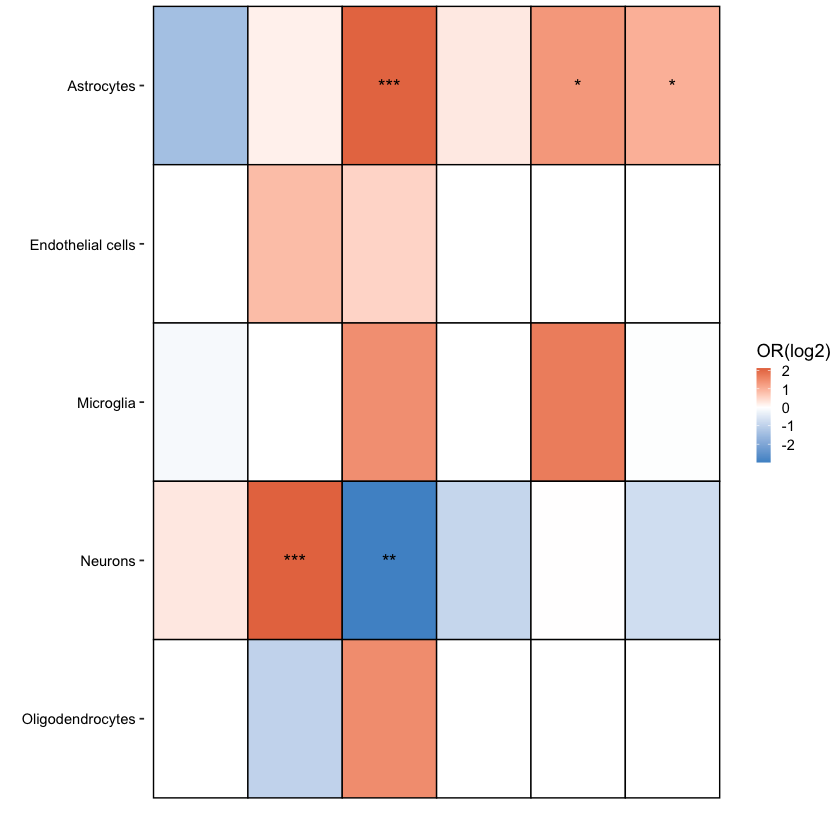

In [51]:

#pdf("celltype_enrich_for_cluster.pdf", width = 7, height = 2.5)
p_celltype <- ggplot(aes(x=cluster, y=celltype, fill=log2_estimate), data=fisher_p_plot)+
    geom_tile(colour = "black", size = 0.4) + 
    scale_fill_gradient2(name = "OR(log2)", midpoint = 0, 
                        low = "steelblue3", mid="white", high = "orangered3") + 
    geom_text(aes(label=stars), color="black", size=4) + 

    scale_x_discrete(breaks=paste("cluster_", seq(1, 7, 1), sep =""), 
                     labels = c("C1", "C2", "C3", "C4", "C5", "C6", "C7")) +

    scale_y_discrete(breaks = c("Oligo", "Neurons", "MG/MF", "Endo", "Astro"),
                     labels = c("Oligodendrocytes", "Neurons", "Microglia", "Endothelial cells", "Astrocytes")) +

    #coord_fixed(ratio=0.5) + 
    xlab("") +
    ylab("") +

    theme(panel.border = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          
          
          plot.margin = ggplot2::margin(-0.2, 0, 0, 0, "cm"),
          #legend.title = element_text(color = "black",angle = -90, hjust = 0.5, vjust = 0.5),
          legend.text = element_text(color = "black"),
          
          legend.key = element_rect(size = 6),
          legend.key.height = unit(0.4, "cm"),
          legend.key.width = unit(0.3, "cm"),
          
          axis.title.x = element_text(color = "black"),
          
          axis.title.y = element_text(color = "black"),
          
          
          axis.text.y = element_text(color = "black"),
          
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          
          legend.position="right",
          legend.direction='vertical',
          
          #axis.line = element_line(size = 0.5, linetype = "solid",
          #                         colour = "grey")
          
          axis.line = element_blank()
          
         )
p_celltype
#dev.off()

In [129]:
cluster_p_plot <- data.frame(col = c('#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00', '#FFFF33'),
                            label = rep("cluster", c_group),
                            cluster = paste("cluster", seq(1, c_group, 1), sep=""))

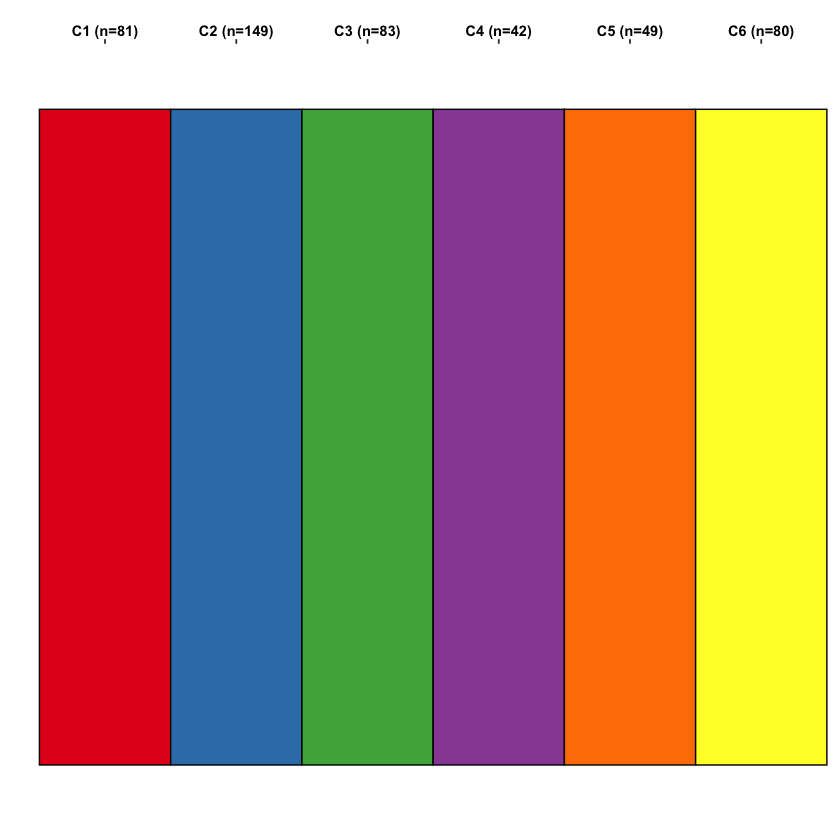

In [130]:
p_cluster <- ggplot(aes(x=cluster, y=label), data=cluster_p_plot)+
    geom_tile(fill = cluster_p_plot$col, colour = "black", size = 0.4) + 

    scale_x_discrete(breaks=paste("cluster", seq(1, 6, 1), sep =""), position = "top",
                     labels = c(paste("C1 (n=", sum(protein_clust$clust == 1), ")", sep = ""),
                                paste("C2 (n=", sum(protein_clust$clust == 2), ")", sep = ""), 
                                paste("C3 (n=", sum(protein_clust$clust == 3), ")", sep = ""), 
                                paste("C4 (n=", sum(protein_clust$clust == 4), ")", sep = ""), 
                                paste("C5 (n=", sum(protein_clust$clust == 5), ")", sep = ""), 
                                paste("C6 (n=", sum(protein_clust$clust == 6), ")", sep = ""))) +

    scale_y_discrete(breaks = c("cluster"),
                     labels = c("")) +

    #coord_fixed(ratio=0.5) + 
    xlab("") +
    ylab("") +

    theme(panel.border = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          
          
          plot.margin = ggplot2::margin(0, 0, 0.2, 0, "cm"),
          
          legend.text = element_text(color = "black"),
          
          axis.title.x = element_text(color = "black"),
          
          axis.title.y = element_text(color = "black"),
          
          axis.text.x = element_text(angle = 0, face = "bold",
                                     color = "black", hjust = 0.5),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          
          #axis.line = element_line(size = 0.5, linetype = "solid",
          #                         colour = "grey")
          
          axis.line = element_blank()
          
         )
p_cluster

In [52]:
cluster_p_plot <- data.frame(x = seq(1 ,6),
                             label = c(paste("C1 (n=", sum(protein_clust$clust == 1), ")", sep = ""),
                                       paste("C2 (n=", sum(protein_clust$clust == 2), ")", sep = ""), 
                                       paste("C3 (n=", sum(protein_clust$clust == 3), ")", sep = ""), 
                                       paste("C4 (n=", sum(protein_clust$clust == 4), ")", sep = ""), 
                                       paste("C5 (n=", sum(protein_clust$clust == 5), ")", sep = ""), 
                                       paste("C6 (n=", sum(protein_clust$clust == 6), ")", sep = "")),
                             y = rep(1, 6))

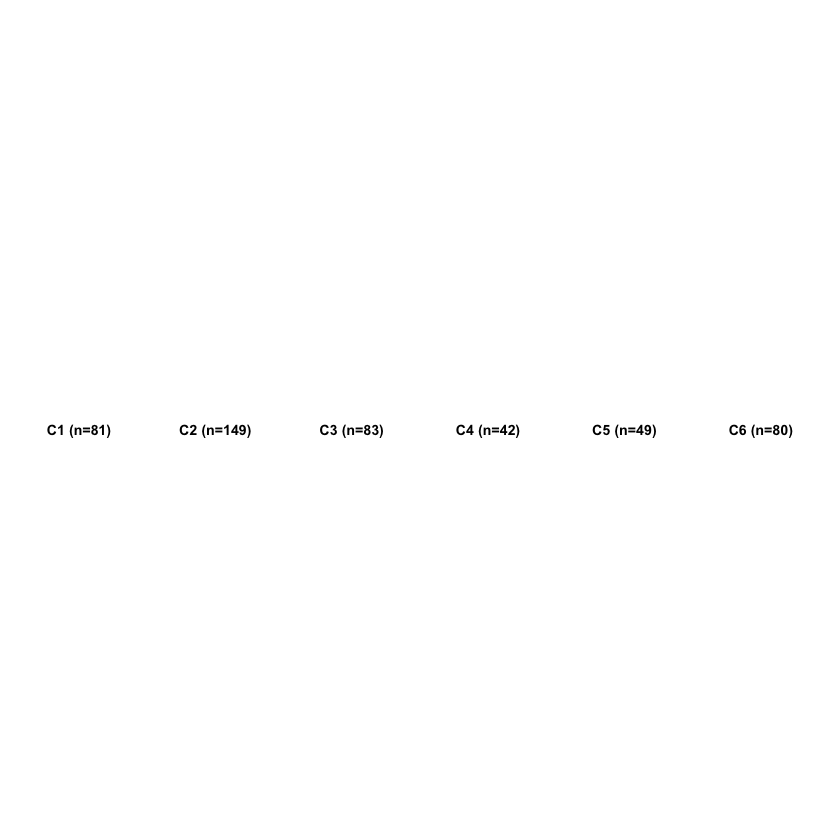

In [53]:
p_cluster <- ggplot(aes(x=x, y=y), data=cluster_p_plot) + 
    xlim(0.7, 6.3) +
    annotate("text", x = cluster_p_plot$x, y = cluster_p_plot$y, color="black", fontface='bold',
             size=3, label = cluster_p_plot$label) + 
    theme_void() + 
    theme(plot.margin = ggplot2::margin(0, 0, -0.4, 0, "cm"))
p_cluster

In [54]:
median_stage_exps_ANOVA <- as.data.frame(t(apply(protein_intensity_combat[sig_index, ][, Braak_test_index], 1, 
                                                 cal_median_for_stage, metadata[Braak_test_index, ]$fBraak)))

colnames(median_stage_exps_ANOVA) <- c("I", "II", "III", "IV", "V", "VI")

#median_stage_exps_ANOVA <- scale(median_stage_exps_ANOVA, center = TRUE, scale = TRUE)
median_stage_exps_ANOVA <- t(scale(t(median_stage_exps_ANOVA), center = TRUE, scale = FALSE))

cluster_trend_plots <- list()
j <- 1

breaks = c(0.125, 0.25, 0.5, 0.75, 0.875)
#breaks = c(0, 0.25, 0.5, 0.75, 1)
cluster_trend <- as.data.frame(t(apply(median_stage_exps_ANOVA[protein_clust$clust == 1, ], 2, 
                                       quantile, probs = breaks, type = 4)))

cluster_trend <- cbind(seq(1,6), cluster_trend)
colnames(cluster_trend) <- c("Braak", paste("CI_", seq(from = 0, to = 1, by = 0.25), sep = ""))

xlabels <- seq(from = 1, to = 6, by = 1)
p_trend <- ggplot(cluster_trend, aes(x = Braak)) +
    geom_ribbon(aes(ymin=CI_0,ymax=CI_1), fill="black", alpha=0.1) +
    geom_ribbon(aes(ymin=CI_0.25,ymax=CI_0.75), fill="black", alpha=0.4) +
    
    geom_line(aes(y=CI_0.5), col="black", alpha=1, size = 0.5) +
    geom_line(aes(y=CI_0), col="black", alpha=0.5, size = 0.5) +
    geom_line(aes(y=CI_1), col="black", alpha=0.5, size = 0.5) +  
    #geom_line(aes(y=CI_0.25), col=color_ND, alpha=0.2, size = 0.5, linetype = "dashed") +
    #geom_line(aes(y=CI_0.75), col=color_ND, alpha=0.2, size = 0.5, linetype = "dashed") +  

    #coord_fixed(ratio=100) + 
    ggtitle(paste("Cluster", 1, sep = " ")) +
    xlab("Braak stage") +
    ylab("Protein intensity (Log2)") +
    scale_x_continuous(breaks=seq(1,6,1), labels = c("I", "II", "III", "IV", "V", "VI")) +
    scale_y_continuous(limits = c(-1.25, 1.5), breaks=seq(-1, 1.5, 0.5)) +
    
    #geom_hline(yintercept = 0.5, linetype = "solid", color = "black", size = 0.5) +

    theme(#plot.background = element_rect(),    # Background of the entire plot
          panel.background = element_rect(fill = "white"),   # Background of plotting area
          #panel.border = element_rect(),       # Border around plotting area.
                                               # fill argument should be NA
  
          panel.grid = element_line(),         # All grid lines
          #panel.grid.major = element_line(),   # Major grid lines
          #panel.grid.minor = element_line(),   # Minor grid lines
  
          #panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
          #                      color = "gray"), # Vertical major grid lines
          #panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
          #                      color = "gray"), # Horizontal major grid lines
          #panel.grid.minor.x = element_line(), # Vertical minor grid lines
          #panel.grid.minor.y = element_line(),  # Vertical major grid lines
        
          plot.margin = ggplot2::margin(0, 0.25, 0, -0.5, "cm"),
        
          plot.title = element_blank(),
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          
          axis.text.x = element_text(color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(color = "black"),
          
          axis.line = element_line(size = 0.4, linetype = "solid",
                                   colour = "black")
         )

cluster_trend_plots[[j]] <- p_trend
j = j +1
add_marg <- 0.03

for(i in 2:c_group){

cluster_trend <- as.data.frame(t(apply(median_stage_exps_ANOVA[protein_clust$clust == i, ], 2, 
                                       quantile, probs = breaks, type = 4)))

cluster_trend <- cbind(seq(1,6), cluster_trend)
colnames(cluster_trend) <- c("Braak", paste("CI_", seq(from = 0, to = 1, by = 0.25), sep = ""))

xlabels <- seq(from = 1, to = 6, by = 1)
p_trend <- ggplot(cluster_trend, aes(x = Braak)) +
    geom_ribbon(aes(ymin=CI_0,ymax=CI_1), fill="black", alpha=0.1) +
    geom_ribbon(aes(ymin=CI_0.25,ymax=CI_0.75), fill="black", alpha=0.4) +
    
    geom_line(aes(y=CI_0.5), col="black", alpha=1, size = 0.5) +
    geom_line(aes(y=CI_0), col="black", alpha=0.5, size = 0.5) +
    geom_line(aes(y=CI_1), col="black", alpha=0.5, size = 0.5) +  
    #geom_line(aes(y=CI_0.25), col=color_ND, alpha=0.2, size = 0.5, linetype = "dashed") +
    #geom_line(aes(y=CI_0.75), col=color_ND, alpha=0.2, size = 0.5, linetype = "dashed") +  

    #coord_fixed(ratio=100) + 
    ggtitle(paste("Cluster", i, sep = " ")) +
    xlab("Braak stage") +
    ylab("Protein intensity (Log2)") +
    scale_x_continuous(breaks=seq(1,6,1), labels = c("I", "II", "III", "IV", "V", "VI")) +
    scale_y_continuous(limits = c(-1.25, 1.5), breaks=seq(-1.25, 1.5, 0.25)) +
    
    #geom_hline(yintercept = 0.5, linetype = "solid", color = "black", size = 0.5) +

    theme(#plot.background = element_rect(),    # Background of the entire plot
          panel.background = element_rect(fill = "white"),   # Background of plotting area
          #panel.border = element_rect(),       # Border around plotting area.
                                               # fill argument should be NA
  
          panel.grid = element_line(),         # All grid lines
          #panel.grid.major = element_line(),   # Major grid lines
          #panel.grid.minor = element_line(),   # Minor grid lines
  
          #panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
          #                      color = "gray"), # Vertical major grid lines
          #panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
          #                      color = "gray"), # Horizontal major grid lines
          #panel.grid.minor.x = element_line(), # Vertical minor grid lines
          #panel.grid.minor.y = element_line(),  # Vertical major grid lines
        
          plot.margin = ggplot2::margin(0, (0.2+add_marg*(i-1)), 0, -(0.15+add_marg*(i-1)), "cm"),
        
          plot.title = element_blank(),
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          
          axis.text.x = element_text(color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
        
          axis.line = element_line(size = 0.4, linetype = "solid",
                                   colour = "black")
         )

cluster_trend_plots[[j]] <- p_trend
j = j +1
}

p_trend <- plot_grid(plotlist = cluster_trend_plots, ncol = 6, nrow = 1, 
                     rel_widths = c(1, rep(0.9 ,5)),
                     align = "h", axis = "tblr")

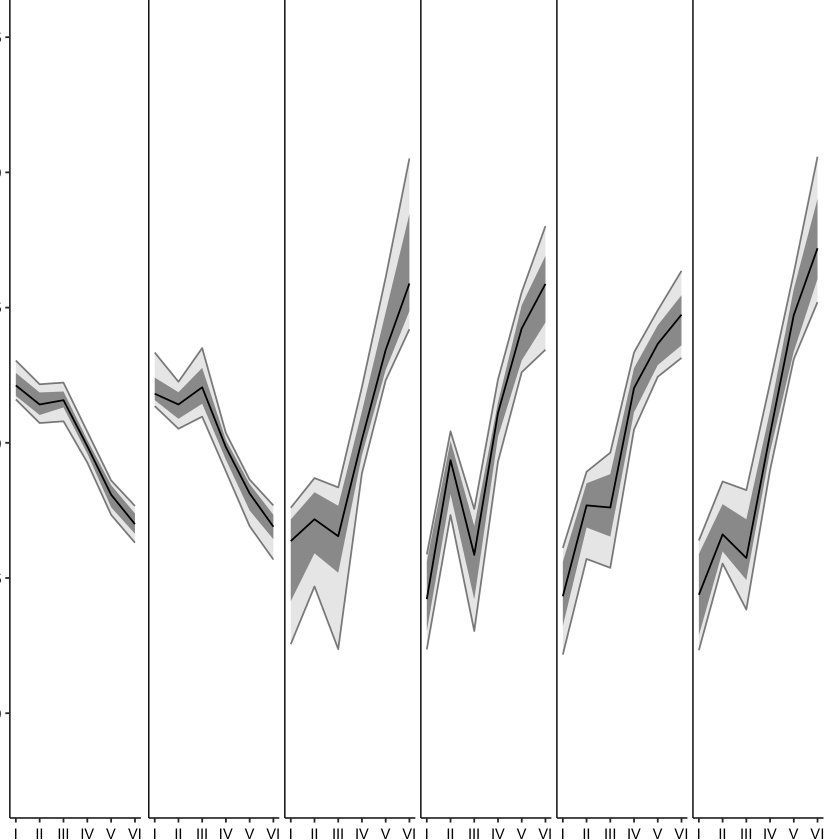

In [55]:
p_trend

In [56]:
cell_type_matrix_new <- cell_type_matrix
cell_type_matrix_new[which(cell_type_matrix$celltype == "missing"),]$celltype <- "no"

In [57]:
cell_type_matrix_new$celltype <- factor(cell_type_matrix_new$celltype, 
                                        levels = c("no", "Oligo", "Neurons", "MG/MF", "Endo", "Astro"))

In [58]:
generate_pie_chart <- function(clust_n){
    pie_data <- as.data.frame(table(cell_type_matrix_new[sig_index[protein_clust$clust == clust_n], ]$celltype))
    
    blank_theme <- theme_minimal()+
        theme(
            axis.title.x = element_blank(),
            axis.title.y = element_blank(),
            panel.border = element_blank(),
            panel.grid=element_blank(),
            axis.ticks = element_blank(),
            plot.title=element_text(size=14, face="bold")
        )

    p <- ggplot(pie_data, aes(x="", y=Freq, fill=Var1))+
        geom_bar(width = 1, stat = "identity") +
        coord_polar("y", start=0) +
        scale_fill_manual(name="Cell type", values = c(No_unique_enrichment, 
                                                       Oligodendrocytes, 
                                                       Neurons, 
                                                       Microglia, 
                                                       Endothelial, 
                                                       Astrocytes)) +
        blank_theme +
        theme(axis.text.x=element_blank(), 
              legend.position="none",
              plot.margin = ggplot2::margin(-0.25, -0.25 + add_marg*(i-1), -0.3, -0.35-add_marg*(i-1), "cm")) +
        geom_text(aes(label = ifelse(Freq < 3, "", paste0(round(Freq/sum(Freq)*100), "%"))), 
                  position = position_stack(vjust = 0.5), size = 2.5)
    #p
    return(p)
    
}

In [59]:
pie_charts <- NULL
for(i in 1:c_group){
    pie_charts[[i]] <- generate_pie_chart(i)
}

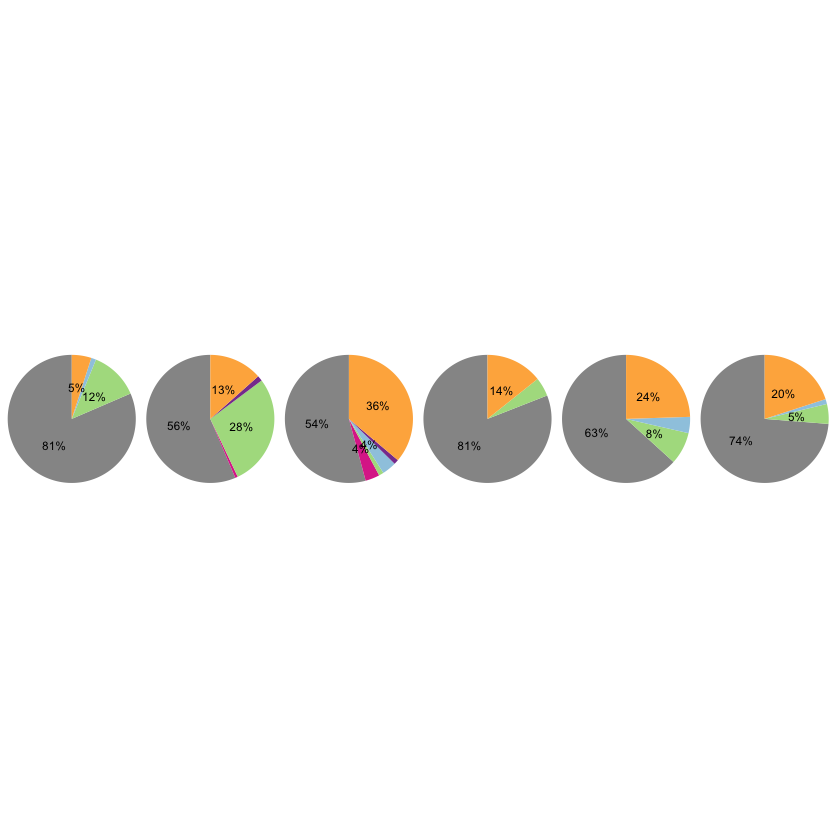

In [60]:
p_pie <- plot_grid(plotlist = pie_charts, ncol = 6, nrow = 1, 
                     rel_widths = c(rep(1/6,6)),
                     align = "h", axis = "tblr")
p_pie

In [61]:
cell_type_matrix_new$celltype <- factor(cell_type_matrix_new$celltype, 
                                        levels = rev(c("no", "Oligo", "Neurons", "MG/MF", "Endo", "Astro")))

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

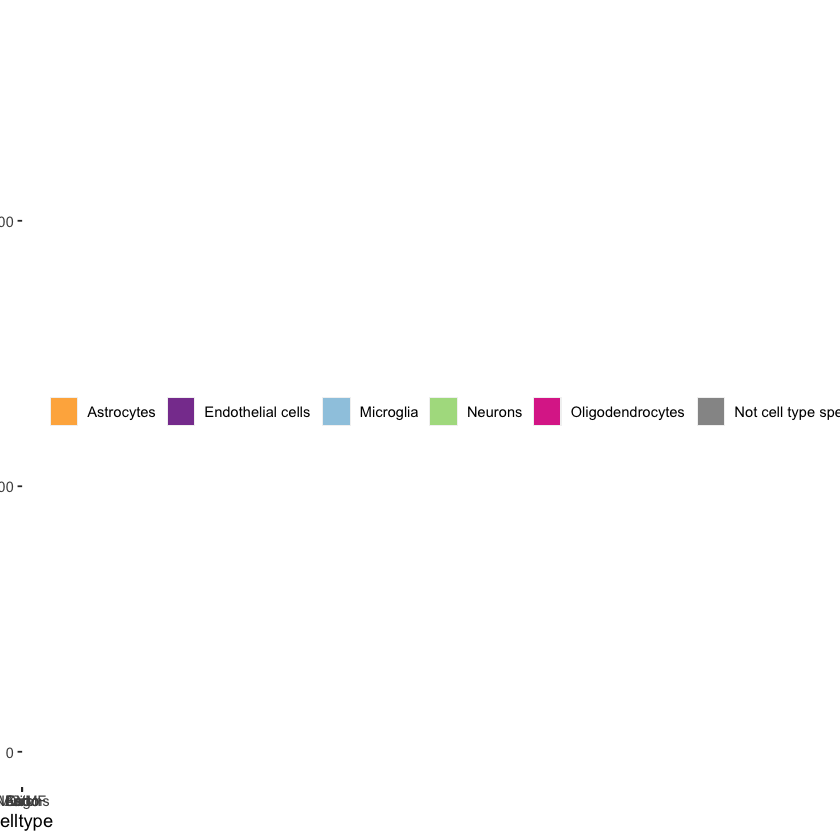

In [62]:
legend <- ggplot(cell_type_matrix_new, aes(x=celltype, fill=celltype))+
        geom_histogram(stat="count") +
        scale_fill_manual(name="", 
                          values = rev(c(No_unique_enrichment, 
                                     Oligodendrocytes, 
                                     Neurons, 
                                     Microglia, 
                                     Endothelial, 
                                     Astrocytes)),
                          labels = c("Astrocytes",
                                     "Endothelial cells",
                                     "Microglia",
                                     "Neurons",
                                     "Oligodendrocytes",
                                     "Not cell type specific")
                          ) +
        guides(fill=guide_legend(nrow=1)) #+
        #theme(
        #    legend.position="bottom",
        #    legend.box = "horizontal"
            
        #)
legend

In [63]:
legend <- get_legend(legend)

In [67]:
Enrich_plot <- plot_grid(p_hc, p_cluster, p_trend, p_pie, p_celltype, 
                         rel_heights = c(0.09, 0.05, 0.18, 0.22, 0.25),
                         align = "v", axis = "lr", nrow = 5, ncol = 1)

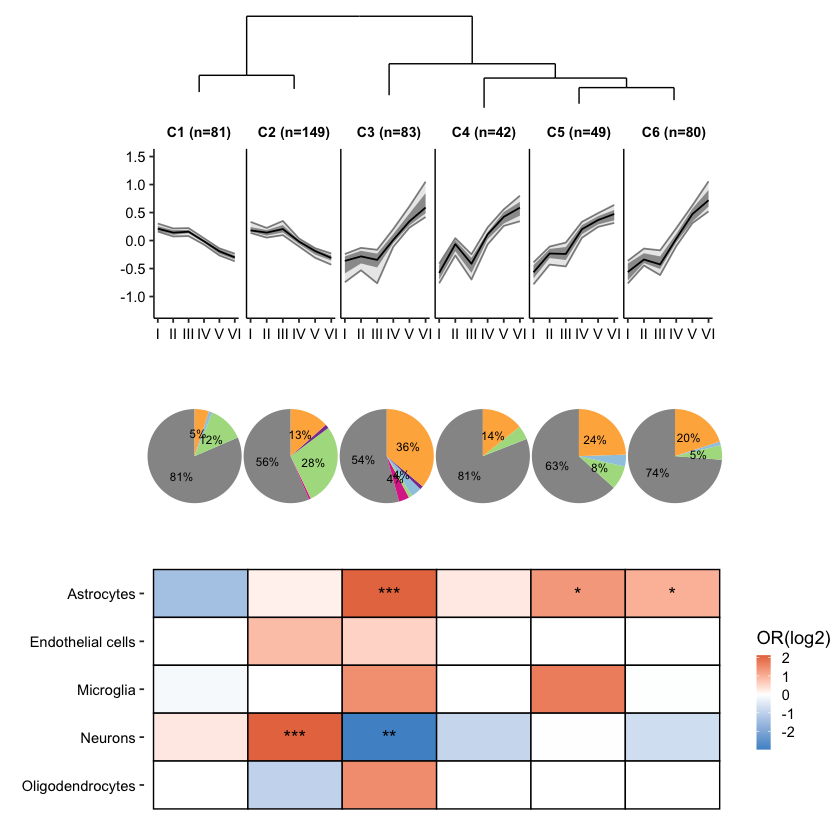

In [68]:
Enrich_plot

In [69]:
save_plot("100_plus_plots/proteomics/Enrichment_analysis_table_plot_v2.pdf", 
          Enrich_plot, base_height = 5, base_width = 9)

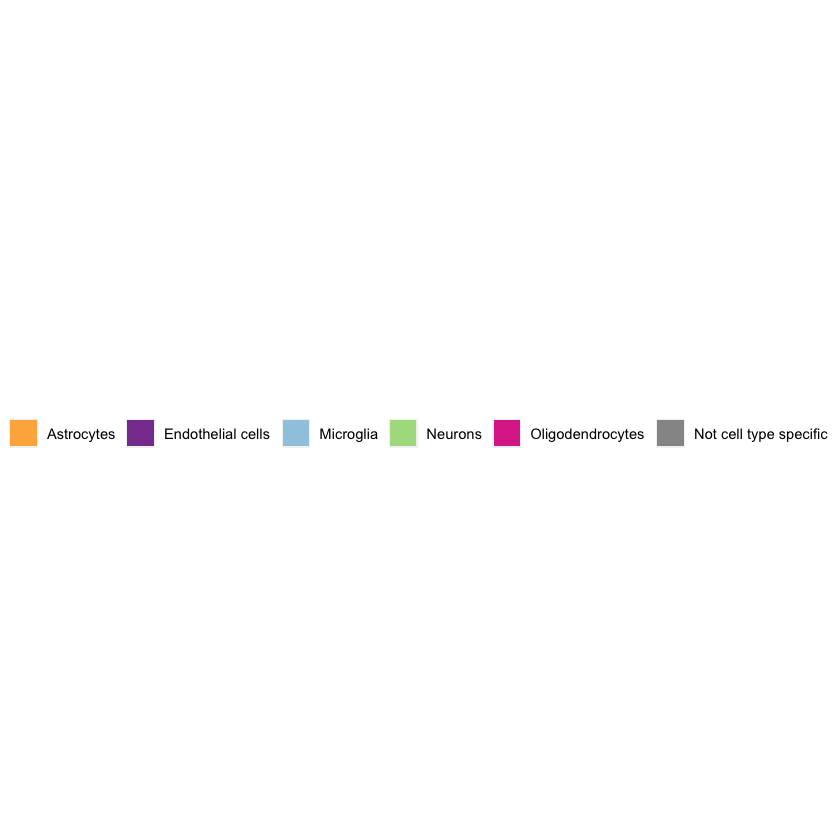

In [386]:
plot_grid(legend)

In [682]:
median_stage_exps_ANOVA <- as.data.frame(t(apply(protein_intensity_combat[sig_index, ][, Braak_test_index], 1, 
                                                 cal_median_for_stage, metadata[Braak_test_index, ]$fBraak)))

colnames(median_stage_exps_ANOVA) <- c("I", "II", "III", "IV", "V", "VI")

#median_stage_exps_ANOVA <- scale(median_stage_exps_ANOVA, center = TRUE, scale = TRUE)
median_stage_exps_ANOVA <- t(scale(t(median_stage_exps_ANOVA), center = TRUE, scale = FALSE))

cluster_trend_plots <- list()
median_for_cluster <- NULL

j <- 1

#breaks = c(0.125, 0.25, 0.5, 0.75, 0.875)
breaks = c(0.05, 0.25, 0.5, 0.75, 0.95)
cluster_trend <- as.data.frame(t(apply(median_stage_exps_ANOVA[protein_clust$clust == 1, ], 2, 
                                       quantile, probs = breaks, type = 9)))

cluster_trend <- cbind(seq(1,6), cluster_trend)
colnames(cluster_trend) <- c("Braak", paste("CI_", seq(from = 0, to = 1, by = 0.25), sep = ""))

median_for_cluster <- rbind(median_for_cluster, cluster_trend[,c(1, 4)])

xlabels <- seq(from = 1, to = 6, by = 1)
p_trend <- ggplot(cluster_trend, aes(x = Braak)) +
    geom_ribbon(aes(ymin=CI_0,ymax=CI_1), fill="black", alpha=0.1) +
    geom_ribbon(aes(ymin=CI_0.25,ymax=CI_0.75), fill="black", alpha=0.4) +
    
    geom_line(aes(y=CI_0.5), col="black", alpha=1, size = 1) +
    geom_line(aes(y=CI_0), col="black", alpha=0.5, size = 0.5) +
    geom_line(aes(y=CI_1), col="black", alpha=0.5, size = 0.5) +  
    #geom_line(aes(y=CI_0.25), col=color_ND, alpha=0.2, size = 0.5, linetype = "dashed") +
    #geom_line(aes(y=CI_0.75), col=color_ND, alpha=0.2, size = 0.5, linetype = "dashed") +  

    #coord_fixed(ratio=100) + 
    ggtitle(paste("Cluster", 1, sep = " ")) +
    xlab("Braak stage") +
    ylab("Protein intensity (Log2)") +
    scale_x_continuous(breaks=seq(1,6,1), labels = c("I", "II", "III", "IV", "V", "VI")) +
    scale_y_continuous(limits = c(-1.25, 1.5), breaks=seq(-1.25, 1.5, 0.25)) +
    
    #geom_hline(yintercept = 0.5, linetype = "solid", color = "black", size = 0.5) +

    theme(#plot.background = element_rect(),    # Background of the entire plot
          panel.background = element_rect(fill = "white"),   # Background of plotting area
          #panel.border = element_rect(),       # Border around plotting area.
                                               # fill argument should be NA
  
          panel.grid = element_line(),         # All grid lines
          #panel.grid.major = element_line(),   # Major grid lines
          #panel.grid.minor = element_line(),   # Minor grid lines
  
          #panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
          #                      color = "gray"), # Vertical major grid lines
          #panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
          #                      color = "gray"), # Horizontal major grid lines
          #panel.grid.minor.x = element_line(), # Vertical minor grid lines
          #panel.grid.minor.y = element_line(),  # Vertical major grid lines
        
          #plot.margin = ggplot2::margin(0, 0.3, 0, -0.5, "cm"),
        
          plot.title = element_blank(),
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          
          axis.text.x = element_text(color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(color = "black"),
          
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "black")
         )

cluster_trend_plots[[j]] <- p_trend
j = j +1
add_marg <- 0.015

for(i in 2:c_group){

cluster_trend <- as.data.frame(t(apply(median_stage_exps_ANOVA[protein_clust$clust == i, ], 2, 
                                       quantile, probs = breaks, type = 9)))

cluster_trend <- cbind(seq(1,6), cluster_trend)
colnames(cluster_trend) <- c("Braak", paste("CI_", seq(from = 0, to = 1, by = 0.25), sep = ""))
    
median_for_cluster <- rbind(median_for_cluster, cluster_trend[,c(1, 4)])

xlabels <- seq(from = 1, to = 6, by = 1)
p_trend <- ggplot(cluster_trend, aes(x = Braak)) +
    geom_ribbon(aes(ymin=CI_0,ymax=CI_1), fill="black", alpha=0.1) +
    geom_ribbon(aes(ymin=CI_0.25,ymax=CI_0.75), fill="black", alpha=0.4) +
    
    geom_line(aes(y=CI_0.5), col="black", alpha=1, size = 1) +
    geom_line(aes(y=CI_0), col="black", alpha=0.5, size = 0.5) +
    geom_line(aes(y=CI_1), col="black", alpha=0.5, size = 0.5) +  
    #geom_line(aes(y=CI_0.25), col=color_ND, alpha=0.2, size = 0.5, linetype = "dashed") +
    #geom_line(aes(y=CI_0.75), col=color_ND, alpha=0.2, size = 0.5, linetype = "dashed") +  

    #coord_fixed(ratio=100) + 
    ggtitle(paste("Cluster", i, sep = " ")) +
    xlab("Braak stage") +
    ylab("Protein intensity (Log2)") +
    scale_x_continuous(breaks=seq(1,6,1), labels = c("I", "II", "III", "IV", "V", "VI")) +
    scale_y_continuous(limits = c(-1.25, 1.5), breaks=seq(-1.25, 1.5, 0.25)) +
    
    #geom_hline(yintercept = 0.5, linetype = "solid", color = "black", size = 0.5) +

    theme(#plot.background = element_rect(),    # Background of the entire plot
          panel.background = element_rect(fill = "white"),   # Background of plotting area
          #panel.border = element_rect(),       # Border around plotting area.
                                               # fill argument should be NA
  
          panel.grid = element_line(),         # All grid lines
          #panel.grid.major = element_line(),   # Major grid lines
          #panel.grid.minor = element_line(),   # Minor grid lines
  
          #panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
          #                      color = "gray"), # Vertical major grid lines
          #panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
          #                      color = "gray"), # Horizontal major grid lines
          #panel.grid.minor.x = element_line(), # Vertical minor grid lines
          #panel.grid.minor.y = element_line(),  # Vertical major grid lines
        
          #plot.margin = ggplot2::margin(0, 0.35, 0, -(0.15+add_marg*(i-1)), "cm"),
        
          plot.title = element_blank(),
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          
          axis.text.x = element_text(color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          #axis.text.y = element_blank(),
          #axis.ticks.y = element_blank(),
        
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "black")
         )

cluster_trend_plots[[j]] <- p_trend
j = j +1
}

p_trend <- plot_grid(plotlist = cluster_trend_plots, ncol = 6, nrow = 1, 
                     #rel_widths = c(1, rep(0.9 ,5)),
                     align = "h", axis = "tblr")

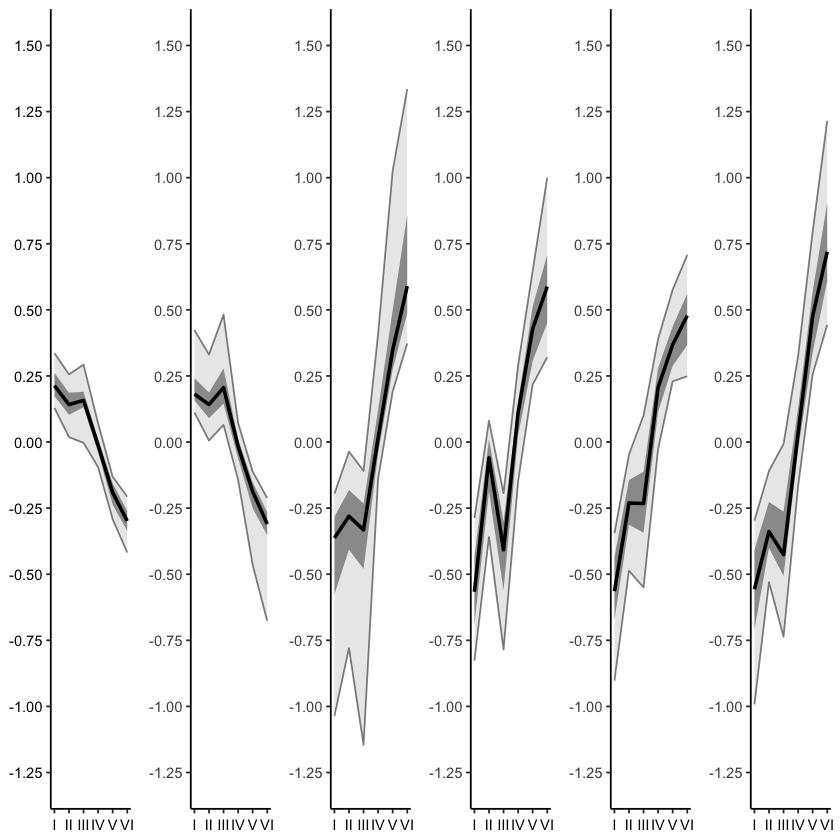

In [683]:
p_trend

In [684]:
save_plot("100_plus_plots/Trends_plot.pdf", p_trend, base_height = 3, base_width = 18)

In [685]:
median_for_cluster$Cluster <- c(rep("cluster1", 6),
                                rep("cluster2", 6),
                                rep("cluster3", 6), 
                                rep("cluster4", 6),
                                rep("cluster5", 6),
                                rep("cluster6", 6))

In [694]:
xlabels <- seq(from = 1, to = 6, by = 1)

png("100_plus_plots/median_trend_plot_for_cluster.png", width=2000, height=2000, res=300)
p <- ggplot(median_for_cluster, aes(x = Braak, y=CI_0.5, color = Cluster)) +
    
    geom_line(alpha=1, size = 1) +
    
    #coord_fixed(ratio=100) + 
    #ggtitle(paste("Cluster", 1, sep = " ")) +
    xlab("Braak stage") +
    ylab("Protein intensity (Log2)") +
    scale_x_continuous(breaks=seq(1,6,1), labels = c("I", "II", "III", "IV", "V", "VI")) +
    scale_y_continuous(limits = c(-1, 1.2), breaks=seq(-1, 1.2, 0.25)) +
    
    scale_color_manual(name="Cluster", 
                       values = c('#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00', '#FFFF33'),
                      ) + 
    theme(#plot.background = element_rect(),    # Background of the entire plot
          panel.background = element_rect(fill = "white"),   # Background of plotting area
          #panel.border = element_rect(),       # Border around plotting area.
                                               # fill argument should be NA
  
          panel.grid = element_line(),         # All grid lines
          #panel.grid.major = element_line(),   # Major grid lines
          #panel.grid.minor = element_line(),   # Minor grid lines
  
          #panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
          #                      color = "gray"), # Vertical major grid lines
          #panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
          #                      color = "gray"), # Horizontal major grid lines
          #panel.grid.minor.x = element_line(), # Vertical minor grid lines
          #panel.grid.minor.y = element_line(),  # Vertical major grid lines
        
          #plot.margin = ggplot2::margin(0, 0.3, 0, -0.5, "cm"),
        
          plot.title = element_blank(),
          #axis.title.x = element_blank(),
          #axis.title.y = element_blank(),
          
          axis.text.x = element_text(color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(color = "black"),
          
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "black")
         )
p
dev.off()

pdf 
  2

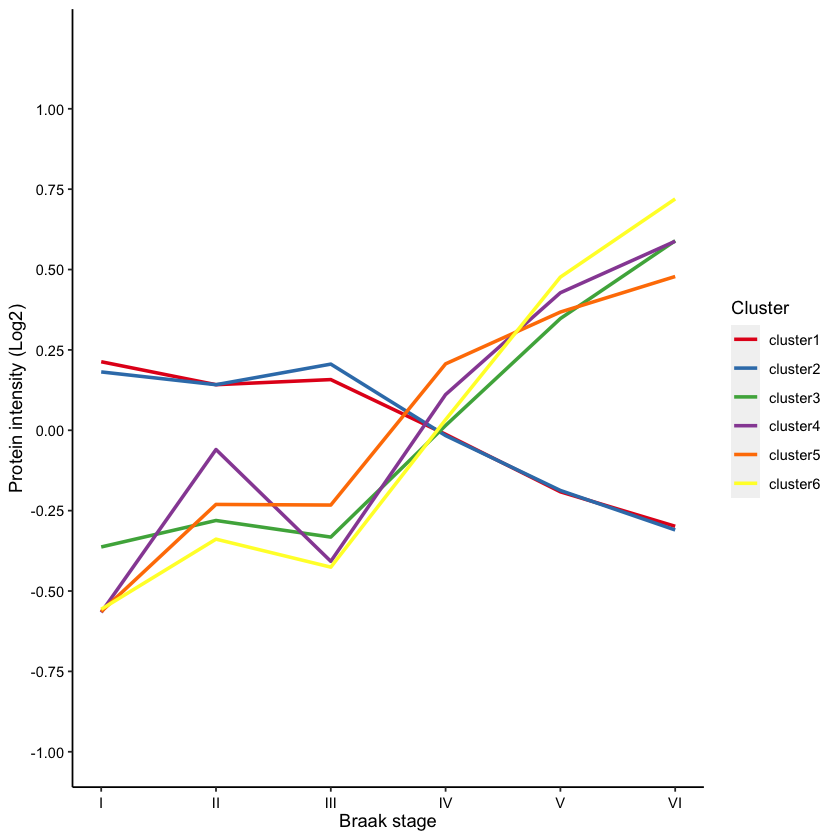

In [695]:
p

In [190]:
protein_intens_cluster <- protein_intensity_combat[sig_index[which(protein_clust$clust == 5)],][, Braak_test_index]
svd(t(scale(t(protein_intens_cluster))), nu = 1, nv = 1)$d
t(svd(t(scale(t(protein_intens_cluster))), nu = 1, nv = 1)$u) %*% t(scale(t(protein_intens_cluster)))

[1] 69.5029010 17.4331766 13.6524946 12.7931715 11.8722945 11.0809567
 [7] 10.7314638  9.3099130  8.8015330  8.6571747  8.2215097  7.7288185
[13]  7.4222079  7.0086025  6.7328643  6.2939027  5.9523090  5.8484336
[19]  5.5709809  5.3897559  4.9896568  4.8111331  4.6573017  4.4149371
[25]  4.1730859  4.0007522  3.6897465  3.6681476  3.5100739  3.3789276
[31]  3.3641172  3.1825407  2.8477564  2.7862072  2.7104334  2.5478386
[37]  2.3911744  2.3363208  2.2864303  2.2021508  1.9557096  1.7377261
[43]  1.6146060  1.3953509  1.2107790  1.0782928  1.0318905  0.8919263
[49]  0.6565999

intensity_20190325_16_04_037_AD_008 intensity_20190325_183_S10_292_AD_010
[1,] -1.182064                           -1.558689                            
     intensity_20190325_194_S02_055_ND_005 intensity_20190325_31_01_184_AD_006
[1,] 13.60683                              -4.464858                          
     intensity_20190325_57_S97_235_AD_003 intensity_20190325_77_S11_072_ND_012
[1,] -5.847058                            3.571838                            
     intensity_20190325_79_S07_308_ND_009 intensity_20190325_95_S05_217_ND_002
[1,] 0.1704649                            0.5535761                           
     intensity_20190326_176_S04_088_AD_021
[1,] 1.016988                             
     intensity_20190326_195_S03_035_ND_024 ...
[1,] 9.81274                               ...
     intensity_20190507_200_S08_298_ND_218 intensity_20190507_21_01_032_AD_221
[1,] 8.917254                              -2.445835                          
     intensity_20190507_27_00_204_AD_211 intensity_20190507_29_S99_240_AD_219
[1,] -3.247672                           -1.633033                           
     intensity_20190507_30_S05_040_AD_209 intensity_20190507_63_04_027_AD_217
[1,] 3.220513                             -0.9615425                         
     intensity_20190507_72_S99_219_AD_213
[1,] -3.897061                           
     intensity_20190606_106_NABCA14_08_ND_RERUN
[1,] 0.2549558                                 
     intensity_20190606_20_S00_166_AD_RERUN
[1,] 1.43604                               
     intensity_20190606_9_S93_025_AD_RERUN
[1,] -6.112452

In [191]:
protein_intens_cluster <- protein_intensity_combat[sig_index[which(protein_clust$clust == 5)],][, Braak_test_index]
cluster.pca <- prcomp(t(protein_intens_cluster), scale = TRUE)

In [192]:
cluster.pca$x[, 1]

intensity_20190325_16_04_037_AD_008 
                               -1.18206403 
     intensity_20190325_183_S10_292_AD_010 
                               -1.55868939 
     intensity_20190325_194_S02_055_ND_005 
                               13.60683159 
       intensity_20190325_31_01_184_AD_006 
                               -4.46485830 
      intensity_20190325_57_S97_235_AD_003 
                               -5.84705757 
      intensity_20190325_77_S11_072_ND_012 
                                3.57183803 
      intensity_20190325_79_S07_308_ND_009 
                                0.17046494 
      intensity_20190325_95_S05_217_ND_002 
                                0.55357609 
     intensity_20190326_176_S04_088_AD_021 
                                1.01698833 
     intensity_20190326_195_S03_035_ND_024 
                                9.81274046 
     intensity_20190326_201_S08_325_ND_019 
                                1.55577900 
     intensity_20190326_203_S09_067_ND_016 
                                9.01002870 
   intensity_20190326_220_SVU10_277_ND_022 
                                4.26280222 
       intensity_20190326_4_S05_106_AD_015 
                               -7.50496263 
       intensity_20190326_74_01_059_AD_013 
                               -1.18576541 
     intensity_20190328_100_S14_051_ND_032 
                                7.44402058 
  intensity_20190328_108_NABCA15_08_ND_028 
                               -1.43758311 
      intensity_20190328_12_S00_206_AD_031 
                               -5.06886725 
     intensity_20190328_172_S02_214_AD_027 
                                1.85270694 
     intensity_20190328_176_S03_150_AD_033 
                               -3.05991767 
     intensity_20190328_184_S10_321_AD_025 
                               -0.61589487 
      intensity_20190328_62_S01_195_AD_029 
                               -4.78052315 
      intensity_20190328_89_S13_010_ND_035 
                                4.68487978 
     intensity_20190329_171_S02_010_AD_046 
                                4.96385209 
     intensity_20190329_191_S11_116_AD_037 
                               -2.59454211 
     intensity_20190329_196_S03_068_ND_040 
                                2.68256905 
     intensity_20190329_212_S12_005_ND_038 
                               12.05620670 
     intensity_20190329_213_S12_049_ND_047 
                                1.73194338 
      intensity_20190329_35_S02_131_AD_043 
                               -3.48214225 
      intensity_20190329_49_S11_053_AD_041 
                               -5.65771249 
       intensity_20190329_73_00_086_AD_048 
                               -2.35794532 
     intensity_20190401_179_S06_264_AD_059 
                                1.13409222 
     intensity_20190401_197_S04_188_ND_050 
                               12.28221427 
     intensity_20190401_205_S09_311_ND_052 
                                0.59522068 
     intensity_20190401_219_S12_112_ND_060 
                                6.46894090 
       intensity_20190401_51_05_082_AD_053 
                               -6.19107480 
      intensity_20190401_75_S01_230_AD_051 
                               -4.34932296 
      intensity_20190402_99_S14_020_ND_066 
                               -0.25384052 
     intensity_20190404_187_S11_025_AD_061 
                               -1.45384138 
     intensity_20190411_102_S11_111_ND_072 
                                1.20471055 
     intensity_20190411_188_S11_073_AD_071 
                               11.96724147 
      intensity_20190411_37_S01_151_AD_069 
                               -5.84060612 
      intensity_20190411_90_S13_013_ND_070 
                               -1.79440682 
      intensity_20190412_10_S05_257_AD_084 
                               -5.03246926 
     intensity_20190412_170_S01_328_AD_082 
                                4.62325528 
      intensity_20190412_175_S03_042_AD_92 
   

In [158]:
calc_quantil_each_stage <- function(protein_intens, braak, breaks){
    intens <- numeric(0)
    for(i in sort(unique(braak))){
        intens <- rbind(intens, quantile(protein_intens[which(braak == i)], probs = breaks, type = 4))
    }
    return(intens)
}

In [174]:
#protein_intens_cluster <- protein_intensity_combat[sig_index[which(protein_clust$clust == 1)],][, Braak_test_index]
#cluster.pca <- prcomp(t(protein_intens_cluster), scale = TRUE)

protein_intens_cluster <- protein_intensity_combat[sig_index[which(protein_clust$clust == 1)],][, Braak_test_index]


breaks = c(0.05, 0.25, 0.5, 0.75, 0.95)
cluster_trend <- calc_quantil_each_stage(as.numeric(svd(protein_intens_cluster, nu = 1, nv = 1)$u), 
                                         metadata[Braak_test_index, ]$fBraak, breaks)

cluster_trend <- as.data.frame(cbind(seq(1,6), cluster_trend))
colnames(cluster_trend) <- c("Braak", paste("CI_", seq(from = 0, to = 1, by = 0.25), sep = ""))

ERROR: Error in quantile.default(protein_intens[which(braak == i)], probs = breaks, : missing values and NaN's not allowed if 'na.rm' is FALSE


In [160]:
xlabels <- seq(from = 1, to = 6, by = 1)
p_trend <- ggplot(cluster_trend, aes(x = Braak)) +
    geom_ribbon(aes(ymin=CI_0,ymax=CI_1), fill="black", alpha=0.1) +
    geom_ribbon(aes(ymin=CI_0.25,ymax=CI_0.75), fill="black", alpha=0.4) +
    
    geom_line(aes(y=CI_0.5), col="black", alpha=1, size = 1) +
    geom_line(aes(y=CI_0), col="black", alpha=0.5, size = 0.5) +
    geom_line(aes(y=CI_1), col="black", alpha=0.5, size = 0.5) +  
    #geom_line(aes(y=CI_0.25), col=color_ND, alpha=0.2, size = 0.5, linetype = "dashed") +
    #geom_line(aes(y=CI_0.75), col=color_ND, alpha=0.2, size = 0.5, linetype = "dashed") +  

    #coord_fixed(ratio=100) + 
    ggtitle(paste("Cluster", 1, sep = " ")) +
    xlab("Braak stage") +
    ylab("Protein intensity (Log2)") +
    scale_x_continuous(breaks=seq(1,6,1), labels = rep("", 6)) +
    #scale_y_continuous(breaks=seq(0.3, 1, 0.1)) +
    
    #geom_hline(yintercept = 0.5, linetype = "solid", color = "black", size = 0.5) +

    theme(#plot.background = element_rect(),    # Background of the entire plot
          panel.background = element_rect(fill = "white"),   # Background of plotting area
          #panel.border = element_rect(),       # Border around plotting area.
                                               # fill argument should be NA
  
          panel.grid = element_line(),         # All grid lines
          #panel.grid.major = element_line(),   # Major grid lines
          #panel.grid.minor = element_line(),   # Minor grid lines
  
          #panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
          #                      color = "gray"), # Vertical major grid lines
          #panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
          #                      color = "gray"), # Horizontal major grid lines
          #panel.grid.minor.x = element_line(), # Vertical minor grid lines
          #panel.grid.minor.y = element_line(),  # Vertical major grid lines
        
          plot.margin = ggplot2::margin(0, 0.3, 0, -0.3, "cm"),
        
          plot.title = element_blank(),
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          
          axis.text.x = element_text(size = 0,color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(color = "black"),
          
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "black")
         )


cluster_trend_plots[[j]] <- p_trend
j = j +1

In [161]:
for(i in 2:c_group){
    
protein_intens_cluster <- protein_intensity_combat[sig_index[which(protein_clust$clust == i)],][, Braak_test_index]
cluster.pca <- prcomp(t(protein_intens_cluster), scale = TRUE)

breaks = c(0.05, 0.25, 0.5, 0.75, 0.95)
cluster_trend <- calc_quantil_each_stage(as.numeric(cluster.pca$x[,1]), metadata[Braak_test_index, ]$fBraak, breaks)

cluster_trend <- as.data.frame(cbind(seq(1,6), cluster_trend))
colnames(cluster_trend) <- c("Braak", paste("CI_", seq(from = 0, to = 1, by = 0.25), sep = ""))

xlabels <- seq(from = 1, to = 6, by = 1)
p_trend <- ggplot(cluster_trend, aes(x = Braak)) +
    geom_ribbon(aes(ymin=CI_0,ymax=CI_1), fill="black", alpha=0.1) +
    geom_ribbon(aes(ymin=CI_0.25,ymax=CI_0.75), fill="black", alpha=0.4) +
    
    geom_line(aes(y=CI_0.5), col="black", alpha=1, size = 1) +
    geom_line(aes(y=CI_0), col="black", alpha=0.5, size = 0.5) +
    geom_line(aes(y=CI_1), col="black", alpha=0.5, size = 0.5) +  
    #geom_line(aes(y=CI_0.25), col=color_ND, alpha=0.2, size = 0.5, linetype = "dashed") +
    #geom_line(aes(y=CI_0.75), col=color_ND, alpha=0.2, size = 0.5, linetype = "dashed") +  

    #coord_fixed(ratio=100) + 
    ggtitle(paste("Cluster", i, sep = " ")) +
    xlab("Braak stage") +
    ylab("Protein intensity (Log2)") +
    scale_x_continuous(breaks=seq(1,6,1), labels = rep("", 6)) +
    #scale_y_continuous(breaks=seq(0.3, 1, 0.1)) +
    
    #geom_hline(yintercept = 0.5, linetype = "solid", color = "black", size = 0.5) +

    theme(#plot.background = element_rect(),    # Background of the entire plot
          panel.background = element_rect(fill = "white"),   # Background of plotting area
          #panel.border = element_rect(),       # Border around plotting area.
                                               # fill argument should be NA
  
          panel.grid = element_line(),         # All grid lines
          #panel.grid.major = element_line(),   # Major grid lines
          #panel.grid.minor = element_line(),   # Minor grid lines
  
          #panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
          #                      color = "gray"), # Vertical major grid lines
          #panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
          #                      color = "gray"), # Horizontal major grid lines
          #panel.grid.minor.x = element_line(), # Vertical minor grid lines
          #panel.grid.minor.y = element_line(),  # Vertical major grid lines
        
          plot.margin = ggplot2::margin(0, 0.35, 0, -0.15, "cm"),
        
          plot.title = element_blank(),
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          
          axis.text.x = element_text(size = 0,color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          #axis.text.y = element_blank(),
          #axis.ticks.y = element_blank(),
        
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "black")
         )

cluster_trend_plots[[j]] <- p_trend
j = j +1
}

p_trend <- plot_grid(plotlist = cluster_trend_plots, ncol = 6, nrow = 1, 
                     rel_widths = c(1, rep(0.9 ,5)),
                     align = "h", axis = "tblr")

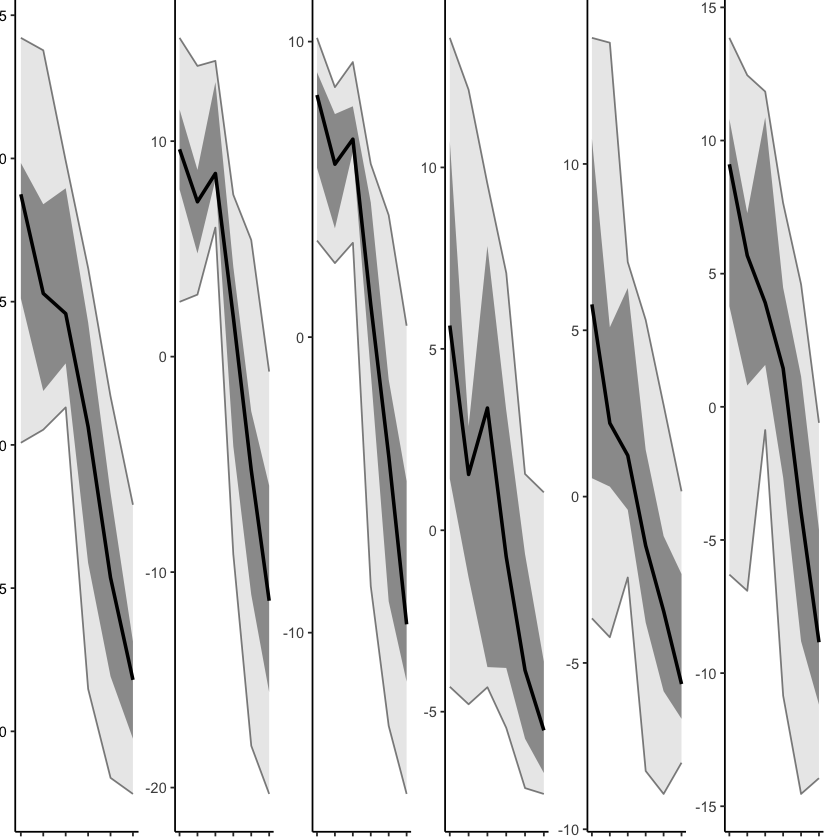

In [162]:
p_trend

#### PCA method to find Key driven proteins

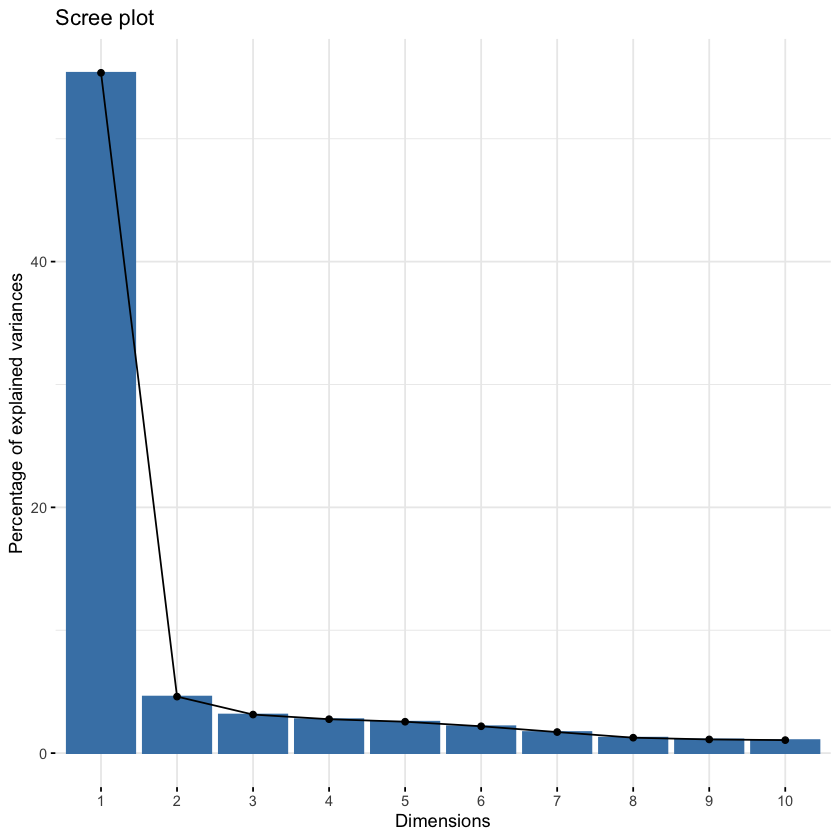

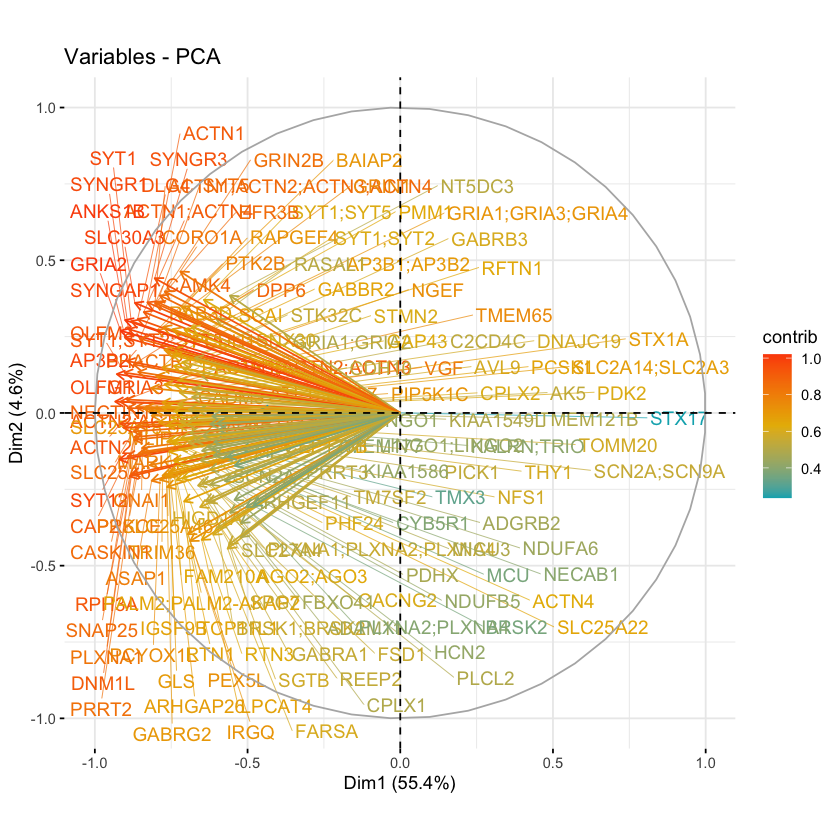

In [194]:
protein_intens_cluster <- protein_intensity_combat[sig_index[which(protein_clust$clust == 2)],]
cluster.pca <- prcomp(t(protein_intens_cluster), scale = TRUE)
fviz_eig(cluster.pca)
fviz_pca_var(cluster.pca,
             col.var = "contrib", # Color by contributions to the PC
             #select.var = list(contrib=50),
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE     # Avoid text overlapping
             )

#### Test code, maybe cannot use anymore!

In [167]:
GoID_p <- NULL
for(i in 2:2){
    if(class(ont_BP_perclust[[i]]) == "NULL")
        next
    temp <- data.frame(term = ont_BP_perclust[[i]]$GO.ID,
                       p = ont_BP_perclust[[i]]$Fisher, stringsAsFactors = FALSE)
    
    GoID_p <- rbind(GoID_p, temp)
}

In [168]:
dim(GoID_p)

[1] 79  2

In [165]:
GoID_p <- GoID_p[-which(GoID_p$term %in% c("GO:0051186" , "GO:0051187", "GO:0051188", "GO:0006733")), ]

In [169]:
write.table(GoID_p, file = "Python_workstation/GoID_p.txt", col.names = FALSE,
                    row.names = FALSE, quote = FALSE, sep = " ")

In [170]:
## use python calculate similarity matrix

In [172]:
lin_sim_matrix <- read.table('Python_workstation/lin_sim_matrix.txt', header =TRUE,
                                                    stringsAsFactors=F, sep = ",")

In [173]:
rownames(lin_sim_matrix) <- str_replace(colnames(lin_sim_matrix), "GO.", "GO:")

In [174]:
#lin_sim_matrix <- lin_sim_matrix[-grep("\\.", rownames(lin_sim_matrix)), ][, -grep("\\.", rownames(lin_sim_matrix))]

In [175]:
colnames(lin_sim_matrix) <- rownames(lin_sim_matrix)

In [176]:
dim(lin_sim_matrix)

[1] 79 79

In [177]:
lin_sim_matrix

GO:0007268 GO:0098916 GO:0099537 GO:0099536 GO:0007267 GO:0050804
GO:0007268 1.000      0.999      0.989      0.984      0.856      0.951     
GO:0098916 0.999      1.000      0.991      0.985      0.857      0.950     
GO:0099537 0.989      0.991      1.000      0.994      0.867      0.941     
GO:0099536 0.984      0.985      0.994      1.000      0.872      0.935     
GO:0007267 0.856      0.857      0.867      0.872      1.000      0.809     
GO:0050804 0.951      0.950      0.941      0.935      0.809      1.000     
GO:0099177 0.935      0.936      0.944      0.939      0.812      0.996     
GO:0006811 0.061      0.061      0.062      0.062      0.072      0.058     
GO:0060078 0.042      0.042      0.042      0.042      0.047      0.185     
GO:2000310 0.373      0.373      0.375      0.377      0.409      0.454     
GO:0048167 0.832      0.831      0.822      0.817      0.696      0.880     
GO:0035235 0.420      0.420      0.424      0.425      0.466      0.404     
GO:1900449 0.406      0.406      0.409      0.411      0.449      0.493     
GO:0050806 0.841      0.840      0.831      0.825      0.704      0.889     
GO:0050877 0.050      0.050      0.050      0.050      0.057      0.047     
GO:0023061 0.786      0.787      0.794      0.799      0.905      0.746     
GO:0031629 0.737      0.736      0.728      0.722      0.608      0.711     
GO:0099500 0.120      0.120      0.121      0.122      0.136      0.114     
GO:0099601 0.418      0.418      0.421      0.423      0.464      0.508     
GO:0097479 0.104      0.104      0.105      0.105      0.116      0.100     
GO:0034220 0.152      0.153      0.154      0.155      0.179      0.143     
GO:0007214 0.347      0.347      0.349      0.350      0.378      0.336     
GO:0010975 0.116      0.116      0.117      0.118      0.131      0.263     
GO:0007215 0.437      0.438      0.441      0.443      0.488      0.420     
GO:0006812 0.057      0.057      0.058      0.058      0.067      0.054     
GO:0042391 0.048      0.048      0.049      0.049      0.055      0.212     
GO:0051960 0.050      0.050      0.051      0.051      0.058      0.242     
GO:0007186 0.548      0.549      0.554      0.558      0.630      0.521     
GO:0098655 0.144      0.145      0.146      0.147      0.168      0.136     
GO:0099565 0.854      0.853      0.843      0.838      0.716      0.818     
...        ...        ...        ...        ...        ...        ...       
GO:0099643 0.870      0.871      0.878      0.882      0.758      0.831     
GO:2000463 0.684      0.683      0.675      0.670      0.560      0.729     
GO:0099504 0.734      0.734      0.740      0.744      0.128      0.702     
GO:0000902 0.050      0.050      0.051      0.051      0.058      0.048     
GO:1904062 0.125      0.125      0.127      0.127      0.143      0.282     
GO:0046879 0.724      0.725      0.732      0.736      0.825      0.690     
GO:0050767 0.127      0.127      0.128      0.129      0.145      0.286     
GO:0043269 0.052      0.052      0.053      0.053      0.060      0.250     
GO:0009914 0.048      0.048      0.049      0.049      0.055      0.213     
GO:0030001 0.053      0.053      0.054      0.054      0.061      0.050     
GO:0031646 0.038      0.038      0.038      0.039      0.042      0.185     
GO:0031338 0.103      0.103      0.104      0.104      0.115      0.234     
GO:0032989 0.127      0.127      0.128      0.129      0.145      0.121     
GO:0045956 0.093      0.093      0.094      0.094      0.102      0.212     
GO:0060284 0.133      0.133      0.135      0.135      0.153      0.299     
GO:0090276 0.635      0.636      0.641      0.644      0.711      0.609     
GO:2001257 0.113      0.113      0.114      0.114      0.127      0.255     
GO:0010817 0.051      0.052      0.052      0.052      0.059      0.226     
GO:0015800 0.042      0.042      0.042      0.042      0.047      0.040     
GO:0006906 0.123      0.123      0.124      0.125      0.140      0.117     
GO:0003

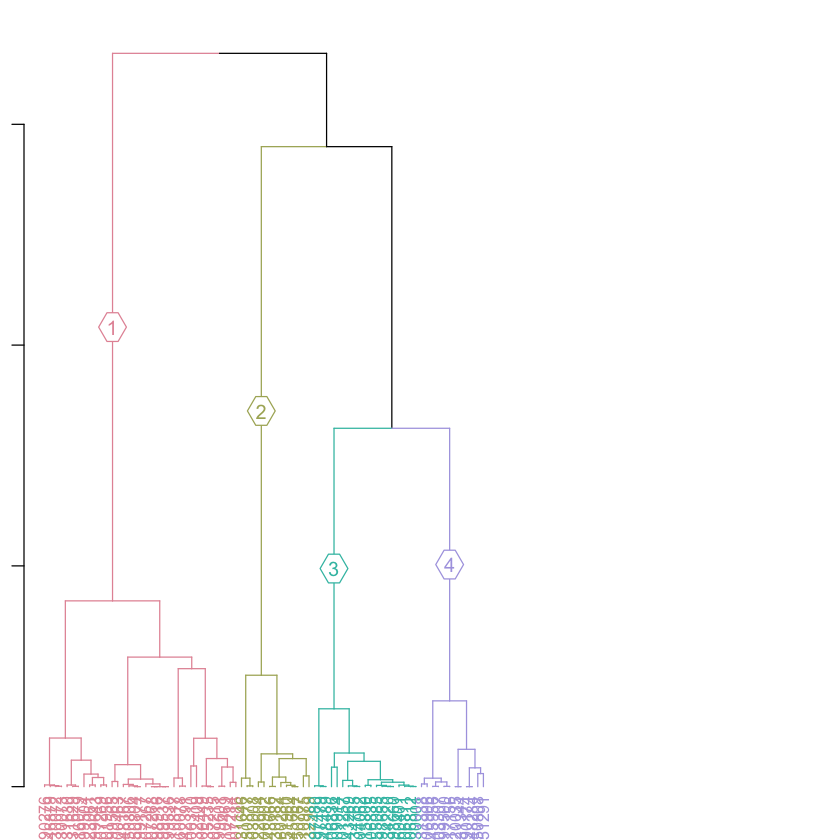

In [178]:
hc <- hclust(amap::Dist(lin_sim_matrix, 
                         method = "correlation"), method = "ward.D")

c_group <- 4 # number of clusters

dend1 <- as.dendrogram(hc)

clust <- dendextend:::cutree(dend1, k=c_group, order_clusters_as_data = FALSE)

lbls <- unique(clust)

dend1 <- color_branches(dend1, k = c_group, groupLabels = lbls, col = rainbow_hcl) # add color to the lines
dend1 <- color_labels(dend1, k = c_group, col = rainbow_hcl)   # add color to the labels

col_labels <- get_leaves_branches_col(dend1)
col_labels <- col_labels[order(order.dendrogram(dend1))]


dend1 <- set(dend1, "labels_cex", 0.8)
par(mar = c(1,1,1,14))
#print(labels(dend1))
plot(dend1) # use side = T to horiz mirror if needed

In [179]:
Goterm_clust_name <- data.frame(term = names(clust), 
                                cluster = clust, stringsAsFactors = FALSE)

Goterm_clust_name$term_name <- as.character(lapply(Goterm_clust_name$term, Term))

In [180]:
Goterm_clust_name

term       cluster
GO:0090276 GO:0090276 1      
GO:0046879 GO:0046879 1      
GO:0030072 GO:0030072 1      
GO:0030073 GO:0030073 1      
GO:0031630 GO:0031630 1      
GO:0031629 GO:0031629 1      
GO:0016079 GO:0016079 1      
GO:0099504 GO:0099504 1      
GO:0023061 GO:0023061 1      
GO:0099643 GO:0099643 1      
GO:0007269 GO:0007269 1      
GO:0001956 GO:0001956 1      
GO:0099565 GO:0099565 1      
GO:2000463 GO:2000463 1      
GO:0048167 GO:0048167 1      
GO:0050806 GO:0050806 1      
GO:0050804 GO:0050804 1      
GO:0099177 GO:0099177 1      
GO:0007267 GO:0007267 1      
GO:0007268 GO:0007268 1      
GO:0098916 GO:0098916 1      
GO:0099537 GO:0099537 1      
GO:0099536 GO:0099536 1      
GO:0010817 GO:0010817 1      
GO:0060078 GO:0060078 1      
GO:0042391 GO:0042391 1      
GO:2000310 GO:2000310 1      
GO:0032409 GO:0032409 1      
GO:1900449 GO:1900449 1      
GO:0035235 GO:0035235 1      
...        ...        ...    
GO:0097479 GO:0097479 3      
GO:0048489 GO:0048489 3      
GO:0006836 GO:0006836 3      
GO:0009914 GO:0009914 3      
GO:2001257 GO:2001257 3      
GO:0043269 GO:0043269 3      
GO:0034765 GO:0034765 3      
GO:1904062 GO:1904062 3      
GO:0015800 GO:0015800 3      
GO:0006835 GO:0006835 3      
GO:0055085 GO:0055085 3      
GO:0098655 GO:0098655 3      
GO:0034220 GO:0034220 3      
GO:0098660 GO:0098660 3      
GO:0060401 GO:0060401 3      
GO:0006811 GO:0006811 3      
GO:0006812 GO:0006812 3      
GO:0030001 GO:0030001 3      
GO:0031338 GO:0031338 4      
GO:0006906 GO:0006906 4      
GO:0045956 GO:0045956 4      
GO:1903307 GO:1903307 4      
GO:0099500 GO:0099500 4      
GO:0017156 GO:0017156 4      
GO:0120035 GO:0120035 4      
GO:0031344 GO:0031344 4      
GO:0090174 GO:0090174 4      
GO:0048284 GO:0048284 4      
GO:0050808 GO:0050808 4      
GO:0051291 GO:0051291 4      
           term_name                                                                
GO:0090276 regulation of peptide hormone secretion                                  
GO:0046879 hormone secretion                                                        
GO:0030072 peptide hormone secretion                                                
GO:0030073 insulin secretion                                                        
GO:0031630 regulation of synaptic vesicle fusion to presynaptic active zone membrane
GO:0031629 synaptic vesicle fusion to presynaptic active zone membrane              
GO:0016079 synaptic vesicle exocytosis                                              
GO:0099504 synaptic vesicle cycle                                                   
GO:0023061 signal release                                                           
GO:0099643 signal release from synapse                                              
GO:0007269 neurotransmitter secretion                                               
GO:0001956 positive regulation of neurotransmitter secretion                        
GO:0099565 chemical synaptic transmission, postsynaptic                             
GO:2000463 positive regulation of excitatory postsynaptic potential                 
GO:0048167 regulation of synaptic plasticity                                        
GO:0050806 positive regulation of synaptic transmission                             
GO:0050804 modulation of chemical synaptic transmission                             
GO:0099177 regulation of trans-synaptic signaling                                   
GO:0007267 cell-cell signaling                                                      
GO:0007268 chemical synaptic transmission                                           
GO:0098916 anterograde trans-synaptic signaling                                     
GO:0099537 trans-synaptic signaling                                                 
GO:0099536 synaptic signaling                                                       
GO:0010817 regulation of hormone levels                                             
GO:0060078 regulation of p

In [181]:
word_frequency_dset <- CountFrequency_words(Goterm_clust_name)

Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"


In [187]:
wordcloud2(word_frequency_dset[5])

HTML widgets cannot be represented in plain text (need html)

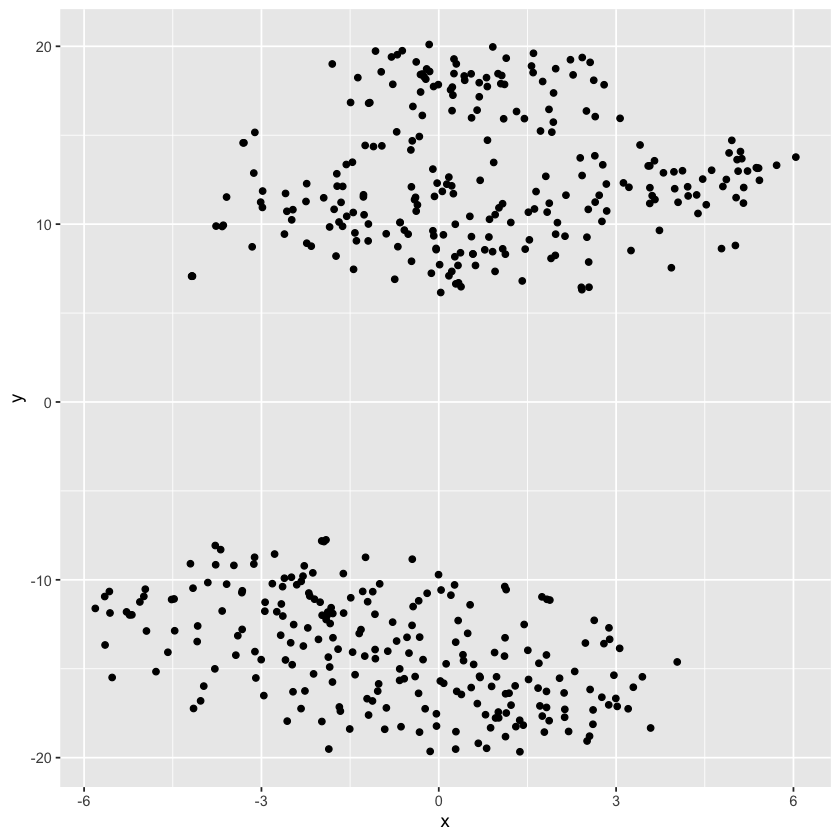

In [860]:
tsne_out <- Rtsne(protein_intens_Braak_order, perplexity = 50)
tsne_plot <- data.frame(x = tsne_out$Y[,1], y = tsne_out$Y[,2])
ggplot(tsne_plot) + geom_point(aes(x=x, y=y))

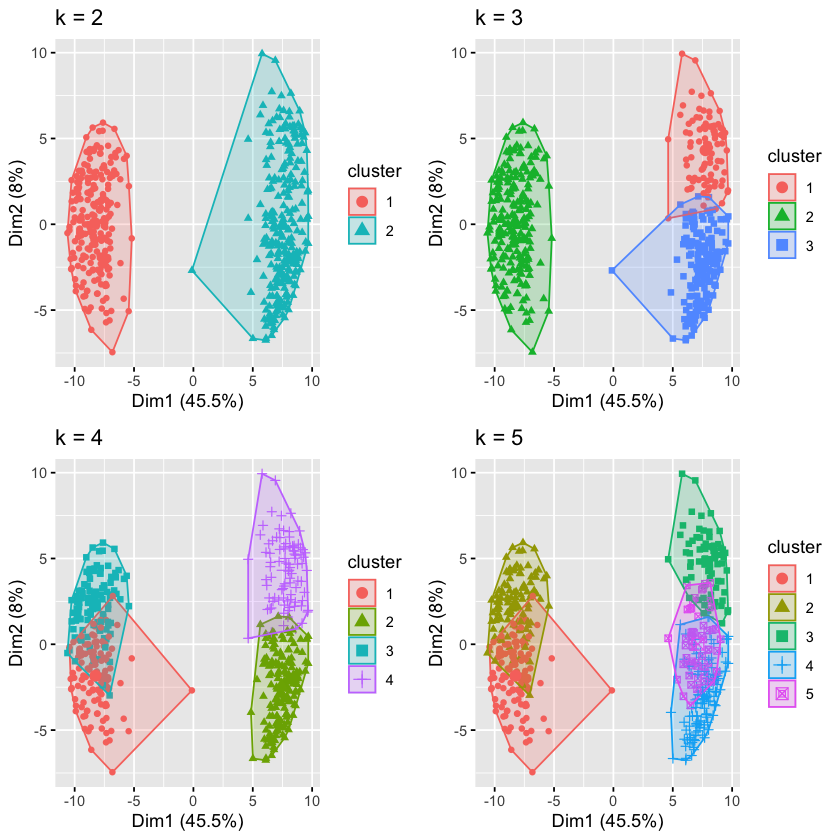

In [873]:
k2 <- kmeans(protein_intens_Braak_order, centers = 2, nstart = 25)
k3 <- kmeans(protein_intens_Braak_order, centers = 3, nstart = 25)
k4 <- kmeans(protein_intens_Braak_order, centers = 4, nstart = 25)
k5 <- kmeans(protein_intens_Braak_order, centers = 5, nstart = 25)

# plots to compare
p1 <- fviz_cluster(k2, geom = "point", data = protein_intens_Braak_order) + ggtitle("k = 2")
p2 <- fviz_cluster(k3, geom = "point",  data = protein_intens_Braak_order) + ggtitle("k = 3")
p3 <- fviz_cluster(k4, geom = "point",  data = protein_intens_Braak_order) + ggtitle("k = 4")
p4 <- fviz_cluster(k5, geom = "point",  data = protein_intens_Braak_order) + ggtitle("k = 5")

grid.arrange(p1, p2, p3, p4, nrow = 2)

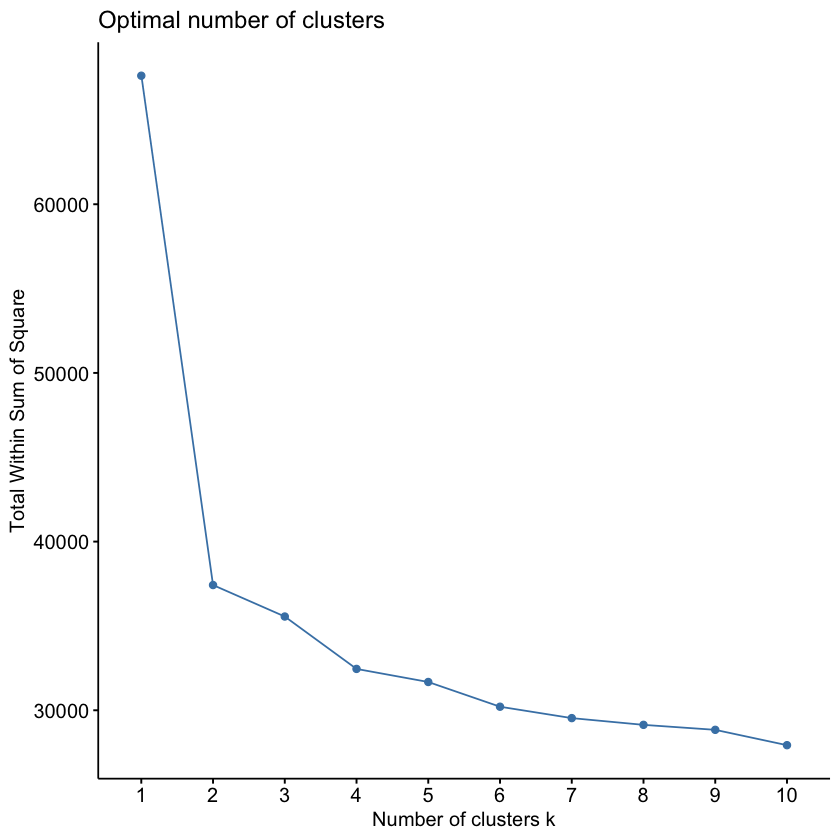

In [874]:
set.seed(123)

fviz_nbclust(protein_intens_Braak_order, kmeans, method = "wss")

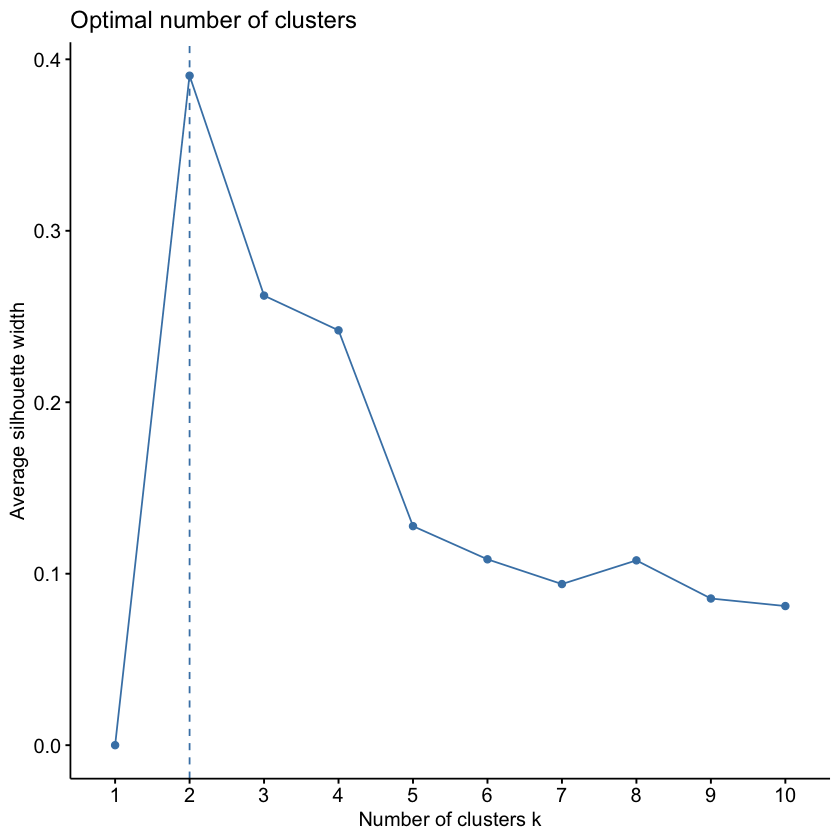

In [875]:
fviz_nbclust(protein_intens_Braak_order, kmeans, method = "silhouette")

In [876]:
gap_stat <- clusGap(protein_intens_Braak_order, FUN = kmeans, nstart = 25,
                    K.max = 10, B = 50)

Warning message:
“did not converge in 10 iterations”

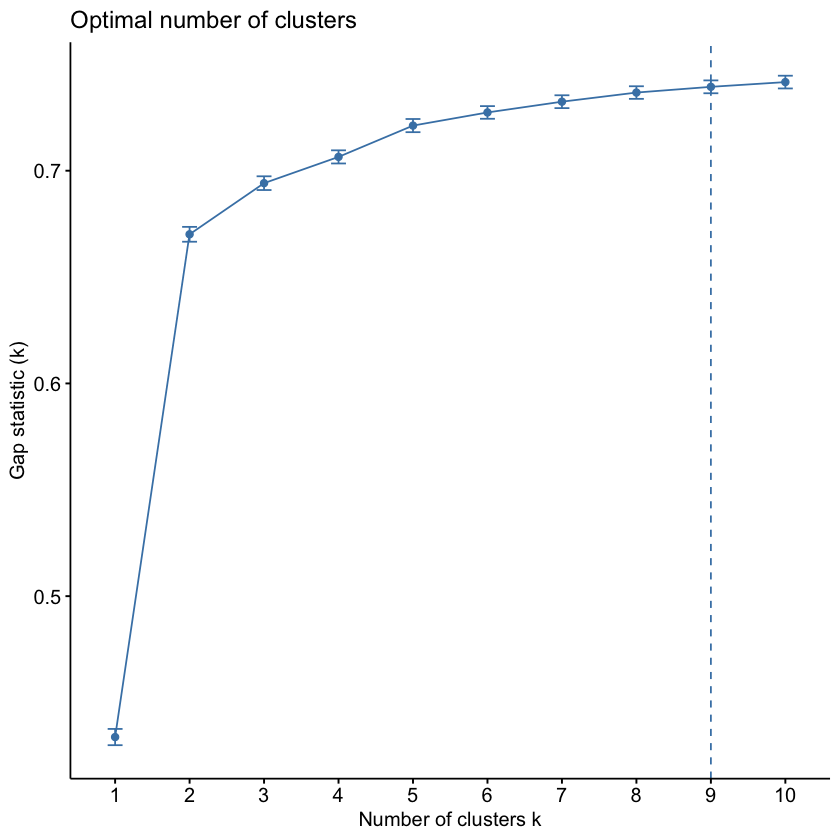

In [877]:
fviz_gap_stat(gap_stat)

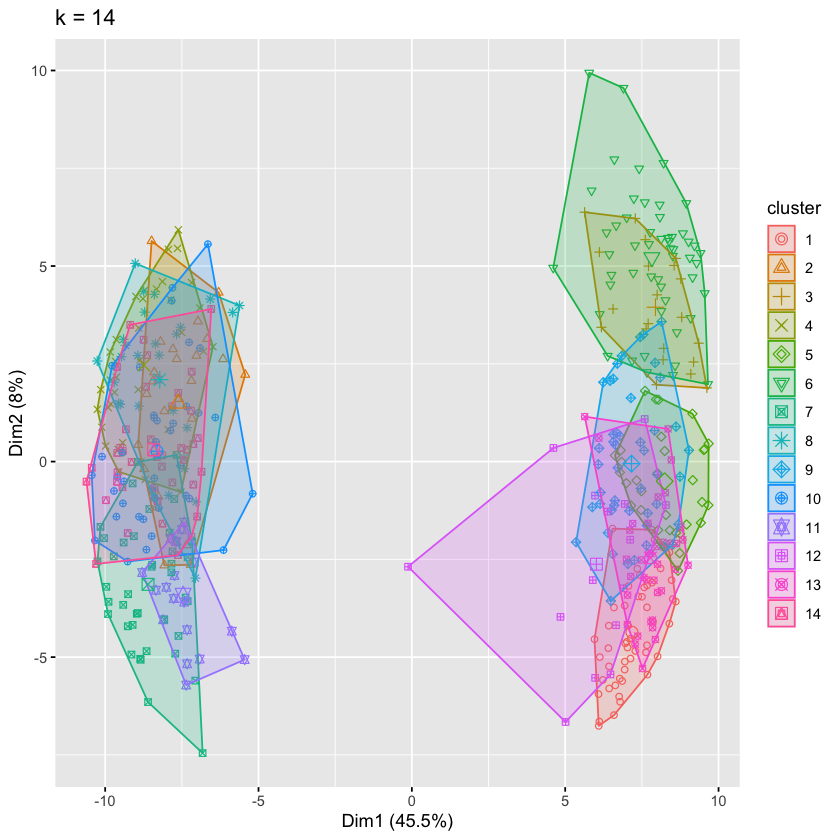

In [888]:
k <- kmeans(protein_intens_Braak_order, centers = 14, nstart = 25)

fviz_cluster(k, geom = "point", data = protein_intens_Braak_order) + ggtitle("k = 14")

In [889]:
k

K-means clustering with 14 clusters of sizes 50, 24, 21, 37, 31, 52, 41, 28, 47, 39, 19, 16, 37, 42

Cluster means:
            I          I          I          I          I           I
1  -1.0332631 -0.3118996 -0.9049964 -1.0909345 -0.5929925  0.20763918
2   0.7931988  0.2715150  1.0642127  0.8063906  0.1460935  0.92978590
3  -0.8343104 -0.8274762 -0.5647728 -0.5327571 -0.5773004 -1.42310295
4   1.0366623  0.8898956  0.9119918  0.9394898  0.7766258  0.29878398
5  -0.8649347 -0.8868066 -0.6899920 -0.6554328 -0.4916716 -0.32609383
6  -0.3793830 -1.3122539 -0.2725748 -0.3645786 -1.0396635 -1.57628209
7   1.0267680  1.2516104  0.6007881  0.4549038  0.7867079  0.41726480
8   0.8758657  0.4388235  0.5684329  0.6192269  0.1150491  0.78723359
9  -1.1946985 -0.4402937 -1.3257522 -0.4992373  0.2136082 -0.26741103
10  0.9302353  0.8235792  0.8607002  0.9577961  0.4034425  0.23070171
11  0.8293629  0.7880987  0.9366835  0.6465026  0.2089236  0.67803553
12 -1.0065076 -0.1779779 -1.0433254 -1.23154

In [890]:
for (i in 1:14){
    cat("This is cluster", i, sep = "", end = ".\n")
    cat("The number of protein in this cluster is", length(which(k$cluster == i)), sep = " ", end = ".\n")
    protein_list <- unique(protein_clust[k$cluster == i,]$gene)
    if(length(protein_list) < 1){
        cat("The number of valide protein in this cluster is", length(protein_list), sep = " ", end = ".\n")
        next
    }
    geneList <- factor(as.integer(backgroud_protein_list %in% protein_list))
    names(geneList) <- backgroud_protein_list
    
    allRes <- GOterm_query_test_table(protein_list, geneList, "BP")
    
    if(class(allRes) == 'character')
        print(allRes)
    else{
        ont_BP_perclust[[i]] <- allRes
        write.table(allRes, 
                    file = paste("Temp_results/GOterm_orig_union_kmean_14c_BH/GOterm_BP_for_", "Cluster_", i, ".txt", sep = ""),
                    row.names = FALSE, quote = FALSE, sep = "\t")
    }
}

This is cluster1.
The number of protein in this cluster is 50 .



Building most specific GOs .....
	( 6593 GO terms found. )

Build GO DAG topology ..........
	( 10629 GO terms and 24820 relations. )

Annotating nodes ...............
	( 3120 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1362 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster2.
The number of protein in this cluster is 24 .



Building most specific GOs .....
	( 6593 GO terms found. )

Build GO DAG topology ..........
	( 10629 GO terms and 24820 relations. )

Annotating nodes ...............
	( 3120 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 560 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster3.
The number of protein in this cluster is 21 .



Building most specific GOs .....
	( 6593 GO terms found. )

Build GO DAG topology ..........
	( 10629 GO terms and 24820 relations. )

Annotating nodes ...............
	( 3120 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 963 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "Can not find significant GO pathway in this cluster!"
This is cluster4.
The number of protein in this cluster is 37 .



Building most specific GOs .....
	( 6593 GO terms found. )

Build GO DAG topology ..........
	( 10629 GO terms and 24820 relations. )

Annotating nodes ...............
	( 3120 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1143 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster5.
The number of protein in this cluster is 31 .



Building most specific GOs .....
	( 6593 GO terms found. )

Build GO DAG topology ..........
	( 10629 GO terms and 24820 relations. )

Annotating nodes ...............
	( 3120 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1199 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster6.
The number of protein in this cluster is 52 .



Building most specific GOs .....
	( 6593 GO terms found. )

Build GO DAG topology ..........
	( 10629 GO terms and 24820 relations. )

Annotating nodes ...............
	( 3120 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 2245 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster7.
The number of protein in this cluster is 41 .



Building most specific GOs .....
	( 6593 GO terms found. )

Build GO DAG topology ..........
	( 10629 GO terms and 24820 relations. )

Annotating nodes ...............
	( 3120 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1328 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster8.
The number of protein in this cluster is 28 .



Building most specific GOs .....
	( 6593 GO terms found. )

Build GO DAG topology ..........
	( 10629 GO terms and 24820 relations. )

Annotating nodes ...............
	( 3120 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 671 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster9.
The number of protein in this cluster is 47 .



Building most specific GOs .....
	( 6593 GO terms found. )

Build GO DAG topology ..........
	( 10629 GO terms and 24820 relations. )

Annotating nodes ...............
	( 3120 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1602 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "Can not find significant GO pathway in this cluster!"
This is cluster10.
The number of protein in this cluster is 39 .



Building most specific GOs .....
	( 6593 GO terms found. )

Build GO DAG topology ..........
	( 10629 GO terms and 24820 relations. )

Annotating nodes ...............
	( 3120 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1624 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster11.
The number of protein in this cluster is 19 .



Building most specific GOs .....
	( 6593 GO terms found. )

Build GO DAG topology ..........
	( 10629 GO terms and 24820 relations. )

Annotating nodes ...............
	( 3120 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 749 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "Can not find significant GO pathway in this cluster!"
This is cluster12.
The number of protein in this cluster is 16 .



Building most specific GOs .....
	( 6593 GO terms found. )

Build GO DAG topology ..........
	( 10629 GO terms and 24820 relations. )

Annotating nodes ...............
	( 3120 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1209 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "Can not find significant GO pathway in this cluster!"
This is cluster13.
The number of protein in this cluster is 37 .



Building most specific GOs .....
	( 6593 GO terms found. )

Build GO DAG topology ..........
	( 10629 GO terms and 24820 relations. )

Annotating nodes ...............
	( 3120 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1569 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster14.
The number of protein in this cluster is 42 .



Building most specific GOs .....
	( 6593 GO terms found. )

Build GO DAG topology ..........
	( 10629 GO terms and 24820 relations. )

Annotating nodes ...............
	( 3120 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1193 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "Can not find significant GO pathway in this cluster!"


In [946]:
GoID_cluster <- NULL
index <- 1
for(i in 1:c_group){
    if(class(ont_BP_perclust[[i]]) == "NULL")
        next
    temp <- data.frame(term = ont_BP_perclust[[i]]$GO.ID,
                       cluster = rep(index, length(ont_BP_perclust[[i]]$GO.ID)), stringsAsFactors = FALSE)
    index <- index + 1
    
    GoID_cluster <- rbind(GoID_cluster, temp)
}

In [947]:
dim(GoID_cluster)

[1] 282   2

In [948]:
GoID_cluster$term_name <- as.character(lapply(GoID_cluster$term, Term))

In [949]:
dim(GoID_cluster)

[1] 282   3

In [950]:
word_frequency_dset <- CountFrequency_words(GoID_cluster)

Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"


In [951]:
wordcloud2(word_frequency_dset[2])

HTML widgets cannot be represented in plain text (need html)

In [492]:
GoID <- NULL
for(i in 1:c_group){
    GoID <- c(GoID, ont_BP_perclust[[i]]$GO.ID)
}

In [493]:
GoID <- unique(GoID)

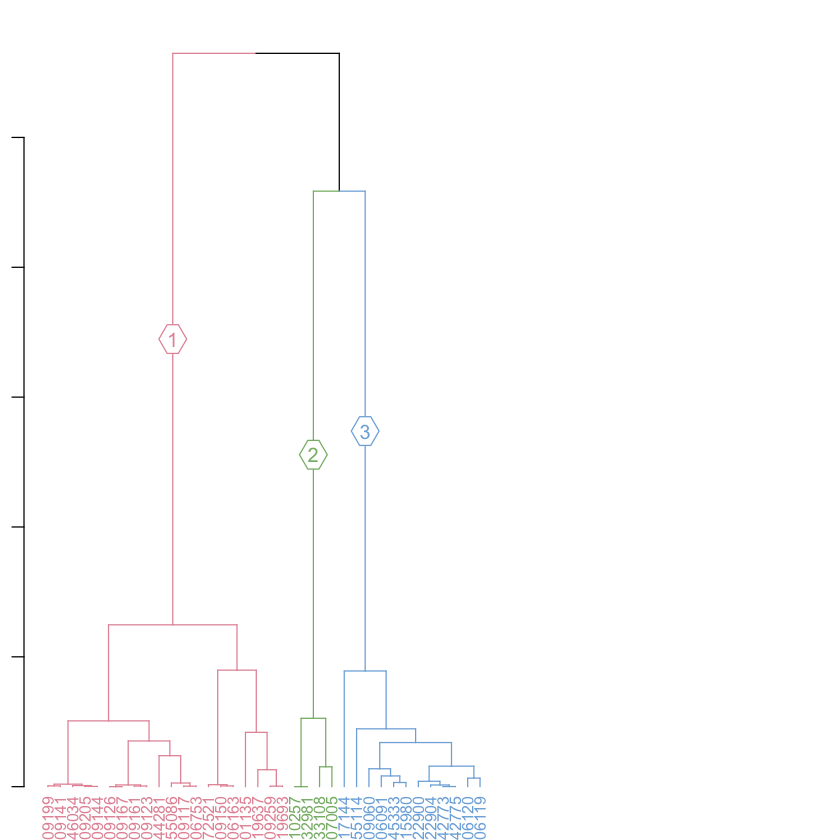

In [569]:
Sim_matrix <- mgoSim(ont_BP_perclust[[2]]$GO.ID, ont_BP_perclust[[2]]$GO.ID, semData=hsGO_BP, measure="Lin", combine=NULL)
#index_NA <- as.numeric(which(is.na(Sim_matrix[1,])))
#Sim_matrix <- Sim_matrix[-index_NA, -index_NA]

hc <- hclust(as.dist(1-Sim_matrix), method = "ward.D")

c_group <- 3 # number of clusters

dend1 <- as.dendrogram(hc)

clust <- dendextend:::cutree(dend1, k=c_group, order_clusters_as_data = FALSE)

lbls <- unique(clust)

dend1 <- color_branches(dend1, k = c_group, groupLabels = lbls, col = rainbow_hcl) # add color to the lines
dend1 <- color_labels(dend1, k = c_group, col = rainbow_hcl)   # add color to the labels

col_labels <- get_leaves_branches_col(dend1)
col_labels <- col_labels[order(order.dendrogram(dend1))]


dend1 <- set(dend1, "labels_cex", 0.8)
par(mar = c(1,1,1,14))
#print(labels(dend1))
plot(dend1) # use side = T to horiz mirror if needed

Goterm_clust_name <- data.frame(term = names(clust), 
                                cluster = clust, stringsAsFactors = FALSE)

Goterm_clust_name$term_name <- as.character(lapply(Goterm_clust_name$term, Term))

In [570]:
Goterm_clust_name

term       cluster
GO:0009199 GO:0009199 1      
GO:0009141 GO:0009141 1      
GO:0046034 GO:0046034 1      
GO:0009205 GO:0009205 1      
GO:0009144 GO:0009144 1      
GO:0009126 GO:0009126 1      
GO:0009167 GO:0009167 1      
GO:0009161 GO:0009161 1      
GO:0009123 GO:0009123 1      
GO:0044281 GO:0044281 1      
GO:0055086 GO:0055086 1      
GO:0009117 GO:0009117 1      
GO:0006753 GO:0006753 1      
GO:0072521 GO:0072521 1      
GO:0009150 GO:0009150 1      
GO:0006163 GO:0006163 1      
GO:1901135 GO:1901135 1      
GO:0019637 GO:0019637 1      
GO:0009259 GO:0009259 1      
GO:0019693 GO:0019693 1      
GO:0010257 GO:0010257 2      
GO:0032981 GO:0032981 2      
GO:0033108 GO:0033108 2      
GO:0007005 GO:0007005 2      
GO:0017144 GO:0017144 3      
GO:0055114 GO:0055114 3      
GO:0009060 GO:0009060 3      
GO:0006091 GO:0006091 3      
GO:0045333 GO:0045333 3      
GO:0015980 GO:0015980 3      
GO:0022900 GO:0022900 3      
GO:0022904 GO:0022904 3      
GO:0042773 GO:0042773 3      
GO:0042775 GO:0042775 3      
GO:0006120 GO:0006120 3      
GO:0006119 GO:0006119 3      
           term_name                                             
GO:0009199 ribonucleoside triphosphate metabolic process         
GO:0009141 nucleoside triphosphate metabolic process             
GO:0046034 ATP metabolic process                                 
GO:0009205 purine ribonucleoside triphosphate metabolic process  
GO:0009144 purine nucleoside triphosphate metabolic process      
GO:0009126 purine nucleoside monophosphate metabolic process     
GO:0009167 purine ribonucleoside monophosphate metabolic process 
GO:0009161 ribonucleoside monophosphate metabolic process        
GO:0009123 nucleoside monophosphate metabolic process            
GO:0044281 small molecule metabolic process                      
GO:0055086 nucleobase-containing small molecule metabolic process
GO:0009117 nucleotide metabolic process                          
GO:0006753 nucleoside phosphate metabolic process                
GO:0072521 purine-containing compound metabolic process          
GO:0009150 purine ribonucleotide metabolic process               
GO:0006163 purine nucleotide metabolic process                   
GO:1901135 carbohydrate derivative metabolic process             
GO:0019637 organophosphate metabolic process                     
GO:0009259 ribonucleotide metabolic process                      
GO:0019693 ribose phosphate metabolic process                    
GO:0010257 NADH dehydrogenase complex assembly                   
GO:0032981 mitochondrial respiratory chain complex I assembly    
GO:0033108 mitochondrial respiratory chain complex assembly      
GO:0007005 mitochondrion organization                            
GO:0017144 drug metabolic process                                
GO:0055114 oxidation-reduction process                           
GO:0009060 aerobic respiration                                   
GO:0006091 generation of precursor metabolites and energy        
GO:0045333 cellular respiration                                  
GO:0015980 energy derivation by oxidation of organic compounds   
GO:0022900 electron transport chain                              
GO:0022904 respiratory electron transport chain                  
GO:0042773 ATP synthesis coupled electron transport              
GO:0042775 mitochondrial ATP synthesis coupled electron transport
GO:0006120 mitochondrial electron transport, NADH to ubiquinone  
GO:0006119 oxidative phosphorylation

In [571]:
Goterm_clust_name$cluster <- 1

In [572]:
word_frequency_dset <- CountFrequency_words(Goterm_clust_name)

Joining, by = "word"
Joining, by = "word"


In [574]:
#Goterm_clust_name

In [555]:
wordcloud_plot <- list()

In [501]:
for(i in 1:c_group){
    wordcloud_plot[[i]] <- wordcloud2(word_frequency_dset[[i+1]])
}

In [575]:
wordcloud2(word_frequency_dset[2])

HTML widgets cannot be represented in plain text (need html)

In [ ]:
wordcloud2(word_frequency_dset[2])

In [45]:
for (i in 1:c_group){
    cat("This is cluster", i, sep = "", end = ".\n")
    cat("The number of protein in this cluster is", length(which(protein_clust$clust == i)), sep = " ", end = ".\n")
    protein_list <- unique(protein_clust[protein_clust$clust == i,]$gene)
    if(length(protein_list) < 1){
        cat("The number of valide protein in this cluster is", length(protein_list), sep = " ", end = ".\n")
        next
    }

    geneList <- factor(as.integer(backgroud_protein_list %in% protein_list))
    names(geneList) <- backgroud_protein_list
    
    allRes <- GOterm_query_test_table(geneList, "MF")
    
    if(class(allRes) == 'character')
        print(allRes)
    else{
        write.table(allRes, 
                    file = paste("Temp_results/GOterm_results_correlationship/GOterm_MF_for_", "Cluster_", i, ".txt", sep = ""),
                    row.names = FALSE, quote = FALSE, sep = "\t")
    }
}

This is cluster1.
The number of protein in this cluster is 74 .



Building most specific GOs .....
	( 2051 GO terms found. )

Build GO DAG topology ..........
	( 2550 GO terms and 3310 relations. )

Annotating nodes ...............
	( 3101 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 289 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster2.
The number of protein in this cluster is 49 .



Building most specific GOs .....
	( 2051 GO terms found. )

Build GO DAG topology ..........
	( 2550 GO terms and 3310 relations. )

Annotating nodes ...............
	( 3101 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 257 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "Can not find significant GO pathway in this cluster!"
This is cluster3.
The number of protein in this cluster is 8 .



Building most specific GOs .....
	( 2051 GO terms found. )

Build GO DAG topology ..........
	( 2550 GO terms and 3310 relations. )

Annotating nodes ...............
	( 3101 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 96 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "Can not find significant GO pathway in this cluster!"
This is cluster4.
The number of protein in this cluster is 99 .



Building most specific GOs .....
	( 2051 GO terms found. )

Build GO DAG topology ..........
	( 2550 GO terms and 3310 relations. )

Annotating nodes ...............
	( 3101 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 339 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster5.
The number of protein in this cluster is 52 .



Building most specific GOs .....
	( 2051 GO terms found. )

Build GO DAG topology ..........
	( 2550 GO terms and 3310 relations. )

Annotating nodes ...............
	( 3101 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 211 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster6.
The number of protein in this cluster is 49 .



Building most specific GOs .....
	( 2051 GO terms found. )

Build GO DAG topology ..........
	( 2550 GO terms and 3310 relations. )

Annotating nodes ...............
	( 3101 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 235 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster7.
The number of protein in this cluster is 70 .



Building most specific GOs .....
	( 2051 GO terms found. )

Build GO DAG topology ..........
	( 2550 GO terms and 3310 relations. )

Annotating nodes ...............
	( 3101 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 263 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster8.
The number of protein in this cluster is 37 .



Building most specific GOs .....
	( 2051 GO terms found. )

Build GO DAG topology ..........
	( 2550 GO terms and 3310 relations. )

Annotating nodes ...............
	( 3101 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 188 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster9.
The number of protein in this cluster is 46 .



Building most specific GOs .....
	( 2051 GO terms found. )

Build GO DAG topology ..........
	( 2550 GO terms and 3310 relations. )

Annotating nodes ...............
	( 3101 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 235 nontrivial nodes
		 parameters: 
			 test statistic: fisher


In [46]:
for (i in 1:c_group){
    cat("This is cluster", i, sep = "", end = ".\n")
    cat("The number of protein in this cluster is", length(which(protein_clust$clust == i)), sep = " ", end = ".\n")
    protein_list <- unique(protein_clust[protein_clust$clust == i,]$gene)
    if(length(protein_list) < 1){
        cat("The number of valide protein in this cluster is", length(protein_list), sep = " ", end = ".\n")
        next
    }

    geneList <- factor(as.integer(backgroud_protein_list %in% protein_list))
    names(geneList) <- backgroud_protein_list
    
    allRes <- GOterm_query_test_table(geneList, "CC")
    
    if(class(allRes) == 'character')
        print(allRes)
    else{
        write.table(allRes, 
                    file = paste("Temp_results/GOterm_results_correlationship/GOterm_CC_for_", "Cluster_", i, ".txt", sep = ""),
                    row.names = FALSE, quote = FALSE, sep = "\t")
    }
}

This is cluster1.
The number of protein in this cluster is 74 .



Building most specific GOs .....
	( 1136 GO terms found. )

Build GO DAG topology ..........
	( 1429 GO terms and 2740 relations. )

Annotating nodes ...............
	( 3176 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 353 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster2.
The number of protein in this cluster is 49 .



Building most specific GOs .....
	( 1136 GO terms found. )

Build GO DAG topology ..........
	( 1429 GO terms and 2740 relations. )

Annotating nodes ...............
	( 3176 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 311 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster3.
The number of protein in this cluster is 8 .



Building most specific GOs .....
	( 1136 GO terms found. )

Build GO DAG topology ..........
	( 1429 GO terms and 2740 relations. )

Annotating nodes ...............
	( 3176 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 103 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "Can not find significant GO pathway in this cluster!"
This is cluster4.
The number of protein in this cluster is 99 .



Building most specific GOs .....
	( 1136 GO terms found. )

Build GO DAG topology ..........
	( 1429 GO terms and 2740 relations. )

Annotating nodes ...............
	( 3176 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 362 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster5.
The number of protein in this cluster is 52 .



Building most specific GOs .....
	( 1136 GO terms found. )

Build GO DAG topology ..........
	( 1429 GO terms and 2740 relations. )

Annotating nodes ...............
	( 3176 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 270 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster6.
The number of protein in this cluster is 49 .



Building most specific GOs .....
	( 1136 GO terms found. )

Build GO DAG topology ..........
	( 1429 GO terms and 2740 relations. )

Annotating nodes ...............
	( 3176 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 217 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster7.
The number of protein in this cluster is 70 .



Building most specific GOs .....
	( 1136 GO terms found. )

Build GO DAG topology ..........
	( 1429 GO terms and 2740 relations. )

Annotating nodes ...............
	( 3176 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 283 nontrivial nodes
		 parameters: 
			 test statistic: fisher


This is cluster8.
The number of protein in this cluster is 37 .



Building most specific GOs .....
	( 1136 GO terms found. )

Build GO DAG topology ..........
	( 1429 GO terms and 2740 relations. )

Annotating nodes ...............
	( 3176 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 211 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] "Can not find significant GO pathway in this cluster!"
This is cluster9.
The number of protein in this cluster is 46 .



Building most specific GOs .....
	( 1136 GO terms found. )

Build GO DAG topology ..........
	( 1429 GO terms and 2740 relations. )

Annotating nodes ...............
	( 3176 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 268 nontrivial nodes
		 parameters: 
			 test statistic: fisher


In [981]:
## cell type enrichment for each cluster
## cell type enrichment for each cluster

In [988]:
cell_name <- c("Astro", "Endo", "MG/MF", "Neurons", "Oligo")

In [989]:
table(cell_type_matrix$celltype, useNA = "ifany")


  Astro    Endo   MG/MF Neurons   Oligo missing      no 
    449      36      53     315      48      33    2622 

In [990]:
calc_cell_type_for_cluster <- function(cluster_celltype, cell_name, background){
    p_value <- NULL
    
    for(i in cell_name){
        i_in_cluster <- length(which(cluster_celltype == i))
        NotI_in_cluster <- length(cluster_celltype) - i_in_cluster
        i_out_cluster <- length(which(background == i)) - i_in_cluster
        NotI_out_cluster <- length(background) - length(which(background == i)) - NotI_in_cluster
        
        c_table <- data.frame(incluster = c(i_in_cluster, NotI_in_cluster), 
                               outcluster = c(i_out_cluster, NotI_out_cluster))
        
        p_value <- rbind(p_value, fisher.test(c_table, alternative = "greater")$p.value)
    }
    
    rownames(p_value) <- cell_name
    return(p_value)
}

In [991]:
backgroud_celltype <- cell_type_matrix[, c("genesymbol", "celltype")]
celltype_fisher_pcluster <- NULL

In [992]:
for (i in 1:c_group){
    
    
    cluster_celltype <- cell_type_matrix[sig_index[protein_clust$clust == i], ][, c("genesymbol", "celltype")]
    
    celltype_fisher_pcluster <- cbind(celltype_fisher_pcluster,
                                      calc_cell_type_for_cluster(unique(cluster_celltype)$celltype, 
                                                             cell_name, unique(backgroud_celltype)$celltype))
}

In [993]:
colnames(celltype_fisher_pcluster) <- 1:c_group

In [994]:
celltype_fisher_pcluster

1         2            3            4         5          6         
Astro   0.9918823 3.906533e-01 1.928510e-08 0.4331292 0.01288235 0.02344869
Endo    1.0000000 3.676568e-01 5.372039e-01 1.0000000 1.00000000 1.00000000
MG/MF   0.6943140 1.000000e+00 1.250988e-01 1.0000000 0.03365338 0.68476797
Neurons 0.5090902 2.785591e-11 9.994693e-01 0.8872443 0.60003476 0.90252992
Oligo   1.0000000 8.544807e-01 9.816183e-02 1.0000000 1.00000000 1.00000000

In [995]:
## correct batch number
index <- c(1, 2, 3, 5, 6)

In [957]:
index <- 1:c_group

In [996]:
celltype_fisher_pcluster <- celltype_fisher_pcluster[, index]

In [997]:
fisher_p_plot <- data.frame(value = as.numeric(as.vector(celltype_fisher_pcluster)),
                            celltype = rep(rownames(celltype_fisher_pcluster), ncol(celltype_fisher_pcluster)),
                            cluster = paste("cluster_", as.vector(sapply(1:ncol(celltype_fisher_pcluster),
                                                                 rep, nrow(celltype_fisher_pcluster))), sep =""))

In [998]:
fisher_p_plot$adj.pvalue <- p.adjust(fisher_p_plot$value, method="BH")

In [999]:
fisher_p_plot$log_p <- -log10(fisher_p_plot$adj.pvalue)

In [1000]:
fisher_p_plot$stars <- cut(fisher_p_plot$adj.pvalue, 
                           breaks=c(-Inf, 0.001, 0.01, 0.05, Inf), 
                           label=c("***", "**", "*", ""))

In [1001]:
fisher_p_plot$text_p <- fisher_p_plot$adj.pvalue
fisher_p_plot[which(fisher_p_plot$adj.pvalue >= 0.05), ]$text_p <- NA

In [1002]:
changeSciNot <- function(n) {
  output <- formatC(n, format = "e", digits = 2) #Transforms the number into scientific notation even if small
  output <- sub("e", "x10^", output) #Replace e with 10^
  output <- sub("\\+0?", "", output) #Remove + symbol and leading zeros on expoent, if > 1
  output <- sub("-0?", "-", output) #Leaves - symbol but removes leading zeros on expoent, if < 1
  output
}

In [1003]:
fisher_p_plot$text_p <- as.character(lapply(fisher_p_plot$text_p, changeSciNot))

In [1004]:
fisher_p_plot[which(fisher_p_plot$text_p == ' NA'), ]$text_p <- ""

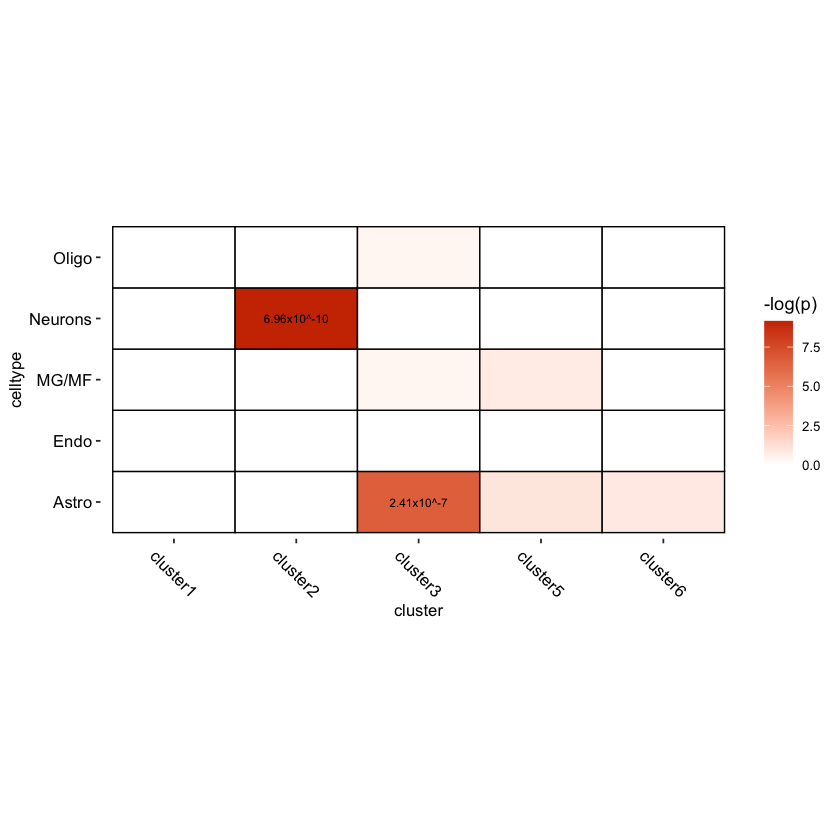

In [1005]:
#pdf("celltype_enrich_for_cluster.pdf", width = 7, height = 2.5)
p <- ggplot(aes(x=cluster, y=celltype, fill=log_p), data=fisher_p_plot)+
    geom_tile(colour = "black", size = 0.4) + 
    scale_fill_gradient(name = "-log(p)", low = "white", high = "orangered3") + 
    geom_text(aes(label=text_p), color="black", size=2.5) + 

    scale_x_discrete(breaks=paste("cluster_", seq(1, 5, 1), sep =""), 
                     labels = c("cluster1", "cluster2", "cluster3", "cluster5", 
                                "cluster6")) +

    coord_fixed(ratio=0.5) + 

    theme(panel.border = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          
          legend.text = element_text(size = font_size - font_size_add, color = "black"),
          
          axis.title.x = element_text(color = "black", 
                                      size = font_size),
          
          axis.title.y = element_text(color = "black", size = font_size),
          
          axis.text.x = element_text(size = font_size, 
                                     angle = -45,
                                     color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = font_size, color = "black"),
          
          
          #axis.line = element_line(size = 0.5, linetype = "solid",
          #                         colour = "grey")
          
          axis.line = element_blank()
          
         )
p
#dev.off()

In [379]:
median_stage_exps_ANOVA <- as.data.frame(t(apply(protein_intensity_combat[sig_index, ][, Braak_test_index], 1, 
                                                 cal_mean_for_stage, metadata[Braak_test_index, ]$fBraak)))

colnames(median_stage_exps_ANOVA) <- c("I", "II", "III", "IV", "V", "VI")

#median_stage_exps_ANOVA <- scale(median_stage_exps_ANOVA, center = TRUE, scale = TRUE)
median_stage_exps_ANOVA <- t(scale(t(median_stage_exps_ANOVA), center = TRUE, scale = TRUE))

In [380]:
cluster_trend_plots <- list()
j <- 1

In [381]:
for(i in 1:c_group){

breaks = c(0.05, 0.25, 0.5, 0.75, 0.95)
cluster_trend <- as.data.frame(t(apply(median_stage_exps_ANOVA[protein_clust$clust == i, ], 2, quantile, probs = breaks, type = 4)))

cluster_trend <- cbind(seq(1,6), cluster_trend)
colnames(cluster_trend) <- c("Braak", paste("CI_", seq(from = 0, to = 1, by = 0.25), sep = ""))

xlabels <- seq(from = 1, to = 6, by = 1)
p <- ggplot(cluster_trend, aes(x = Braak)) +
    geom_ribbon(aes(ymin=CI_0,ymax=CI_1), fill="black", alpha=0.1) +
    geom_ribbon(aes(ymin=CI_0.25,ymax=CI_0.75), fill="black", alpha=0.4) +
    
    geom_line(aes(y=CI_0.5), col="black", alpha=1, size = 1) +
    geom_line(aes(y=CI_0), col="black", alpha=0.5, size = 0.5) +
    geom_line(aes(y=CI_1), col="black", alpha=0.5, size = 0.5) +  
    #geom_line(aes(y=CI_0.25), col=color_ND, alpha=0.2, size = 0.5, linetype = "dashed") +
    #geom_line(aes(y=CI_0.75), col=color_ND, alpha=0.2, size = 0.5, linetype = "dashed") +  

    #coord_fixed(ratio=100) + 
    ggtitle(paste("Cluster", i, sep = " ")) +
    xlab("Braak stage") +
    ylab("Protein intensity (Log2)") +
    scale_x_continuous(breaks=xlabels, labels = c("I", "II", "III", "IV", "V", "VI")) +
    #scale_y_continuous(breaks=seq(0.3, 1, 0.1)) +
    
    #geom_hline(yintercept = 0.5, linetype = "solid", color = "black", size = 0.5) +

    theme(#plot.background = element_rect(),    # Background of the entire plot
          panel.background = element_rect(fill = "white"),   # Background of plotting area
          #panel.border = element_rect(),       # Border around plotting area.
                                               # fill argument should be NA
  
          #panel.grid = element_line(),         # All grid lines
          #panel.grid.major = element_line(),   # Major grid lines
          #panel.grid.minor = element_line(),   # Minor grid lines
  
          panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
                                color = "gray"), # Vertical major grid lines
          panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
                                color = "gray"), # Horizontal major grid lines
          panel.grid.minor.x = element_line(), # Vertical minor grid lines
          panel.grid.minor.y = element_line(),  # Vertical major grid lines
        
          plot.title = element_text(hjust = 0.5),
          axis.title.x = element_text(color = "black", size = 12),
          axis.title.y = element_text(color = "black", size = 12),
          
          axis.text.x = element_text(size = 12, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = 12, color = "black"),
          
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "black")
         )

cluster_trend_plots[[j]] <- p
j = j +1
    
    
}

In [382]:
p <- plot_grid(plotlist = cluster_trend_plots, ncol = 3, nrow = 2)


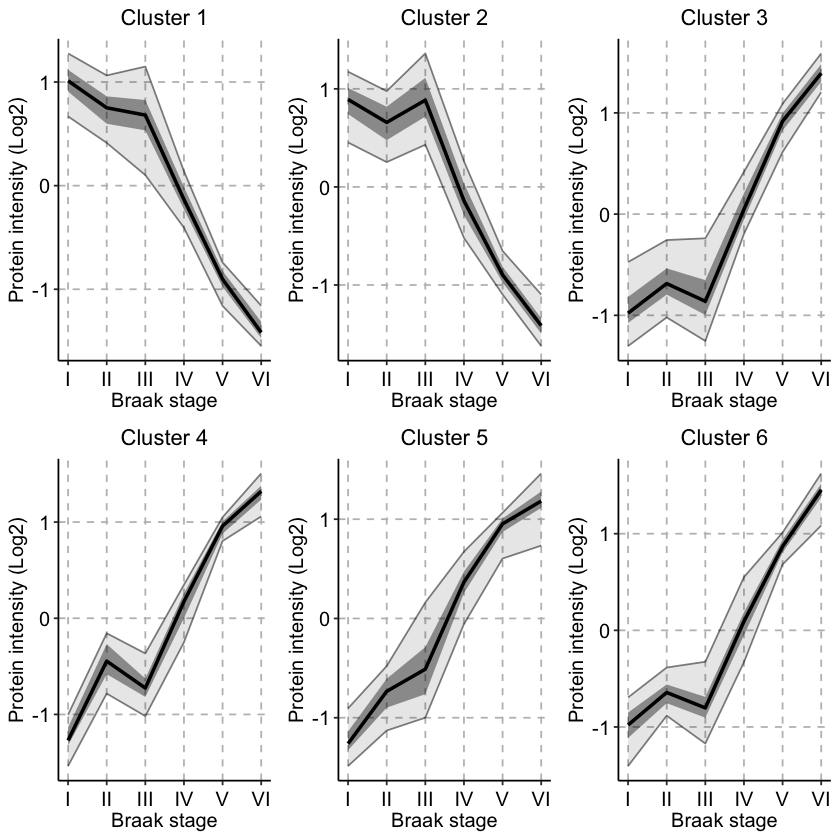

In [383]:
p

In [ ]:
save_plot("protein_trend_for_clusters.pdf", p, base_height = 10, base_width = 10)

In [90]:
pathology_related_proteins_ANOVA$`Cell type` <- cell_type_matrix$cell_type

In [59]:
pathology_related_proteins_ANOVA[clust == 1,]

p_value      adjusted_p_value effect_size
SLC12A2                           9.994069e-06 3.536210e-05     -0.4661652 
CASKIN1                           2.434744e-13 7.275589e-12     -0.5801346 
GNG2                              7.829535e-02 1.142932e-01      0.3040450 
CARNS1                            2.796582e-05 8.863322e-05      1.6932757 
FH                                5.162710e-04 1.274903e-03      0.3719604 
EFHD2                             2.030525e-04 5.441255e-04      0.9003186 
PCLO                              8.850635e-02 1.270091e-01     -0.5509621 
HSPA1A;HSPA1B                     2.231900e-09 1.903271e-08      0.6860415 
STIP1                             7.860887e-09 5.998565e-08      1.6321771 
CTNND1                            1.902536e-03 4.155662e-03     -0.1736381 
INPP5A                            1.433490e-06 6.224040e-06     -0.3990677 
SEPT11                            1.905975e-02 3.322420e-02      0.2853970 
PKP4                              2.357282e-02 4.035867e-02     -0.2573492 
RYR2                              2.809494e-04 7.335214e-04     -0.2589889 
PTPRK                             7.962166e-03 1.527921e-02      0.6529373 
CAMKV                             6.990143e-02 1.037002e-01     -0.1298362 
BCR                               1.489266e-01 1.992412e-01      0.1401123 
NDUFV2                            4.387341e-02 6.937032e-02     -0.2295298 
IDH3B                             3.669748e-01 4.318208e-01      0.2042894 
FMNL2                             1.809224e-05 5.996990e-05      0.7354330 
SYT12                             3.499331e-22 6.221811e-19     -1.1742794 
GRHPR                             2.971477e-09 2.474607e-08      1.4331183 
CSE1L                             2.131778e-06 8.876584e-06      0.4253118 
DNAJC6                            2.369968e-15 1.359291e-13     -0.3278915 
DUSP3                             4.300290e-02 6.816435e-02      0.4116810 
VDAC3                             1.208399e-16 1.379759e-14     -0.3877053 
PITPNM3                           4.522760e-04 1.134999e-03     -0.5376947 
TP53BP1                           1.186713e-01 1.634373e-01      0.2811730 
SRPK2                             9.765330e-01 9.801161e-01     -0.1551555 
HTRA2                             7.404673e-04 1.763631e-03      0.3005553 
...                               ...          ...              ...        
DGKE                              3.326839e-02 5.474428e-02     -0.3594402 
TUBA1B;TUBA4A                     1.401927e-01 1.894093e-01     -0.3507625 
HSPA12A;HSPA12B                   3.701125e-06 1.444698e-05     -0.3990117 
TUBA1A;TUBA1C;TUBA3C;TUBA3E;TUBA8 5.316391e-01 5.909687e-01     -0.2042851 
CHCHD6                            6.103753e-04 1.485622e-03     -0.3396458 
GATM                              2.354638e-02 4.033282e-02      0.3181843 
CHCHD3                            1.783805e-09 1.573997e-08     -0.3158237 
RAP2A;RAP2C                       1.941433e-07 1.057234e-06     -0.3365868 
PRKAB2                            2.618397e-02 4.429600e-02      0.1828708 
RALY                              5.954943e-02 9.003692e-02     -0.6366001 
WASF2                             7.383284e-05 2.168039e-04      0.5653307 
FXYD7                             1.322823e-13 4.276327e-12     -0.6557548 
DCX                               3.353102e-02 5.512543e-02     -0.2619610 
GRM1                              7.116857e-04 1.699633e-03      0.2498956 
SLC2A1                            1.410662e-03 3.186985e-03     -0.2540553 
CAPRIN1                           1.770230e-03 3.897793e-03     -0.1836382 
LGALS8                            1.798299e-01 2.346867e-01      0.3236159 
ATP6V0C                           4.700183e-06 1.781860e-05     -0.5056345 
ESD                               2.560592e-11 3.716516e-10      1.7290885 
UQCRH;UQCRHL                      3.392252e-01 4.051752e-01      0.3625679 
COPG1;COPG2                       4.607571e-02 7.236557e-02      0.1099879 
PDE1A;

In [68]:
pie_data <- as.data.frame(table(pathology_related_proteins_ANOVA[sig_index[clust == 19],]$`Cell type`))

In [69]:
sum(clust == 19)

[1] 4

In [71]:
pathology_related_proteins_ANOVA[sig_index[clust == 19],]

p_value      adjusted_p_value effect_size
RAN                       1.088380e-06 4.892896e-06     1.351911   
BOLA2;BOLA2-SMG1P6;BOLA2B 1.818542e-06 7.671097e-06     1.130851   
TXNL1                     2.554215e-06 1.041604e-05     1.058638   
DPYSL5                    2.943428e-06 1.180020e-05     1.079320   
                          celltype               Cell type             
RAN                       no specific enrichment no specific enrichment
BOLA2;BOLA2-SMG1P6;BOLA2B NA                     NA                    
TXNL1                     no specific enrichment no specific enrichment
DPYSL5                    Astro                  Astro

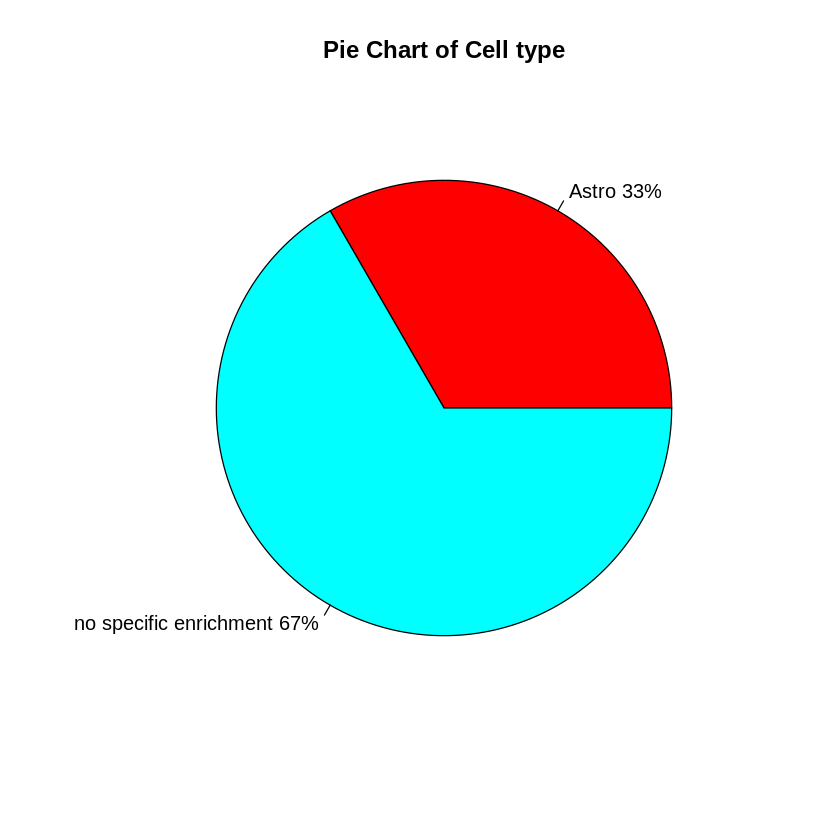

In [72]:
pct <- round(pie_data$Freq/sum(pie_data$Freq)*100)
lbls <- paste(pie_data$Var1, pct) # add percents to labels
lbls <- paste(lbls,"%",sep="") # ad % to labels
pie(pie_data$Freq,labels = lbls, col=rainbow(length(lbls)),
   main="Pie Chart of Cell type")

#### This is not good, I should not try!!!

In [64]:
hc <- hclust(amap:::Dist(protein_intensity_combat[sig_index, ][, Braak_test_index], 
                         method = "abscorrelation"), method = "ward.D")

c_group <- 20 # number of clusters

dend1 <- as.dendrogram(hc)
clust <- dendextend:::cutree(dend1, k=c_group, order_clusters_as_data = FALSE)

#print(clust)
orig_label <- labels(dend1)

MF_labels <- c("Delayed rectifier potassium \nchannel activity",
               "Intracellular ligand-gated \nion channel activity",
               "NADH dehydrogenase activity", 
               "Structural constituent of \ncytoskeleton",
               "Nuclear receptor \ntranscription coactivator")

plot_labels <- clust
#keep_index <- numeric(0)
#for(i in 1:c_group){
#    plot_labels[clust == i] <- MF_labels[i]
#    keep_index <- c(keep_index, as.integer(median(which(clust == i))))
#}
#
##print(keep_index)
#plot_labels[-keep_index] <- NA
##print(plot_labels)

lbls <- unique(clust)
#print(lbls)
#labels(dend1) <- clust
#labels(dend1) <- orig_label
labels(dend1) <- plot_labels

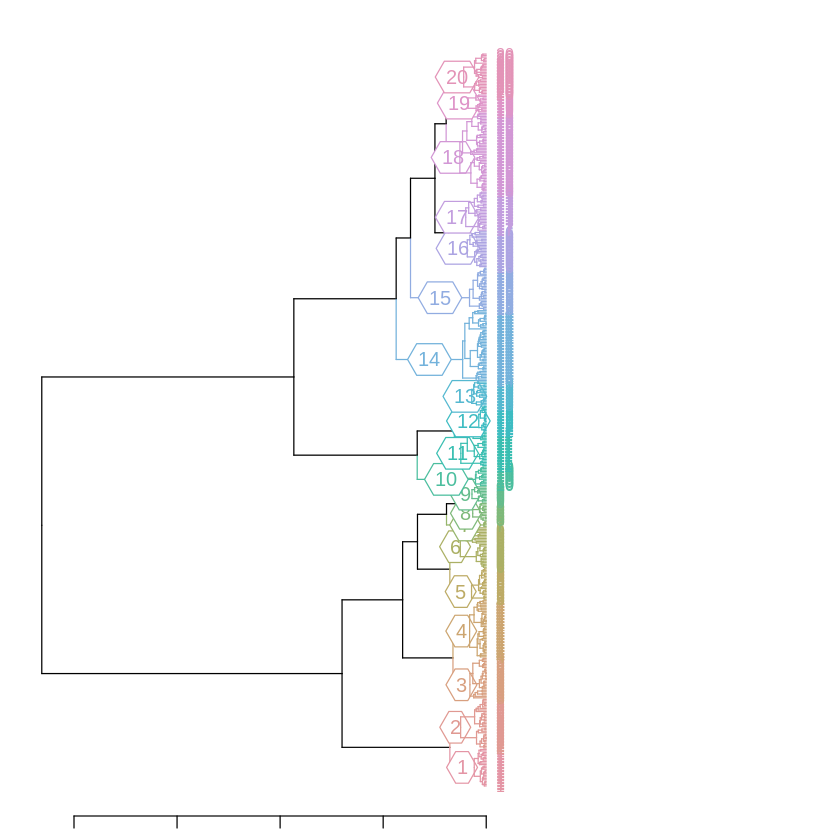

In [65]:
dend1 <- color_branches(dend1, k = c_group, groupLabels = lbls, col = rainbow_hcl) # add color to the lines
dend1 <- color_labels(dend1, k = c_group, col = rainbow_hcl)   # add color to the labels

# reorder the dendrogram, must incl. `agglo.FUN = mean`
#rMeans <- rowMeans(median_stage_exps_ANOVA, na.rm = T)
#dend1 <- reorder(dend1, rowMeans(median_stage_exps_ANOVA, na.rm = T), agglo.FUN = mean)

# get the color of the leaves (labels) for `heatmap.2`
col_labels <- get_leaves_branches_col(dend1)
col_labels <- col_labels[order(order.dendrogram(dend1))]

plot_labels <- plot_labels[order(order.dendrogram(dend1))]

# if plot the dendrogram alone:
# the size of the labels:
dend1 <- set(dend1, "labels_cex", 0.8)
par(mar = c(1,1,1,14))
#print(labels(dend1))
plot_horiz.dendrogram(dend1, side = F) # use side = T to horiz mirror if needed

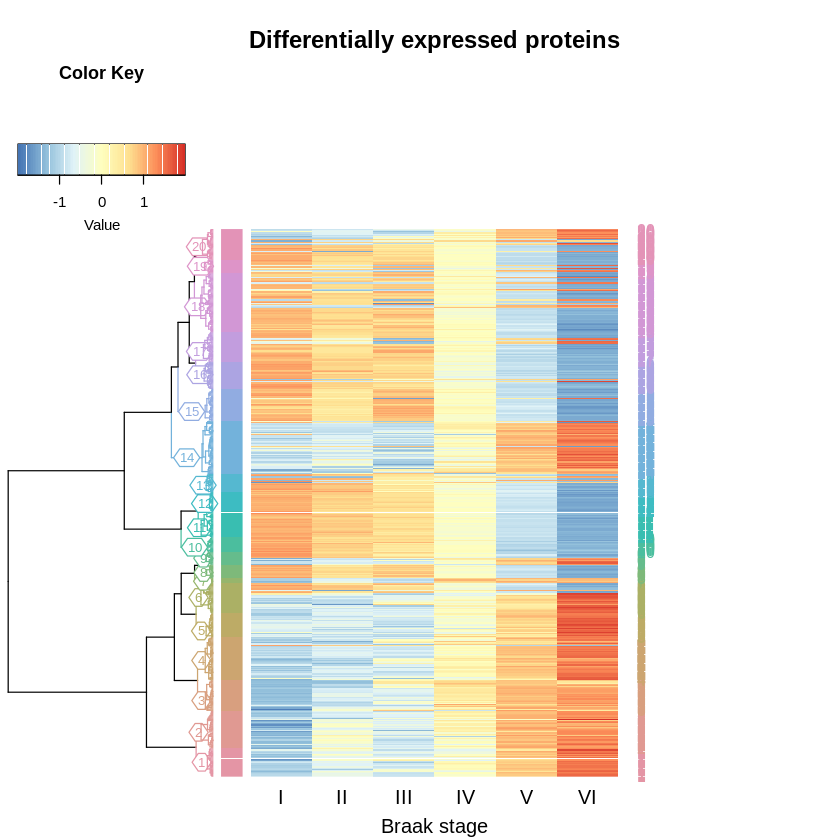

In [66]:
heatmap.2(median_stage_exps_ANOVA, main = 'Differentially expressed proteins',
          # reorderfun=function(d, w) reorder(d, w, agglo.FUN = mean),
                                     # order by branch mean so the deepest color is at the top
          dendrogram = "row",        # no dendrogram for columns
          Rowv = dend1,              # * use self-made dendrogram
          Colv = "NA",               # make sure the columns follow data's order
          col = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(100), #diverge_hcl,  #       # color pattern of the heatmap
          
          trace="none",              # hide trace
          density.info="none",       # hide histogram
          
          margins = c(4, 14),         # margin on top(bottom) and left(right) side.
          cexRow=1.2, cexCol = 1.5,      # size of row / column labels
          labRow = plot_labels,
          xlab = "Braak stage",
          srtCol=0, adjCol = c(0.5,1), # adjust the direction of row label to be horizontal
          # margin for the color key
          # ("bottom.margin", "left.margin", "top.margin", "left.margin" )
          key.par=list(mar=c(3,1,8,2)),
          #lmat=rbind( c(1, 3), c(2,1), c(0,4) ), lhei=c(1.5, 4, 2 ) ,
          RowSideColors = col_labels, # to add nice colored strips        
          colRow = col_labels         # add color to label
)

In [67]:
for (i in 1:c_group){
    cat("This is cluster", i, sep = "", end = ".\n")
    cat("The number of protein in this cluster is", length(which(clust == i)), sep = " ", end = ".\n")

    protein_list_custer1 <- unique(get_single_protein(names(clust[clust == i])))
    if(length(protein_list_custer1) < 1){
        cat("The number of valide protein in this cluster is", length(protein_list_custer1), sep = " ", end = ".\n")
        next
    }

    geneList_cluster1 <- factor(as.integer(backgroud_protein_list %in% protein_list_custer1))

    names(geneList_cluster1) <- backgroud_protein_list

    GOdata_nscore_MF <- new("topGOdata",
                            ontology="BP",
                            allGenes=geneList_cluster1,
                            annot=annFUN.gene2GO, gene2GO=geneSymbol2go_list,
                            nodeSize=5)
    #GOdata_nscore_MF

    allGO =usedGO(object = GOdata_nscore_MF)

    resultFis <- runTest(GOdata_nscore_MF, 
                         algorithm="classic",
                         statistic="fisher")

    allRes <- GenTable(GOdata_nscore_MF, Fisher = resultFis,
                       ranksOf = "classic", topNodes = length(allGO))

    FDR <- p.adjust(p=allRes[,"Fisher"],method="BH")
    allRes <- cbind(allRes, FDR)
    
    print.data.frame(allRes[1:20,][,c(2,3,4,7)])
}

This is cluster1.
The number of protein in this cluster is 25 .



Building most specific GOs .....
	( 6550 GO terms found. )

Build GO DAG topology ..........
	( 10581 GO terms and 24692 relations. )

Annotating nodes ...............
	( 3044 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1029 nontrivial nodes
		 parameters: 
			 test statistic: fisher


                                          Term Annotated Significant FDR
1             small molecule metabolic process       658          11   1
2        monocarboxylic acid metabolic process       196           6   1
3            carboxylic acid metabolic process       368           8   1
4                    oxoacid metabolic process       375           8   1
5               organic acid metabolic process       378           8   1
6                 nucleobase metabolic process        19           2   1
7  neutrophil activation involved in immune...       202           5   1
8                     neutrophil degranulation       202           5   1
9                        neutrophil activation       203           5   1
10                neutrophil mediated immunity       204           5   1
11                      granulocyte activation       206           5   1
12 myeloid cell activation involved in immu...       211           5   1
13                     leukocyte degranulation     


Building most specific GOs .....
	( 6550 GO terms found. )

Build GO DAG topology ..........
	( 10581 GO terms and 24692 relations. )

Annotating nodes ...............
	( 3044 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1344 nontrivial nodes
		 parameters: 
			 test statistic: fisher


                                          Term Annotated Significant       FDR
1  glyceraldehyde-3-phosphate metabolic pro...        10           3 0.1914400
2             monosaccharide catabolic process        27           4 0.1914400
3             monosaccharide metabolic process        83           6 0.1914400
4          cellular aldehyde metabolic process        33           4 0.3110900
5               carbohydrate metabolic process       151           7 0.4786000
6            L-ascorbic acid metabolic process         5           2 0.7274720
7     intracellular receptor signaling pathway        48           4 0.7274720
8                     hexose catabolic process        23           3 0.7274720
9         response to hepatocyte growth factor         6           2 0.7274720
10                   vitamin metabolic process        24           3 0.7274720
11                     pentose-phosphate shunt         7           2 0.7617717
12 regulation of cell adhesion mediated by ...      


Building most specific GOs .....
	( 6550 GO terms found. )

Build GO DAG topology ..........
	( 10581 GO terms and 24692 relations. )

Annotating nodes ...............
	( 3044 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1335 nontrivial nodes
		 parameters: 
			 test statistic: fisher


                                          Term Annotated Significant FDR
1                          RNA destabilization         7           2   1
2               labyrinthine layer development         7           2   1
3                         mRNA destabilization         7           2   1
4               embryonic placenta development         9           2   1
5                  embryonic organ development        36           3   1
6  positive regulation of Ras protein signa...        10           2   1
7  positive regulation of small GTPase medi...        11           2   1
8  positive regulation of mRNA catabolic pr...        11           2   1
9                            ear morphogenesis        12           2   1
10                           NADH regeneration        16           2   1
11                        canonical glycolysis        16           2   1
12       glucose catabolic process to pyruvate        16           2   1
13 glycolytic process through glucose-6-pho...     


Building most specific GOs .....
	( 6550 GO terms found. )

Build GO DAG topology ..........
	( 10581 GO terms and 24692 relations. )

Annotating nodes ...............
	( 3044 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1335 nontrivial nodes
		 parameters: 
			 test statistic: fisher


                                          Term Annotated Significant        FDR
1                   cofactor metabolic process       217          10 0.05264600
2               organic acid catabolic process        95           7 0.05264600
3            carboxylic acid catabolic process        95           7 0.05264600
4             small molecule metabolic process       658          17 0.05862850
5             small molecule catabolic process       146           8 0.06461100
6                    pigment metabolic process        24           4 0.06461100
7                   cofactor catabolic process        25           4 0.06563657
8        cellular amino acid metabolic process       158           8 0.06913111
9            carboxylic acid metabolic process       368          12 0.06913111
10                   oxoacid metabolic process       375          12 0.07396545
11              organic acid metabolic process       378          12 0.07396545
12 regulation of cellular protein catabo


Building most specific GOs .....
	( 6550 GO terms found. )

Build GO DAG topology ..........
	( 10581 GO terms and 24692 relations. )

Annotating nodes ...............
	( 3044 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1088 nontrivial nodes
		 parameters: 
			 test statistic: fisher


                                          Term Annotated Significant
1                   cofactor metabolic process       217          10
2          monosaccharide biosynthetic process        36           5
3        pyridine nucleotide metabolic process        69           6
4  nicotinamide nucleotide metabolic proces...        69           6
5  pyridine-containing compound metabolic p...        74           6
6  oxidoreduction coenzyme metabolic proces...        75           6
7             monosaccharide metabolic process        83           6
8                   coenzyme metabolic process       146           7
9            carbohydrate biosynthetic process        57           5
10              carbohydrate metabolic process       151           7
11                 oxidation-reduction process       339           9
12                      NADP metabolic process        15           3
13           organophosphate catabolic process        80           5
14       monocarboxylic acid metab


Building most specific GOs .....
	( 6550 GO terms found. )

Build GO DAG topology ..........
	( 10581 GO terms and 24692 relations. )

Annotating nodes ...............
	( 3044 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 810 nontrivial nodes
		 parameters: 
			 test statistic: fisher


                                          Term Annotated Significant     FDR
1             small molecule catabolic process       146           7 0.31109
2               organic acid metabolic process       378           9 1.00000
3                 nucleoside catabolic process         7           2 1.00000
4             small molecule metabolic process       658          12 1.00000
5          cellular aldehyde metabolic process        33           3 1.00000
6  nucleobase-containing small molecule cat...         9           2 1.00000
7          glycosyl compound catabolic process         9           2 1.00000
8  pyridine-containing compound metabolic p...        74           4 1.00000
9       response to purine-containing compound        38           3 1.00000
10 carbohydrate derivative catabolic proces...        38           3 1.00000
11          neurotransmitter metabolic process        43           3 1.00000
12           carboxylic acid metabolic process       368           8 1.00000


Building most specific GOs .....
	( 6550 GO terms found. )

Build GO DAG topology ..........
	( 10581 GO terms and 24692 relations. )

Annotating nodes ...............
	( 3044 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 135 nontrivial nodes
		 parameters: 
			 test statistic: fisher


                                          Term Annotated Significant
1     positive regulation of B cell activation         8           2
2     complement activation, classical pathway         9           2
3              regulation of B cell activation         9           2
4  humoral immune response mediated by circ...        10           2
5            B cell receptor signaling pathway        10           2
6                     phagocytosis, engulfment        12           2
7        regulation of humoral immune response        13           2
8                        complement activation        13           2
9          regulation of complement activation        13           2
10    regulation of protein activation cascade        13           2
11     immunoglobulin mediated immune response        14           2
12                    B cell mediated immunity        14           2
13 regulation of acute inflammatory respons...        15           2
14                plasma membrane 


Building most specific GOs .....
	( 6550 GO terms found. )

Build GO DAG topology ..........
	( 10581 GO terms and 24692 relations. )

Annotating nodes ...............
	( 3044 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 578 nontrivial nodes
		 parameters: 
			 test statistic: fisher


                                          Term Annotated Significant     FDR
1        mitochondrial transmembrane transport        48           3 0.47860
2               proton transmembrane transport        56           3 0.47860
3            organophosphate metabolic process       400           5 0.88541
4                      transmembrane transport       412           5 0.88541
5  inner mitochondrial membrane organizatio...        23           2 1.00000
6                      mitochondrial transport       110           3 1.00000
7                 nucleotide metabolic process       269           4 1.00000
8       nucleoside phosphate metabolic process       271           4 1.00000
9                       drug metabolic process       290           4 1.00000
10                 ion transmembrane transport       292           4 1.00000
11 nucleobase-containing small molecule met...       294           4 1.00000
12       monovalent inorganic cation transport       135           3 1.00000


Building most specific GOs .....
	( 6550 GO terms found. )

Build GO DAG topology ..........
	( 10581 GO terms and 24692 relations. )

Annotating nodes ...............
	( 3044 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 198 nontrivial nodes
		 parameters: 
			 test statistic: fisher


                                          Term Annotated Significant FDR
1                 fatty acid catabolic process        39           2   1
2             small molecule catabolic process       146           3   1
3        monocarboxylic acid catabolic process        46           2   1
4             cellular lipid catabolic process        67           2   1
5                GDP-mannose metabolic process         5           1   1
6                 long-chain fatty acid import         5           1   1
7                   aldehyde catabolic process         5           1   1
8           monoacylglycerol metabolic process         5           1   1
9           monoacylglycerol catabolic process         5           1   1
10         cellular detoxification of aldehyde         5           1   1
11     fatty acid derivative catabolic process         5           1   1
12        phosphatidylserine metabolic process         6           1   1
13               cellular response to aldehyde     


Building most specific GOs .....
	( 6550 GO terms found. )

Build GO DAG topology ..........
	( 10581 GO terms and 24692 relations. )

Annotating nodes ...............
	( 3044 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 184 nontrivial nodes
		 parameters: 
			 test statistic: fisher


                                          Term Annotated Significant
1     ATP synthesis coupled electron transport        65           7
2  mitochondrial ATP synthesis coupled elec...        65           7
3         respiratory electron transport chain        76           7
4                    oxidative phosphorylation        84           7
5  mitochondrial respiratory chain complex ...        48           6
6                     electron transport chain       102           7
7                         cellular respiration       115           7
8  energy derivation by oxidation of organi...       137           7
9                        ATP metabolic process       139           7
10         NADH dehydrogenase complex assembly        38           5
11 mitochondrial respiratory chain complex ...        38           5
12 purine ribonucleoside triphosphate metab...       148           7
13 mitochondrial electron transport, NADH t...        39           5
14 purine nucleoside triphosphate 


Building most specific GOs .....
	( 6550 GO terms found. )

Build GO DAG topology ..........
	( 10581 GO terms and 24692 relations. )

Annotating nodes ...............
	( 3044 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 417 nontrivial nodes
		 parameters: 
			 test statistic: fisher


                                          Term Annotated Significant
1                    oxidative phosphorylation        84          15
2     ATP synthesis coupled electron transport        65          13
3  mitochondrial ATP synthesis coupled elec...        65          13
4                     electron transport chain       102          14
5         respiratory electron transport chain        76          13
6                        ATP metabolic process       139          15
7  mitochondrial electron transport, NADH t...        39          11
8  purine ribonucleoside triphosphate metab...       148          15
9  purine nucleoside triphosphate metabolic...       150          15
10 ribonucleoside triphosphate metabolic pr...       150          15
11 nucleoside triphosphate metabolic proces...       155          15
12 purine nucleoside monophosphate metaboli...       160          15
13 purine ribonucleoside monophosphate meta...       160          15
14 ribonucleoside monophosphate me


Building most specific GOs .....
	( 6550 GO terms found. )

Build GO DAG topology ..........
	( 10581 GO terms and 24692 relations. )

Annotating nodes ...............
	( 3044 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 480 nontrivial nodes
		 parameters: 
			 test statistic: fisher


                                          Term Annotated Significant
1                         cellular respiration       115          13
2          NADH dehydrogenase complex assembly        38          10
3  mitochondrial respiratory chain complex ...        38          10
4  mitochondrial electron transport, NADH t...        39          10
5     ATP synthesis coupled electron transport        65          11
6  mitochondrial ATP synthesis coupled elec...        65          11
7  energy derivation by oxidation of organi...       137          13
8  mitochondrial respiratory chain complex ...        48          10
9         respiratory electron transport chain        76          11
10                   oxidative phosphorylation        84          11
11                    electron transport chain       102          11
12 generation of precursor metabolites and ...       221          13
13     purine ribonucleotide metabolic process       221          13
14            ribonucleotide metab


Building most specific GOs .....
	( 6550 GO terms found. )

Build GO DAG topology ..........
	( 10581 GO terms and 24692 relations. )

Annotating nodes ...............
	( 3044 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1923 nontrivial nodes
		 parameters: 
			 test statistic: fisher


                                          Term Annotated Significant        FDR
1                        muscle system process       107          10 0.00234514
2          integrin-mediated signaling pathway        27           6 0.00234514
3                                cell adhesion       319          15 0.00909340
4                          biological adhesion       320          15 0.00909340
5            extracellular matrix organization        61           7 0.00957200
6                           cell-cell adhesion       176          11 0.00957200
7                           muscle contraction        87           8 0.00957200
8              formation of primary germ layer        13           4 0.01136675
9         extracellular structure organization        72           7 0.01967578
10                      male gonad development        16           4 0.02001418
11 development of primary male sexual chara...        16           4 0.02001418
12            multicellular organismal p


Building most specific GOs .....
	( 6550 GO terms found. )

Build GO DAG topology ..........
	( 10581 GO terms and 24692 relations. )

Annotating nodes ...............
	( 3044 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1145 nontrivial nodes
		 parameters: 
			 test statistic: fisher


                                          Term Annotated Significant        FDR
1  regulation of long-term neuronal synapti...        18           4 0.01459730
2         regulation of NMDA receptor activity        19           4 0.01459730
3  ionotropic glutamate receptor signaling ...        10           3 0.03302340
4  regulation of neuronal synaptic plastici...        30           4 0.03302340
5  regulation of glutamate receptor signali...        31           4 0.03302340
6               chemical synaptic transmission       290           9 0.03302340
7         anterograde trans-synaptic signaling       290           9 0.03302340
8                     trans-synaptic signaling       294           9 0.03302340
9  regulation of neurotransmitter receptor ...        34           4 0.03302340
10                          synaptic signaling       295           9 0.03302340
11                       response to metal ion       119           6 0.04786000
12 positive regulation of excitatory pos


Building most specific GOs .....
	( 6550 GO terms found. )

Build GO DAG topology ..........
	( 10581 GO terms and 24692 relations. )

Annotating nodes ...............
	( 3044 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 772 nontrivial nodes
		 parameters: 
			 test statistic: fisher


                                          Term Annotated Significant       FDR
1  gamma-aminobutyric acid signaling pathwa...        16           3 0.5838920
2  G protein-coupled receptor signaling pat...       159           6 0.5838920
3             synaptic transmission, GABAergic        23           3 0.5838920
4                        response to histamine         6           2 0.5838920
5               cellular response to histamine         6           2 0.5838920
6                  inhibitory synapse assembly         8           2 0.8933867
7                 alcohol biosynthetic process        45           3 1.0000000
8  regulation of cholesterol biosynthetic p...        14           2 1.0000000
9  regulation of mitotic spindle organizati...        14           2 1.0000000
10 regulation of sterol biosynthetic proces...        14           2 1.0000000
11          regulation of spindle organization        15           2 1.0000000
12                        spindle organization      


Building most specific GOs .....
	( 6550 GO terms found. )

Build GO DAG topology ..........
	( 10581 GO terms and 24692 relations. )

Annotating nodes ...............
	( 3044 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 849 nontrivial nodes
		 parameters: 
			 test statistic: fisher


                                          Term Annotated Significant FDR
1                           cell morphogenesis       339           7   1
2             cellular component morphogenesis       369           7   1
3                           neuron development       379           7   1
4                anion transmembrane transport        68           3   1
5  homophilic cell adhesion via plasma memb...        25           2   1
6                       neuron differentiation       413           7   1
7                           chloride transport        27           2   1
8                              anion transport       146           4   1
9                             cell development       542           8   1
10                       generation of neurons       440           7   1
11 negative regulation of protein complex d...        33           2   1
12 negative regulation of protein depolymer...        33           2   1
13                 acidic amino acid transport     


Building most specific GOs .....
	( 6550 GO terms found. )

Build GO DAG topology ..........
	( 10581 GO terms and 24692 relations. )

Annotating nodes ...............
	( 3044 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1784 nontrivial nodes
		 parameters: 
			 test statistic: fisher


                                          Term Annotated Significant
1               chemical synaptic transmission       290          17
2         anterograde trans-synaptic signaling       290          17
3                     trans-synaptic signaling       294          17
4                           synaptic signaling       295          17
5  positive regulation of synaptic transmis...        70           9
6  modulation of chemical synaptic transmis...       203          14
7       regulation of trans-synaptic signaling       204          14
8                               signal release       157          12
9                          cell-cell signaling       490          20
10 positive regulation of neurotransmitter ...        11           4
11                  synaptic vesicle transport        84           8
12 establishment of synaptic vesicle locali...        84           8
13                 synaptic vesicle exocytosis        63           7
14 synaptic vesicle fusion to pres


Building most specific GOs .....
	( 6550 GO terms found. )

Build GO DAG topology ..........
	( 10581 GO terms and 24692 relations. )

Annotating nodes ...............
	( 3044 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 585 nontrivial nodes
		 parameters: 
			 test statistic: fisher


                                          Term Annotated Significant FDR
1                 antibiotic metabolic process        63           3   1
2  regulation of glucose transmembrane tran...        18           2   1
3               hexose transmembrane transport        23           2   1
4       monosaccharide transmembrane transport        23           2   1
5         carbohydrate transmembrane transport        23           2   1
6              glucose transmembrane transport        23           2   1
7  generation of precursor metabolites and ...       221           4   1
8                       carbohydrate transport        25           2   1
9                       drug catabolic process        33           2   1
10 positive regulation of NF-kappaB transcr...        36           2   1
11                      drug metabolic process       290           4   1
12 positive regulation of DNA-binding trans...        50           2   1
13                 oxidation-reduction process     


Building most specific GOs .....
	( 6550 GO terms found. )

Build GO DAG topology ..........
	( 10581 GO terms and 24692 relations. )

Annotating nodes ...............
	( 3044 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 931 nontrivial nodes
		 parameters: 
			 test statistic: fisher


                                          Term Annotated Significant FDR
1                    cranial nerve development         7           2   1
2  endoplasmic reticulum tubular network or...        12           2   1
3                            nerve development        16           2   1
4       protein transport within lipid bilayer        20           2   1
5           endoplasmic reticulum organization        24           2   1
6                      membrane depolarization        30           2   1
7  branching involved in ureteric bud morph...         5           1   1
8              morphogenesis of an endothelium         5           1   1
9     muscle hypertrophy in response to stress         5           1   1
10                   cardiac muscle adaptation         5           1   1
11 cardiac muscle hypertrophy in response t...         5           1   1
12 positive regulation of synaptic plastici...         5           1   1
13 locomotion involved in locomotory behavi...     

In [68]:
cat("This is cluster", i, sep = "", end = ".\n")
    cat("The number of protein in this cluster is", length(which(clust == i)), sep = " ", end = ".\n")

    protein_list_custer1 <- unique(get_single_protein(names(clust[clust == i])))
    if(length(protein_list_custer1) < 1){
        cat("The number of valide protein in this cluster is", length(protein_list_custer1), sep = " ", end = ".\n")
        next
    }for (i in 1:c_group){
    cat("This is cluster", i, sep = "", end = ".\n")
    cat("The number of protein in this cluster is", length(which(clust == i)), sep = " ", end = ".\n")

    protein_list_custer1 <- unique(get_single_protein(names(clust[clust == i])))
    if(length(protein_list_custer1) < 1){
        cat("The number of valide protein in this cluster is", length(protein_list_custer1), sep = " ", end = ".\n")
        next
    }

    geneList_cluster1 <- factor(as.integer(backgroud_protein_list %in% protein_list_custer1))

    names(geneList_cluster1) <- backgroud_protein_list

    GOdata_nscore_MF <- new("topGOdata",
                            ontology="MF",
                            allGenes=geneList_cluster1,
                            annot=annFUN.gene2GO, gene2GO=geneSymbol2go_list,
                            nodeSize=5)
    #GOdata_nscore_MF

    allGO =usedGO(object = GOdata_nscore_MF)

    resultFis <- runTest(GOdata_nscore_MF, 
                         algorithm="classic",
                         statistic="fisher")

    allRes <- GenTable(GOdata_nscore_MF, Fisher = resultFis,
                       ranksOf = "classic", topNodes = length(allGO))

    FDR <- p.adjust(p=allRes[,"Fisher"],method="BH")
    allRes <- cbind(allRes, FDR)
    
    print(i)
    print.data.frame(allRes[1:20,][,c(2,3,4,7)])
}

This is cluster1.
The number of protein in this cluster is 25 .



Building most specific GOs .....
	( 2046 GO terms found. )

Build GO DAG topology ..........
	( 2544 GO terms and 3303 relations. )

Annotating nodes ...............
	( 3026 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 158 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] 1
                                          Term Annotated Significant     FDR
1                 O-methyltransferase activity         6           2 0.40350
2                       fatty-acyl-CoA binding         9           2 0.40350
3  cysteine-type endopeptidase inhibitor ac...        10           2 0.40350
4                fatty acid derivative binding        10           2 0.40350
5           protein methyltransferase activity        12           2 0.45999
6  S-adenosylmethionine-dependent methyltra...        13           2 0.45999
7                           catalytic activity      1294          15 0.81507
8                   methyltransferase activity        20           2 0.81507
9  transferase activity, transferring one-c...        26           2 1.00000
10            endopeptidase inhibitor activity        33           2 1.00000
11                peptidase inhibitor activity        33           2 1.00000
12                            protease binding        37           2 1


Building most specific GOs .....
	( 2046 GO terms found. )

Build GO DAG topology ..........
	( 2544 GO terms and 3303 relations. )

Annotating nodes ...............
	( 3026 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 167 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] 2
                                          Term Annotated Significant       FDR
1                           catalytic activity      1294          23 0.1291200
2                cytidylyltransferase activity         5           2 0.3752550
3                           isomerase activity        53           4 0.3954300
4                       phosphoprotein binding        26           3 0.3954300
5              phosphotyrosine residue binding        11           2 0.6220108
6                        magnesium ion binding        77           4 0.6220108
7  peptidyl-prolyl cis-trans isomerase acti...        13           2 0.6220108
8                 cis-trans isomerase activity        13           2 0.6220108
9                     SH3/SH2 adaptor activity        14           2 0.6220108
10             nucleotidyltransferase activity        15           2 0.6220108
11 protein phosphorylated amino acid bindin...        15           2 0.6220108
12                   protein binding, bridging


Building most specific GOs .....
	( 2046 GO terms found. )

Build GO DAG topology ..........
	( 2544 GO terms and 3303 relations. )

Annotating nodes ...............
	( 3026 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 176 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] 3
                                          Term Annotated Significant       FDR
1  protein phosphorylated amino acid bindin...        15           3 0.0968400
2                       phosphoprotein binding        26           3 0.2743800
3                   molecular adaptor activity        68           4 0.2824500
4              phosphotyrosine residue binding        11           2 0.4559550
5                  adrenergic receptor binding        12           2 0.4559550
6                    protein binding, bridging        45           3 0.4559550
7                     SH3/SH2 adaptor activity        14           2 0.4576843
8               growth factor receptor binding        19           2 0.6556875
9                          phosphatase binding        60           3 0.6556875
10                   identical protein binding       462           8 0.6556875
11          protein-containing complex binding       370           7 0.6556875
12                  signaling adaptor activity


Building most specific GOs .....
	( 2046 GO terms found. )

Build GO DAG topology ..........
	( 2544 GO terms and 3303 relations. )

Annotating nodes ...............
	( 3026 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 164 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] 4
                                          Term Annotated Significant       FDR
1                             cofactor binding       173           9 0.0231340
2                    identical protein binding       462          14 0.0231340
3                           catalytic activity      1294          24 0.0231340
4                             coenzyme binding       120           7 0.0302625
5                                  NAD binding        39           4 0.0936120
6              thioredoxin peroxidase activity         5           2 0.1152857
7             endopeptidase activator activity         5           2 0.1152857
8  oxidoreductase activity, acting on the C...        51           4 0.1624088
9                       peroxiredoxin activity         7           2 0.1790073
10                     oxidoreductase activity       241           8 0.1790073
11 oxidoreductase activity, acting on CH-OH...        57           4 0.1790073
12                peptidase activator activity


Building most specific GOs .....
	( 2046 GO terms found. )

Build GO DAG topology ..........
	( 2544 GO terms and 3303 relations. )

Annotating nodes ...............
	( 3026 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 112 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] 5
                                          Term Annotated Significant       FDR
1                                 NADP binding        21           4 0.0034701
2                      oxidoreductase activity       241           9 0.0034701
3                         antioxidant activity        26           3 0.1271025
4                             cofactor binding       173           6 0.1271025
5             endopeptidase inhibitor activity        33           3 0.1600550
6                 peptidase inhibitor activity        33           3 0.1600550
7              glutathione peroxidase activity         9           2 0.1671643
8             endopeptidase regulator activity        38           3 0.1815750
9                 peptidase regulator activity        41           3 0.2008533
10 oxidoreductase activity, acting on the C...        51           3 0.3302492
11                         peroxidase activity        16           2 0.3302492
12 serine-type endopeptidase inhibitor acti...


Building most specific GOs .....
	( 2046 GO terms found. )

Build GO DAG topology ..........
	( 2544 GO terms and 3303 relations. )

Annotating nodes ...............
	( 3026 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 152 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] 6
                                          Term Annotated Significant     FDR
1                           fatty acid binding         8           2 0.56490
2                      oxidoreductase activity       241           7 0.56490
3        aldehyde dehydrogenase (NAD) activity         9           2 0.56490
4  oxidoreductase activity, acting on the a...        14           2 0.78279
5                  monocarboxylic acid binding        14           2 0.78279
6  oxidoreductase activity, acting on the C...        51           3 0.78279
7                      carboxylic acid binding        52           3 0.78279
8                         organic acid binding        56           3 0.78279
9  oxidoreductase activity, acting on the a...        19           2 0.78279
10 oxidoreductase activity, acting on CH-OH...        57           3 0.78279
11                          catalytic activity      1294          16 1.00000
12 oxidoreductase activity, acting on a sul...        27           2 1


Building most specific GOs .....
	( 2046 GO terms found. )

Build GO DAG topology ..........
	( 2544 GO terms and 3303 relations. )

Annotating nodes ...............
	( 3026 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 5 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] 7
                                          Term Annotated Significant       FDR
1                              antigen binding         7           2 0.0037122
2                   signaling receptor binding       289           2 1.0000000
3                              protein binding      2535           2 1.0000000
4                                      binding      2827           2 1.0000000
5                           molecular_function      3026           2 1.0000000
6                                 tRNA binding        24           0 1.0000000
7                       fatty-acyl-CoA binding         9           0 1.0000000
8                 microfilament motor activity         8           0 1.0000000
9                                SNARE binding        59           0 1.0000000
10                          nucleotide binding       701           0 1.0000000
11              3'-5'-exoribonuclease activity         5           0 1.0000000
12                       magnesium ion binding


Building most specific GOs .....
	( 2046 GO terms found. )

Build GO DAG topology ..........
	( 2544 GO terms and 3303 relations. )

Annotating nodes ...............
	( 3026 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 57 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] 8
                                          Term Annotated Significant FDR
1  proton transmembrane transporter activit...        33           2   1
2  inorganic molecular entity transmembrane...       153           3   1
3       ion transmembrane transporter activity       172           3   1
4           transmembrane transporter activity       188           3   1
5                         transporter activity       214           3   1
6  monovalent inorganic cation transmembran...        71           2   1
7  monocarboxylic acid transmembrane transp...         6           1   1
8  protein binding involved in heterotypic ...         6           1   1
9               diacylglycerol kinase activity         7           1   1
10               cytochrome-c oxidase activity         8           1   1
11       heme-copper terminal oxidase activity         8           1   1
12 oxidoreductase activity, acting on a hem...         8           1   1
13                        NAD+ kinase activit


Building most specific GOs .....
	( 2046 GO terms found. )

Build GO DAG topology ..........
	( 2544 GO terms and 3303 relations. )

Annotating nodes ...............
	( 3026 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 54 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] 9
                                          Term Annotated Significant FDR
1                           catalytic activity      1294           7   1
2          carboxylic ester hydrolase activity        37           2   1
3  long-chain fatty acid-CoA ligase activit...         5           1   1
4                 acylglycerol lipase activity         5           1   1
5                   fatty acid ligase activity         6           1   1
6  hydrolase activity, acting on carbon-nit...         7           1   1
7                         deacetylase activity         7           1   1
8                          CoA-ligase activity         9           1   1
9                                  FAD binding        11           1   1
10                  acid-thiol ligase activity        12           1   1
11               thiolester hydrolase activity        14           1   1
12             nucleotidyltransferase activity        15           1   1
13 ligase activity, forming carbon-sulfur b..


Building most specific GOs .....
	( 2046 GO terms found. )

Build GO DAG topology ..........
	( 2544 GO terms and 3303 relations. )

Annotating nodes ...............
	( 3026 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 46 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] 10
                                          Term Annotated Significant
1                  NADH dehydrogenase activity        33           4
2     NADH dehydrogenase (ubiquinone) activity        33           4
3        NADH dehydrogenase (quinone) activity        33           4
4  oxidoreductase activity, acting on NAD(P...        41           4
5  oxidoreductase activity, acting on NAD(P...        55           4
6                      oxidoreductase activity       241           6
7                           ubiquinone binding         5           1
8                 carbon-sulfur lyase activity         6           1
9              glutathione peroxidase activity         9           1
10                             quinone binding        11           1
11            solute:cation symporter activity        15           1
12                         peroxidase activity        16           1
13       ionotropic glutamate receptor binding        16           1
14 oxidoreductase activity,


Building most specific GOs .....
	( 2046 GO terms found. )

Build GO DAG topology ..........
	( 2544 GO terms and 3303 relations. )

Annotating nodes ...............
	( 3026 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 79 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] 11
                                          Term Annotated Significant
1                  NADH dehydrogenase activity        33          11
2     NADH dehydrogenase (ubiquinone) activity        33          11
3        NADH dehydrogenase (quinone) activity        33          11
4  oxidoreductase activity, acting on NAD(P...        41          11
5  oxidoreductase activity, acting on NAD(P...        55          11
6                      oxidoreductase activity       241          13
7                cytochrome-c oxidase activity         8           2
8        heme-copper terminal oxidase activity         8           2
9  oxidoreductase activity, acting on a hem...         8           2
10 oxidoreductase activity, acting on a hem...         9           2
11                          catalytic activity      1294          14
12 proton transmembrane transporter activit...        33           2
13                             5S rRNA binding         5           1
14 ubiquitin-protein transf


Building most specific GOs .....
	( 2046 GO terms found. )

Build GO DAG topology ..........
	( 2544 GO terms and 3303 relations. )

Annotating nodes ...............
	( 3026 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 98 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] 12
                                          Term Annotated Significant
1                  NADH dehydrogenase activity        33          10
2     NADH dehydrogenase (ubiquinone) activity        33          10
3        NADH dehydrogenase (quinone) activity        33          10
4  oxidoreductase activity, acting on NAD(P...        41          10
5  oxidoreductase activity, acting on NAD(P...        55          10
6                      oxidoreductase activity       241          12
7                   electron transfer activity        48           5
8             4 iron, 4 sulfur cluster binding        14           3
9                  iron-sulfur cluster binding        26           3
10                       metal cluster binding        26           3
11                          catalytic activity      1294          13
12        voltage-gated anion channel activity         5           1
13             anion:anion antiporter activity         6           1
14 C4-dicarboxylate transme


Building most specific GOs .....
	( 2046 GO terms found. )

Build GO DAG topology ..........
	( 2544 GO terms and 3303 relations. )

Annotating nodes ...............
	( 3026 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 197 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] 14
                                          Term Annotated Significant       FDR
1               cell adhesion molecule binding       240          12 0.0217890
2                             integrin binding        36           5 0.0310695
3                             cadherin binding       193           9 0.1533300
4           protein-containing complex binding       370          12 0.3131160
5              cell adhesion mediator activity        20           3 0.3131160
6                   signaling receptor binding       289          10 0.3288525
7                           glycolipid binding         7           2 0.3288525
8  cadherin binding involved in cell-cell a...         7           2 0.3288525
9       structural constituent of cytoskeleton        54           4 0.4035000
10                     hyaluronic acid binding         9           2 0.4035000
11                            vinculin binding         9           2 0.4035000
12                structural molecule activit


Building most specific GOs .....
	( 2046 GO terms found. )

Build GO DAG topology ..........
	( 2544 GO terms and 3303 relations. )

Annotating nodes ...............
	( 3026 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 176 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] 15
                                          Term Annotated Significant       FDR
1       ionotropic glutamate receptor activity         8           2 0.4611429
2                  glutamate receptor activity        12           2 0.4611429
3         ligand-gated cation channel activity        12           2 0.4611429
4  calmodulin-dependent protein kinase acti...        14           2 0.4611429
5       transmitter-gated ion channel activity        17           2 0.4611429
6           transmitter-gated channel activity        17           2 0.4611429
7  transmitter-gated ion channel activity i...        17           2 0.4611429
8          protein heterodimerization activity        55           3 0.4611429
9  extracellular ligand-gated ion channel a...        18           2 0.4611429
10 neurotransmitter receptor activity invol...        18           2 0.4611429
11          neurotransmitter receptor activity        19           2 0.4611429
12 postsynaptic neurotransmitter receptor a..


Building most specific GOs .....
	( 2046 GO terms found. )

Build GO DAG topology ..........
	( 2544 GO terms and 3303 relations. )

Annotating nodes ...............
	( 3026 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 149 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] 16
                                          Term Annotated Significant      FDR
1  inhibitory extracellular ligand-gated io...         7           2 0.172698
2                         ion channel activity        71           4 0.172698
3          substrate-specific channel activity        72           4 0.172698
4                             channel activity        76           4 0.172698
5  passive transmembrane transporter activi...        76           4 0.172698
6                       GABA receptor activity        10           2 0.219235
7                    chloride channel activity        17           2 0.302625
8       transmitter-gated ion channel activity        17           2 0.302625
9           transmitter-gated channel activity        17           2 0.302625
10 transmitter-gated ion channel activity i...        17           2 0.302625
11 extracellular ligand-gated ion channel a...        18           2 0.302625
12 neurotransmitter receptor activity invol...        18 


Building most specific GOs .....
	( 2046 GO terms found. )

Build GO DAG topology ..........
	( 2544 GO terms and 3303 relations. )

Annotating nodes ...............
	( 3026 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 158 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] 17
                                          Term Annotated Significant FDR
1     anion transmembrane transporter activity        64           3   1
2                           symporter activity        23           2   1
3            calcium-dependent protein binding        29           2   1
4  inorganic anion transmembrane transporte...        30           2   1
5                 cytoskeletal protein binding       366           6   1
6  organic anion transmembrane transporter ...        40           2   1
7  secondary active transmembrane transport...        40           2   1
8  intramolecular transferase activity, pho...         5           1   1
9           calcium channel inhibitor activity         5           1   1
10               ATP-dependent protein binding         5           1   1
11      protein phosphatase inhibitor activity         6           1   1
12             anion:anion antiporter activity         6           1   1
13 C4-dicarboxylate transmembrane transport.


Building most specific GOs .....
	( 2046 GO terms found. )

Build GO DAG topology ..........
	( 2544 GO terms and 3303 relations. )

Annotating nodes ...............
	( 3026 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 253 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] 18
                                          Term Annotated Significant       FDR
1               serine-type peptidase activity        16           4 0.0298590
2                    serine hydrolase activity        17           4 0.0298590
3                                SNARE binding        59           6 0.0363150
4                         phospholipid binding       149           9 0.0363150
5                                lipid binding       209          10 0.0823140
6           serine-type endopeptidase activity        13           3 0.0928050
7                           syntaxin-1 binding        15           3 0.1245086
8  phosphatidylinositol bisphosphate bindin...        37           4 0.1674525
9                       SNAP receptor activity        18           3 0.1685733
10                            syntaxin binding        41           4 0.1969080
11                   identical protein binding       462          14 0.2472355
12 phosphatidylinositol-4,5-bisphosphate bi..


Building most specific GOs .....
	( 2046 GO terms found. )

Build GO DAG topology ..........
	( 2544 GO terms and 3303 relations. )

Annotating nodes ...............
	( 3026 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 100 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] 19
                                          Term Annotated Significant       FDR
1                      signal sequence binding        18           2 0.4559550
2                      oxidoreductase activity       241           4 0.4559550
3                             coenzyme binding       120           3 0.5084100
4                                  NAD binding        39           2 0.6577050
5                             cofactor binding       173           3 0.7451300
6  oxidoreductase activity, acting on the C...        51           2 0.7451300
7  oxidoreductase activity, acting on CH-OH...        57           2 0.7943186
8                    protein kinase C activity         5           1 0.8661800
9  calcium-dependent protein kinase C activ...         5           1 0.8661800
10                     histone kinase activity         5           1 0.8661800
11               malate dehydrogenase activity         6           1 0.8661800
12                             peptide bindin


Building most specific GOs .....
	( 2046 GO terms found. )

Build GO DAG topology ..........
	( 2544 GO terms and 3303 relations. )

Annotating nodes ...............
	( 3026 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 130 nontrivial nodes
		 parameters: 
			 test statistic: fisher


[1] 20
                                          Term Annotated Significant FDR
1  protein transmembrane transporter activi...         5           1   1
2                 protein transporter activity         5           1   1
3  macromolecule transmembrane transporter ...         5           1   1
4                             zinc ion binding       101           3   1
5  oxidoreductase activity, acting on paire...         6           1   1
6     amide transmembrane transporter activity         6           1   1
7  peptide transmembrane transporter activi...         6           1   1
8  phosphatidylinositol phospholipase C act...         7           1   1
9                                lamin binding         7           1   1
10                carbohydrate kinase activity         7           1   1
11               nitric-oxide synthase binding         7           1   1
12                        dioxygenase activity         7           1   1
13                    phospholipase C activi

#### This is not good, I should not try!!!

Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.
Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.


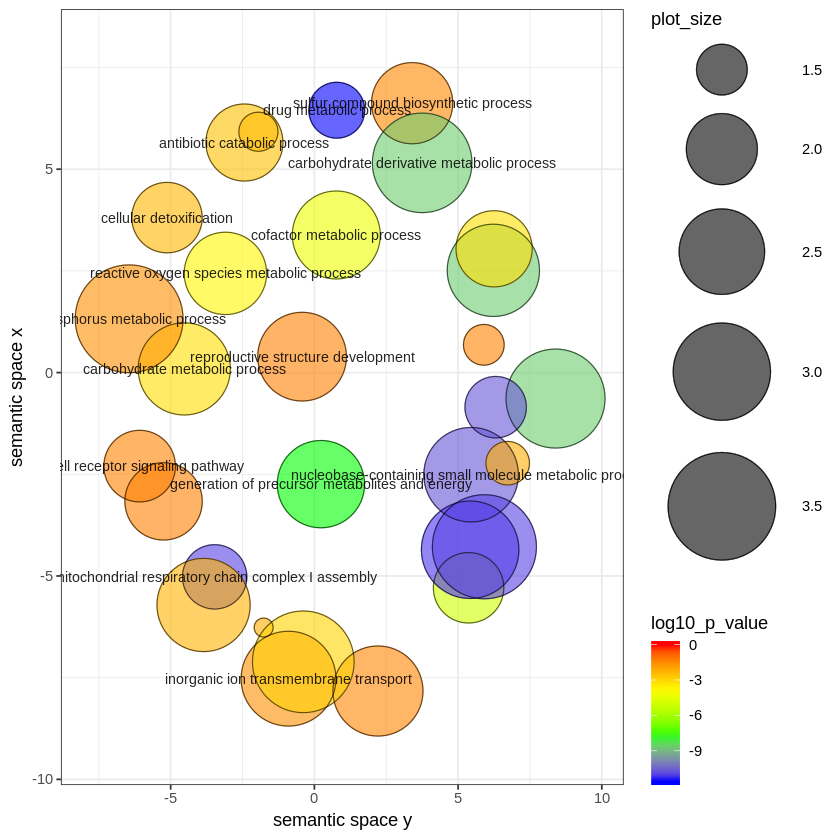

In [30]:
# A plotting R script produced by the REVIGO server at http://revigo.irb.hr/
# If you found REVIGO useful in your work, please cite the following reference:
# Supek F et al. "REVIGO summarizes and visualizes long lists of Gene Ontology
# terms" PLoS ONE 2011. doi:10.1371/journal.pone.0021800


# --------------------------------------------------------------------------
# If you don't have the ggplot2 package installed, uncomment the following line:
# install.packages( "ggplot2" );
library( ggplot2 );
# --------------------------------------------------------------------------
# If you don't have the scales package installed, uncomment the following line:
# install.packages( "scales" );
library( scales );


# --------------------------------------------------------------------------
# Here is your data from REVIGO. Scroll down for plot configuration options.

revigo.names <- c("term_ID","description","frequency_%","plot_X","plot_Y","plot_size","log10_p_value","uniqueness","dispensability");
revigo.data <- rbind(c("GO:0017144","drug metabolic process", 0.225, 1.106, 5.206, 1.602,-11.5982,0.920,0.000),
c("GO:0048608","reproductive structure development", 2.429, 2.202, 2.550, 2.625,-1.3169,0.963,0.000),
c("GO:0098660","inorganic ion transmembrane transport", 4.409, 0.386,-7.454, 2.884,-1.5811,0.892,0.000),
c("GO:0032981","mitochondrial respiratory chain complex I assembly", 0.364, 5.701, 0.501, 1.806,-10.9882,0.936,0.002),
c("GO:1990748","cellular detoxification", 0.542, 4.472, 3.879, 1.978,-2.3306,0.936,0.002),
c("GO:0055086","nucleobase-containing small molecule metabolic process", 4.293,-6.900,-0.807, 2.872,-10.7133,0.525,0.046),
c("GO:0017001","antibiotic catabolic process", 0.894,-3.289,-7.320, 2.190,-2.5214,0.816,0.054),
c("GO:0044272","sulfur compound biosynthetic process", 1.246,-1.989, 2.676, 2.336,-1.4289,0.893,0.056),
c("GO:0072593","reactive oxygen species metabolic process", 1.373, 0.648, 1.475, 2.378,-3.6774,0.908,0.057),
c("GO:0006091","generation of precursor metabolites and energy", 2.129, 1.251,-1.805, 2.568,-7.7352,0.905,0.060),
c("GO:1901135","carbohydrate derivative metabolic process", 7.276, 0.527, 6.662, 3.101,-8.6316,0.906,0.060),
c("GO:0051186","cofactor metabolic process", 2.268,-0.505,-0.492, 2.595,-4.3541,0.904,0.061),
c("GO:0005975","carbohydrate metabolic process", 3.387, 3.492,-0.342, 2.769,-3.1409,0.908,0.061),
c("GO:0050853","B cell receptor signaling pathway", 0.589, 1.770,-4.477, 2.013,-1.3602,0.942,0.069),
c("GO:0006793","phosphorus metabolic process",18.702, 2.042, 6.735, 3.511,-1.5766,0.881,0.087),
c("GO:0031629","synaptic vesicle fusion to presynaptic active zone membrane", 0.087, 4.352,-3.844, 1.204,-2.1597,0.858,0.209),
c("GO:0072521","purine-containing compound metabolic process", 3.422,-6.039, 4.325, 2.774,-8.6660,0.773,0.213),
c("GO:0019682","glyceraldehyde-3-phosphate metabolic process", 0.133,-6.356, 1.568, 1.380,-2.1856,0.614,0.217),
c("GO:0010817","regulation of hormone levels", 2.764, 4.721,-4.509, 2.681,-1.4130,0.961,0.240),
c("GO:0006081","cellular aldehyde metabolic process", 0.542,-6.152,-4.183, 1.978,-5.0234,0.734,0.254),
c("GO:0019637","organophosphate metabolic process", 6.849,-2.909, 6.049, 3.075,-8.6316,0.712,0.293),
c("GO:0007005","mitochondrion organization", 3.756, 6.123, 0.063, 2.814,-2.2823,0.949,0.297),
c("GO:0006811","ion transport", 9.158, 1.296,-7.343, 3.201,-2.9327,0.928,0.316),
c("GO:0055114","oxidation-reduction process", 5.828,-6.556,-3.219, 3.005,-11.1845,0.670,0.354),
c("GO:0009226","nucleotide-sugar biosynthetic process", 0.121,-5.541, 5.307, 1.342,-1.3602,0.798,0.364),
c("GO:0051187","cofactor catabolic process", 0.115,-2.430,-5.904, 1.322,-2.4320,0.791,0.377),
c("GO:0006120","mitochondrial electron transport, NADH to ubiquinone", 0.306,-6.154, 1.036, 1.732,-10.7133,0.416,0.416),
c("GO:0072524","pyridine-containing compound metabolic process", 0.831,-5.265, 4.407, 2.161,-3.1799,0.802,0.428),
c("GO:0044281","small molecule metabolic process",12.072,-6.849,-3.023, 3.321,-10.9882,0.640,0.428),
c("GO:0002685","regulation of leukocyte migration", 0.912, 1.678,-5.832, 2.201,-1.3306,0.899,0.463),
c("GO:0005996","monosaccharide metabolic process", 1.616,-7.339,-2.243, 2.449,-4.2496,0.527,0.511),
c("GO:0044282","small molecule catabolic process", 2.025,-5.829,-3.049, 2.547,-4.8455,0.537,0.528),
c("GO:0044283","small molecule biosynthetic process", 3.064,-6.960,-1.338, 2.726,-1.8783,0.538,0.561),
c("GO:0032787","monocarboxylic acid metabolic process", 3.347,-7.121,-1.945, 2.764,-2.2684,0.525,0.568),
c("GO:0010257","NADH dehydrogenase complex assembly", 0.364, 5.655, 1.678, 1.806,-10.9882,0.944,0.578),
c("GO:0033108","mitochondrial respiratory chain complex assembly", 0.525, 5.714, 0.137, 1.964,-8.9085,0.935,0.597),
c("GO:0006796","phosphate-containing compound metabolic process",18.188,-2.662, 6.007, 3.499,-1.4289,0.677,0.622),
c("GO:0006082","organic acid metabolic process", 6.284,-6.877,-1.831, 3.037,-1.8077,0.511,0.629),
c("GO:0030073","insulin secretion", 1.154, 2.916,-6.118, 2.303,-1.4289,0.866,0.629),
c("GO:0009123","nucleoside monophosphate metabolic process", 1.829,-6.331, 0.415, 2.502,-8.6660,0.429,0.632),
c("GO:0006090","pyruvate metabolic process", 0.606,-7.140,-2.374, 2.025,-1.8783,0.596,0.642),
c("GO:1902600","hydrogen ion transmembrane transport", 0.675, 0.645,-7.279, 2.072,-1.3746,0.886,0.651),
c("GO:0001956","positive regulation of neurotransmitter secretion", 0.069, 3.176,-5.732, 1.114,-1.3602,0.882,0.663),
c("GO:0019693","ribose phosphate metabolic process", 3.272,-3.800, 5.692, 2.754,-8.6660,0.596,0.673),
c("GO:0006732","coenzyme metabolic process", 1.870, 2.890, 4.163, 2.512,-1.8899,0.803,0.689),
c("GO:0022900","electron transport chain", 0.658,-5.896,-1.841, 2.061,-7.9565,0.653,0.697));

one.data <- data.frame(revigo.data);
names(one.data) <- revigo.names;
one.data <- one.data [(one.data$plot_X != "null" & one.data$plot_Y != "null"), ];
one.data$plot_X <- as.numeric( as.character(one.data$plot_X) );
one.data$plot_Y <- as.numeric( as.character(one.data$plot_Y) );
one.data$plot_size <- as.numeric( as.character(one.data$plot_size) );
one.data$log10_p_value <- as.numeric( as.character(one.data$log10_p_value) );
one.data$frequency <- as.numeric( as.character(one.data$frequency) );
one.data$uniqueness <- as.numeric( as.character(one.data$uniqueness) );
one.data$dispensability <- as.numeric( as.character(one.data$dispensability) );
#head(one.data);


# --------------------------------------------------------------------------
# Names of the axes, sizes of the numbers and letters, names of the columns,
# etc. can be changed below

p1 <- ggplot( data = one.data );
p1 <- p1 + geom_point( aes( plot_X, plot_Y, colour = log10_p_value, size = plot_size), alpha = I(0.6) ) + scale_size_area();
p1 <- p1 + scale_colour_gradientn( colours = c("blue", "green", "yellow", "red"), limits = c( min(one.data$log10_p_value), 0) );
p1 <- p1 + geom_point( aes(plot_X, plot_Y, size = plot_size), shape = 21, fill = "transparent", colour = I (alpha ("black", 0.6) )) + scale_size_area();
p1 <- p1 + scale_size( range=c(5, 30)) + theme_bw(); # + scale_fill_gradientn(colours = heat_hcl(7), limits = c(-300, 0) );
ex <- one.data [ one.data$dispensability < 0.15, ]; 
p1 <- p1 + geom_text( data = ex, aes(plot_X, plot_Y, label = description), colour = I(alpha("black", 0.85)), size = 3 );
p1 <- p1 + labs (y = "semantic space x", x = "semantic space y");
p1 <- p1 + theme(legend.key = element_blank()) ;
one.x_range = max(one.data$plot_X) - min(one.data$plot_X);
one.y_range = max(one.data$plot_Y) - min(one.data$plot_Y);
p1 <- p1 + xlim(min(one.data$plot_X)-one.x_range/10,max(one.data$plot_X)+one.x_range/10);
p1 <- p1 + ylim(min(one.data$plot_Y)-one.y_range/10,max(one.data$plot_Y)+one.y_range/10);



# --------------------------------------------------------------------------
# Output the plot to screen

p1;

# Uncomment the line below to also save the plot to a file.
# The file type depends on the extension (default=pdf).

# ggsave("C:/Users/path_to_your_file/revigo-plot.pdf");

In [21]:


# A treemap R script produced by the REVIGO server at http://revigo.irb.hr/
# If you found REVIGO useful in your work, please cite the following reference:
# Supek F et al. "REVIGO summarizes and visualizes long lists of Gene Ontology
# terms" PLoS ONE 2011. doi:10.1371/journal.pone.0021800

# author: Anton Kratz <anton.kratz@gmail.com>, RIKEN Omics Science Center, Functional Genomics Technology Team, Japan
# created: Fri, Nov 02, 2012  7:25:52 PM
# last change: Fri, Nov 09, 2012  3:20:01 PM

# -----------------------------------------------------------------------------
# If you don't have the treemap package installed, uncomment the following line:
# install.packages( "treemap" );
library(treemap) 								# treemap package by Martijn Tennekes

# Set the working directory if necessary
# setwd("C:/Users/username/workingdir");

# --------------------------------------------------------------------------
# Here is your data from REVIGO. Scroll down for plot configuration options.

revigo.names <- c("term_ID","description","freqInDbPercent","abslog10pvalue","uniqueness","dispensability","representative");
revigo.data <- rbind(c("GO:0032981","mitochondrial respiratory chain complex I assembly",0.364,11.3529,0.858,0.000,"mitochondrial respiratory chain complex I assembly"),
c("GO:0007005","mitochondrion organization",3.756,6.0411,0.888,0.297,"mitochondrial respiratory chain complex I assembly"),
c("GO:0010257","NADH dehydrogenase complex assembly",0.364,11.3529,0.875,0.578,"mitochondrial respiratory chain complex I assembly"),
c("GO:0031629","synaptic vesicle fusion to presynaptic active zone membrane",0.087,1.4382,0.835,0.209,"mitochondrial respiratory chain complex I assembly"),
c("GO:0033108","mitochondrial respiratory chain complex assembly",0.525,9.6426,0.856,0.597,"mitochondrial respiratory chain complex I assembly"),
c("GO:0042775","mitochondrial ATP synthesis coupled electron transport",0.554,10.1131,0.225,0.002,"mitochondrial ATP synthesis coupled electron transport"),
c("GO:0019637","organophosphate metabolic process",6.849,6.0986,0.580,0.346,"mitochondrial ATP synthesis coupled electron transport"),
c("GO:0055086","nucleobase-containing small molecule metabolic process",4.293,6.0188,0.454,0.446,"mitochondrial ATP synthesis coupled electron transport"),
c("GO:0055114","oxidation-reduction process",5.828,10.4653,0.599,0.264,"mitochondrial ATP synthesis coupled electron transport"),
c("GO:0009123","nucleoside monophosphate metabolic process",1.829,5.9996,0.304,0.672,"mitochondrial ATP synthesis coupled electron transport"),
c("GO:0006081","cellular aldehyde metabolic process",0.542,3.6435,0.671,0.204,"mitochondrial ATP synthesis coupled electron transport"),
c("GO:0044281","small molecule metabolic process",12.072,6.2794,0.567,0.428,"mitochondrial ATP synthesis coupled electron transport"),
c("GO:0019693","ribose phosphate metabolic process",3.272,5.4804,0.417,0.673,"mitochondrial ATP synthesis coupled electron transport"),
c("GO:0072521","purine-containing compound metabolic process",3.422,4.7943,0.672,0.408,"mitochondrial ATP synthesis coupled electron transport"),
c("GO:0051187","cofactor catabolic process",0.115,1.6429,0.888,0.035,"cofactor catabolism"),
c("GO:0017144","drug metabolic process",0.225,9.0518,0.884,0.037,"drug metabolism"),
c("GO:0006091","generation of precursor metabolites and energy",2.129,5.5162,0.867,0.047,"generation of precursor metabolites and energy"),
c("GO:1901135","carbohydrate derivative metabolic process",7.276,5.0518,0.872,0.047,"carbohydrate derivative metabolism"),
c("GO:0072593","reactive oxygen species metabolic process",1.373,4.5322,0.871,0.052,"reactive oxygen species metabolism"),
c("GO:0051186","cofactor metabolic process",2.268,2.7642,0.866,0.055,"cofactor metabolism"));

stuff <- data.frame(revigo.data);
names(stuff) <- revigo.names;

stuff$abslog10pvalue <- as.numeric( as.character(stuff$abslog10pvalue) );
stuff$freqInDbPercent <- as.numeric( as.character(stuff$freqInDbPercent) );
stuff$uniqueness <- as.numeric( as.character(stuff$uniqueness) );
stuff$dispensability <- as.numeric( as.character(stuff$dispensability) );

# by default, outputs to a PDF file
pdf( file="revigo_treemap_BP_V3.pdf", width=16, height=9 ) # width and height are in inches

# check the tmPlot command documentation for all possible parameters - there are a lot more
tmPlot(
	stuff,
	index = c("representative","description"),
	vSize = "abslog10pvalue",
	type = "categorical",
	vColor = "representative",
	title = "REVIGO Gene Ontology treemap",
	inflate.labels = FALSE,      # set this to TRUE for space-filling group labels - good for posters
	lowerbound.cex.labels = 0,   # try to draw as many labels as possible (still, some small squares may not get a label)
	bg.labels = "#CCCCCCAA",     # define background color of group labels
												       # "#CCCCCC00" is fully transparent, "#CCCCCCAA" is semi-transparent grey, NA is opaque
	position.legend = "none"
)

dev.off()

Note: tmPlot deprecated as of version 2.0. Please use treemap instead.


png 
  2

In [84]:
protein_in_binary <- read.table('/home/zm/ownCloud/Meng/R_workstation/100_plus_proteomic_data_Analysis/protein_in_binary_profile.txt', header =TRUE,
                                                    stringsAsFactors=F, sep = "\t")

In [85]:
sig_protein_in_binary <- read.table('/home/zm/ownCloud/Meng/R_workstation/100_plus_proteomic_data_Analysis/sig_protein_in_binary_profile.txt', header =TRUE,
                                                    stringsAsFactors=F, sep = "\t")

In [86]:
backgroud_protein_list <- unique(get_single_protein(c(High_quality_protein_intensity_matrix$protein, protein_in_binary[,1])))

In [87]:
length(backgroud_protein_list)

[1] 4137

In [88]:
sig_protein_list <- unique(get_single_protein(c(rownames(protein_intensity_combat)[sig_index], 
                                                sig_protein_in_binary[,1])))

In [89]:
length(sig_protein_list)

[1] 567

In [90]:
geneList <- factor(as.integer(backgroud_protein_list %in% sig_protein_list))

names(geneList) <- backgroud_protein_list

GOdata_nscore_BP <- new("topGOdata",
                        ontology="BP",
                        allGenes=geneList,
                        annot=annFUN.gene2GO, gene2GO=geneSymbol2go_list,
                        nodeSize=5)
GOdata_nscore_BP


Building most specific GOs .....
	( 7329 GO terms found. )

Build GO DAG topology ..........
	( 11360 GO terms and 26506 relations. )

Annotating nodes ...............
	( 3918 genes annotated to the GO terms. )



------------------------- topGOdata object -------------------------

 Description:
   -   

 Ontology:
   -  BP 

 4137 available genes (all genes from the array):
   - symbol:  SLC12A2 CASKIN1 GNG2 CARNS1 FH  ...
   - 567  significant genes. 

 3918 feasible genes (genes that can be used in the analysis):
   - symbol:  SLC12A2 CASKIN1 GNG2 CARNS1 FH  ...
   - 541  significant genes. 

 GO graph (nodes with at least  5  genes):
   - a graph with directed edges
   - number of nodes = 5361 
   - number of edges = 11958 

------------------------- topGOdata object -------------------------


In [91]:
allGO =usedGO(object = GOdata_nscore_BP)

resultFis <- runTest(GOdata_nscore_BP, 
                     algorithm="classic",
                     statistic="fisher")

allRes <- GenTable(GOdata_nscore_BP, Fisher = resultFis,
                   ranksOf = "classic", topNodes = length(allGO))

FDR <- p.adjust(p=allRes[,"Fisher"],method="BH")
allRes <- cbind(allRes, FDR)


			 -- Classic Algorithm -- 

		 the algorithm is scoring 4399 nontrivial nodes
		 parameters: 
			 test statistic: fisher


In [92]:
sig_allRes <- subset(allRes, FDR < 0.05)
write.table(sig_allRes[,c(1, 7)], file = "GOterm_v2.txt", row.names = FALSE, quote = FALSE)

In [128]:
sig_allRes

GO.ID      Term                                        Annotated
1   GO:0017144 drug metabolic process                      343      
2   GO:0044281 small molecule metabolic process            826      
3   GO:0055114 oxidation-reduction process                 404      
4   GO:0055086 nucleobase-containing small molecule met... 376      
5   GO:0006120 mitochondrial electron transport, NADH t...  44      
6   GO:0042773 ATP synthesis coupled electron transport     68      
7   GO:0042775 mitochondrial ATP synthesis coupled elec...  68      
8   GO:0022904 respiratory electron transport chain         80      
9   GO:0044282 small molecule catabolic process            188      
10  GO:0010257 NADH dehydrogenase complex assembly          50      
11  GO:0032981 mitochondrial respiratory chain complex ...  50      
12  GO:0006119 oxidative phosphorylation                    90      
13  GO:1901135 carbohydrate derivative metabolic proces... 432      
14  GO:0022900 electron transport chain                    111      
15  GO:0019637 organophosphate metabolic process           506      
16  GO:0006753 nucleoside phosphate metabolic process      342      
17  GO:0033108 mitochondrial respiratory chain complex ...  62      
18  GO:0009126 purine nucleoside monophosphate metaboli... 186      
19  GO:0009167 purine ribonucleoside monophosphate meta... 186      
20  GO:0072521 purine-containing compound metabolic pro... 298      
21  GO:0006091 generation of precursor metabolites and ... 262      
22  GO:0019693 ribose phosphate metabolic process          290      
23  GO:0009117 nucleotide metabolic process                338      
24  GO:0046034 ATP metabolic process                       162      
25  GO:0045333 cellular respiration                        122      
26  GO:0009161 ribonucleoside monophosphate metabolic p... 192      
27  GO:0006163 purine nucleotide metabolic process         285      
28  GO:0009144 purine nucleoside triphosphate metabolic... 180      
29  GO:0009150 purine ribonucleotide metabolic process     271      
30  GO:0009123 nucleoside monophosphate metabolic proce... 200      
... ...        ...                                         ...      
67  GO:0016051 carbohydrate biosynthetic process             71     
68  GO:0006047 UDP-N-acetylglucosamine metabolic proces...    8     
69  GO:0006048 UDP-N-acetylglucosamine biosynthetic pro...    8     
70  GO:0046349 amino sugar biosynthetic process               8     
71  GO:0006040 amino sugar metabolic process                 11     
72  GO:0002263 cell activation involved in immune respo...  264     
73  GO:0009225 nucleotide-sugar metabolic process            18     
74  GO:0031629 synaptic vesicle fusion to presynaptic a...   18     
75  GO:0099500 vesicle fusion to plasma membrane             18     
76  GO:0006054 N-acetylneuraminate metabolic process          6     
77  GO:0006006 glucose metabolic process                     79     
78  GO:0045321 leukocyte activation                         356     
79  GO:0002366 leukocyte activation involved in immune ...  262     
80  GO:0019682 glyceraldehyde-3-phosphate metabolic pro...   12     
81  GO:0006793 phosphorus metabolic process                1112     
82  GO:0006790 sulfur compound metabolic process            139     
83  GO:0002274 myeloid leukocyte activation                 259     
84  GO:0044272 sulfur compound biosynthetic process          72     
85  GO:0016052 carbohydrate catabolic process                87     
86  GO:0032787 monocarboxylic acid metabolic process        242     
87  GO:0002275 myeloid cell activation involved in immu...  243     
88  GO:0030073 insulin secretion                             73     
89  GO:0048608 reproductive structure development            78     
90  GO:0002252 immune effector process                      383     
91  GO:0002443 leukocyte mediated immunity                  286     
92  GO:0009060 aerobic respiration                           59     
93

In [131]:
allGO = genesInTerm(GOdata_nscore_BP)

SAM_ANOTATION = lapply(allGO, function(x) x[x %in% sig_protein_list] )

sig_MF_proteins <- SAM_ANOTATION[names(SAM_ANOTATION) %in% sig_allRes$GO.ID]

In [130]:
for(i in 1:length(sig_MF_proteins)){
    sig_MF_proteins[[i]] <- length(intersect(sig_protein_in_binary[,1], sig_MF_proteins[[i]]))
}

In [133]:
sig_MF_proteins$"GO:0002252"

[1] "ACAA1"    "ALAD"     "ANXA1"    "APCS"     "APP"      "APRT"    
 [7] "BRK1"     "CAT"      "CD44"     "CD47"     "CHGA"     "CHI3L1"  
[13] "COTL1"    "CPLX2"    "CPNE1"    "CPNE3"    "CRK"      "CSTB"    
[19] "CTSB"     "FABP5"    "FLNA"     "FTL"      "GAA"      "GOLGA7"  
[25] "GPRC5B"   "GRB2"     "GSN"      "GSTP1"    "GYG1"     "HEBP2"   
[31] "HEXB"     "HTRA1"    "ICAM1"    "IDH1"     "IGHG1"    "IGHM"    
[37] "IGKC"     "JUP"      "LAMTOR2"  "LGALS3"   "MAPK1"    "MGST1"   
[43] "MIF"      "MX1"      "NDUFC2"   "NIT2"     "PADI2"    "PGAM1"   
[49] "PGM1"     "PKM"      "PLCL2"    "PLEKHO2"  "PNP"      "PPIA"    
[55] "PRDX1"    "PRDX2"    "PRDX4"    "PRDX6"    "PRKCE"    "PTK2B"   
[61] "PYCARD"   "PYGL"     "RAB3D"    "RFTN1"    "RGCC"     "SAMHD1"  
[67] "SERPINB1" "SERPINB6" "SNAP23"   "SNAP25"   "STXBP1"   "SYNGR1"  
[73] "TKFC"     "VAT1"     "ZC3HAV1"

In [78]:
sig_protein_in_binary[,1][which(sig_protein_in_binary[,1] %in% sig_MF_proteins$"GO:0002263")]

[1] "GAA"     "NIT2"    "PYCARD"  "CHGA"    "CPNE3"   "JUP"     "PYGL"   
 [8] "CHI3L1"  "GYG1"    "LGALS3"  "HEBP2"   "GOLGA7"  "LAMTOR2" "HEXB"

In [86]:
for(i in setdiff(sig_MF_proteins$"GO:0002263", c('GAA', 'NIT2', 'PYCARD', 'CHGA', 'CPNE3', 'JUP', 'PYGL' ,'CHI3L1', 'GYG1' ,'LGALS3' ,'HEBP2' ,'GOLGA7', 'LAMTOR2', 'HEXB')))
    cat(i, end ="\n")

ACAA1 
ALAD 
ANXA1 
APP 
APRT 
CAT 
CD44 
CD47 
COTL1 
CPLX2 
CPNE1 
CSTB 
CTSB 
FABP5 
FTL 
GSN 
GSTP1 
ICAM1 
IDH1 
MAPK1 
MGST1 
MIF 
NDUFC2 
PADI2 
PGAM1 
PGM1 
PKM 
PLCL2 
PLEKHO2 
PNP 
PPIA 
PRDX4 
PRDX6 
PRKCE 
PTK2B 
RAB3D 
SERPINB1 
SERPINB6 
SNAP25 
STXBP1 
SYNGR1 
VAT1 


In [83]:
for(i in c('GAA', 'NIT2', 'PYCARD', 'CHGA', 'CPNE3', 'JUP', 'PYGL' ,'CHI3L1', 'GYG1' ,'LGALS3' ,'HEBP2' ,'GOLGA7', 'LAMTOR2', 'HEXB'))
    cat(i, end ="\n")

GAA 
NIT2 
PYCARD 
CHGA 
CPNE3 
JUP 
PYGL 
CHI3L1 
GYG1 
LGALS3 
HEBP2 
GOLGA7 
LAMTOR2 
HEXB 


In [18]:
protein_from_PPI <- read.table('protein_from_PPI_0.8.txt', header =TRUE, stringsAsFactors=F, sep = "\t")

In [19]:
geneList <- factor(as.integer(backgroud_protein_list %in% protein_from_PPI[,1]))

names(geneList) <- backgroud_protein_list

GOdata_nscore_BP <- new("topGOdata",
                        ontology="BP",
                        allGenes=geneList,
                        annot=annFUN.gene2GO, gene2GO=geneSymbol2go_list,
                        nodeSize=5)
GOdata_nscore_BP
allGO =usedGO(object = GOdata_nscore_BP)

resultFis <- runTest(GOdata_nscore_BP, 
                     algorithm="classic",
                     statistic="fisher")

allRes <- GenTable(GOdata_nscore_BP, Fisher = resultFis,
                   ranksOf = "classic", topNodes = length(allGO))

FDR <- p.adjust(p=allRes[,"Fisher"],method="BH")
allRes <- cbind(allRes, FDR)


Building most specific GOs .....
	( 6413 GO terms found. )

Build GO DAG topology ..........
	( 10399 GO terms and 24274 relations. )

Annotating nodes ...............
	( 2894 genes annotated to the GO terms. )



------------------------- topGOdata object -------------------------

 Description:
   -   

 Ontology:
   -  BP 

 3041 available genes (all genes from the array):
   - symbol:  SLC12A2 CASKIN1 GNG2 CARNS1 FH  ...
   - 155  significant genes. 

 2894 feasible genes (genes that can be used in the analysis):
   - symbol:  SLC12A2 CASKIN1 GNG2 CARNS1 FH  ...
   - 150  significant genes. 

 GO graph (nodes with at least  5  genes):
   - a graph with directed edges
   - number of nodes = 4671 
   - number of edges = 10366 

------------------------- topGOdata object -------------------------



			 -- Classic Algorithm -- 

		 the algorithm is scoring 2536 nontrivial nodes
		 parameters: 
			 test statistic: fisher


In [20]:
sig_allRes <- subset(allRes, FDR < 0.05)
write.table(sig_allRes[,c(1, 7)], file = "GOterm_BP_v3.txt", row.names = FALSE, quote = FALSE)
sig_allRes

GO.ID      Term                                        Annotated Significant
1  GO:0010257 NADH dehydrogenase complex assembly          38       19         
2  GO:0032981 mitochondrial respiratory chain complex ...  38       19         
3  GO:0055114 oxidation-reduction process                 327       51         
4  GO:0006120 mitochondrial electron transport, NADH t...  39       18         
5  GO:0042773 ATP synthesis coupled electron transport     63       22         
6  GO:0042775 mitochondrial ATP synthesis coupled elec...  63       22         
7  GO:0022904 respiratory electron transport chain         73       23         
8  GO:0033108 mitochondrial respiratory chain complex ...  48       19         
9  GO:0022900 electron transport chain                     98       26         
10 GO:0017144 drug metabolic process                      280       44         
11 GO:0006119 oxidative phosphorylation                    82       23         
12 GO:0045333 cellular respiration                        112       26         
13 GO:0015980 energy derivation by oxidation of organi... 132       26         
14 GO:0009126 purine nucleoside monophosphate metaboli... 155       28         
15 GO:0009167 purine ribonucleoside monophosphate meta... 155       28         
16 GO:0044281 small molecule metabolic process            639       65         
17 GO:0019637 organophosphate metabolic process           385       47         
18 GO:0009161 ribonucleoside monophosphate metabolic p... 159       28         
19 GO:0007005 mitochondrion organization                  214       33         
20 GO:0055086 nucleobase-containing small molecule met... 286       39         
21 GO:0009123 nucleoside monophosphate metabolic proce... 161       28         
22 GO:0046034 ATP metabolic process                       135       25         
23 GO:0006091 generation of precursor metabolites and ... 214       32         
24 GO:0019693 ribose phosphate metabolic process          227       33         
25 GO:0006753 nucleoside phosphate metabolic process      263       36         
26 GO:0009205 purine ribonucleoside triphosphate metab... 143       25         
27 GO:0009144 purine nucleoside triphosphate metabolic... 145       25         
28 GO:0009199 ribonucleoside triphosphate metabolic pr... 145       25         
29 GO:0009117 nucleotide metabolic process                261       35         
30 GO:1901135 carbohydrate derivative metabolic proces... 326       40         
31 GO:0009141 nucleoside triphosphate metabolic proces... 150       25         
32 GO:0072521 purine-containing compound metabolic pro... 232       32         
33 GO:0006163 purine nucleotide metabolic process         224       31         
34 GO:0009150 purine ribonucleotide metabolic process     214       30         
35 GO:0072593 reactive oxygen species metabolic proces...  69       16         
36 GO:0009259 ribonucleotide metabolic process            219       30         
37 GO:0006081 cellular aldehyde metabolic process          31       10         
38 GO:0051186 cofactor metabolic process                  208       26         
39 GO:0051187 cofactor catabolic process                   25        7         
40 GO:0031629 synaptic vesicle fusion to presynaptic a...  13        5         
41 GO:0099500 vesicle fusion to plasma membrane            13        5         
   Expected Fisher  FDR         
1   1.97    1.9e-15 4.437450e-12
2   1.97    1.9e-15 4.437450e-12
3  16.95    2.2e-14 3.425400e-11
4   2.02    6.5e-14 7.590375e-11
5   3.27    9.9e-14 7.707150e-11
6   3.27    9.9e-14 7.707150e-11
7   3.78    3.2e-13 2.135314e-10
8   2.49    3.9e-13 2.277112e-10
9   5.08    7.4e-13 3.840600e-10
10 14.51    1.9e-12 8.874900e-10
11  4.25    5.1e-12 2.165645e-09
12  5.81    2.1e-11 8.174250e-09
13  6.84    1.1e-09 3.952385e-07
14  8.03    1.8e-09 5.254875e-07
15  8.03    1.8e-09 5.254875e-07
16 33.12    1.8e-09 5.254875e-07
17 19.96    2.9e-09 7.968176e-07
18  8.24    3.3e-09 8.563500e-07
19 11.09    3.7e